<a href="https://colab.research.google.com/github/Haren2006/DS340W-Project-by-Haren-Anand/blob/main/DS340W_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, subprocess

packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "catboost",
    "openpyxl",
    "xlrd"
]

for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

print("Finished installing packages.")


Finished installing packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
from catboost import CatBoostRegressor

plt.rcParams["figure.figsize"] = (10, 6)

EXCEL_FILE = "macro_filled_final.xlsx"
TICKERS = ["AAPL", "ADBE", "AMD", "CRM", "MSFT", "NOW", "NVDA", "ORCL"]


HORIZON_MAP = {5: "MA5", 10: "MA10", 20: "MA20"}


ALL_POSSIBLE_FEATURES = [
    "Open","High","Low","Close","Adj Close","Volume",
    "Close_1","Close_inc","Volume_1","Volume_inc",
    "MA5","MA5_1","MA5_inc","EMA5",
    "MA10","MA10_1","MA10_inc","EMA10",
    "MA20","MA20_1","MA20_inc","EMA20",
    "RSI12","OBV","ROC5","ROC10","ROC20",
    "MACD","MACDsignal","MACDhist",
    "STOCHk3","STOCHd3","CCI10","ATR14",
    "BBM20","BBU20","BBL20","MOM10",
    "FFR_Level","CPI_YoY","UNRATE_Level","YC_Slope_10Y3M","PMI_Level"
]


MACRO_COLS = ["FFR_Level","CPI_YoY","UNRATE_Level","YC_Slope_10Y3M","PMI_Level"]
TECH_COLS_ALL = [c for c in ALL_POSSIBLE_FEATURES if c not in MACRO_COLS]

INITIAL_CAPITAL = 100_000.0
TRANS_COST_PER_10000 = 2.5
TEST_FRAC = 0.20


GLOBAL_RESULTS = []


In [ ]:
def engineer_targets(df):
    """
    Add Value_5, Value_10, Value_20:
    Value_d(t) = MA_d(t+1) - MA_d(t)
    """
    df = df.sort_values("Date").reset_index(drop=True)
    for d, ma_col in HORIZON_MAP.items():
        if ma_col not in df.columns:
            raise ValueError(f"Missing column {ma_col} for horizon {d}")
        df[f"Value_{d}"] = df[ma_col].shift(-1) - df[ma_col]
    return df.dropna(subset=[f"Value_{d}" for d in HORIZON_MAP]).reset_index(drop=True)


def chrono_train_test_split(df, target_col, feature_cols, test_frac=TEST_FRAC):
    n = len(df)
    cut = int(n * (1 - test_frac))
    train = df.iloc[:cut].copy()
    test  = df.iloc[cut:].copy()
    return (
        train, test,
        train[feature_cols].values, test[feature_cols].values,
        train[target_col].values,    test[target_col].values
    )


def get_models():
    """
    Return the 6 regression models.
    SVM is wrapped in a Pipeline with scaling;
    others also get a scaler so everything is standardized.
    CatBoost handles scaling internally.
    """
    models = {
        "DT": Pipeline([
            ("scaler", StandardScaler()),
            ("m", DecisionTreeRegressor(random_state=42))
        ]),
        "SVM": Pipeline([
            ("scaler", StandardScaler()),
            ("m", SVR(kernel="rbf", C=10.0, gamma="scale"))
        ]),
        "Bagging": Pipeline([
            ("scaler", StandardScaler()),
            ("m", BaggingRegressor(n_estimators=100, random_state=42, n_jobs=-1))
        ]),
        "RF": Pipeline([
            ("scaler", StandardScaler()),
            ("m", RandomForestRegressor(
                n_estimators=200, max_depth=4,
                min_samples_leaf=3, random_state=42, n_jobs=-1
            ))
        ]),
        "AdaBoost": Pipeline([
            ("scaler", StandardScaler()),
            ("m", AdaBoostRegressor(
                n_estimators=200, learning_rate=0.05, random_state=42
            ))
        ]),
        "CatBoost": CatBoostRegressor(
            depth=4, learning_rate=0.05, n_estimators=300,
            loss_function="RMSE", verbose=False, random_seed=42
        ),
    }
    return models


def trading_backtest_with_log(test_df, y_true, y_pred,
                              initial_capital=INITIAL_CAPITAL,
                              trans_cost_per_10000=TRANS_COST_PER_10000):
    """
    Long/flat rule based on sign(y_pred).  Transaction cost: $2.5 per $10k traded.

    Logs:
        Date, Close, Pred_Sign, Position, Action (BUY/SELL/HOLD/CASH),
        Cash, Shares, Equity

    Returns:
        equity, total_return_pct, annualized_return_pct, max_drawdown_pct,
        y_true_bin, y_pred_bin, trade_log_df
    """
    dates  = test_df["Date"].values
    prices = test_df["Close"].values

    y_pred_bin = np.where(y_pred > 0, 1, -1)
    y_true_bin = np.where(y_true > 0, 1, -1)

    cash, shares, position = initial_capital, 0.0, 0
    equity_list, log_rows = [], []

    for d, p, s in zip(dates, prices, y_pred_bin):
        desired_pos = 1 if s == 1 else 0
        action = None

        if desired_pos != position:
            if desired_pos == 1 and position == 0:

                trade_value = cash
                if trade_value > 0:
                    shares = trade_value / p
                    fee = trans_cost_per_10000 * (trade_value / 10_000.0)
                    cash = -fee
                action = "BUY"
            elif desired_pos == 0 and position == 1:

                trade_value = shares * p
                fee = trans_cost_per_10000 * (trade_value / 10_000.0)
                cash = trade_value - fee
                shares = 0.0
                action = "SELL"
            position = desired_pos
        else:
            action = "HOLD" if position == 1 else "CASH"

        equity = cash + shares * p
        equity_list.append(equity)
        log_rows.append({
            "Date": d, "Close": p, "Pred_Sign": s, "Position": position,
            "Action": action, "Cash": cash, "Shares": shares, "Equity": equity
        })

    equity = np.array(equity_list)
    final_equity = equity[-1]
    total_return = final_equity / initial_capital - 1.0
    total_return_pct = 100.0 * total_return
    roi_pct = total_return_pct

    if len(dates) > 1:
        days = (dates[-1] - dates[0]).astype("timedelta64[D]").astype(int)
        years = max(days / 365.0, 1e-9)
    else:
        years = 1.0

    annualized_return = (final_equity / initial_capital) ** (1.0 / years) - 1.0
    annualized_return_pct = 100.0 * annualized_return

    running_max = np.maximum.accumulate(equity)
    drawdown = (equity / running_max) - 1.0
    max_drawdown_pct = 100.0 * drawdown.min()

    trade_log_df = pd.DataFrame(log_rows)

    return (
        equity,
        total_return_pct,
        roi_pct,
        annualized_return_pct,
        max_drawdown_pct,
        y_true_bin,
        y_pred_bin,
        trade_log_df
    )


def plot_price_with_signals(ax, df_price, trade_log):
    """Price line with BUY/SELL markers."""
    ax.plot(df_price["Date"], df_price["Close"], label="Close")
    buys  = trade_log[trade_log["Action"] == "BUY"]
    sells = trade_log[trade_log["Action"] == "SELL"]
    ax.scatter(buys["Date"],  buys["Close"],  marker="^", s=60, label="BUY")
    ax.scatter(sells["Date"], sells["Close"], marker="v", s=60, label="SELL")
    ax.set_title("Price with BUY/SELL markers")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()


In [ ]:
def run_for_stock(ticker):
    print(f"\n==================== {ticker} ====================")
    df = pd.read_excel(EXCEL_FILE, sheet_name=ticker, parse_dates=["Date"])
    df = engineer_targets(df)


    tech_cols  = [c for c in TECH_COLS_ALL if c in df.columns]
    macro_cols = [c for c in MACRO_COLS if c in df.columns]

    feature_sets = {
        "TechOnly": tech_cols,
        "Tech+Macro": tech_cols + macro_cols
    }

    models = get_models()

    rows = []
    abs_errors_by_model_fs = {}
    equity_curves = {}
    trade_logs    = {}

    for fs_name, feat_cols in feature_sets.items():
        print(f"\nFeature set: {fs_name}  (#features = {len(feat_cols)})")

        for h, ma_col in HORIZON_MAP.items():
            target_col = f"Value_{h}"
            train_df, test_df, Xtr, Xte, ytr, yte = chrono_train_test_split(
                df, target_col, feat_cols, TEST_FRAC
            )

            for m_name, mdl in models.items():
                key = (fs_name, m_name)
                abs_errors_by_model_fs.setdefault(key, [])

                mdl.fit(Xtr, ytr)
                yhat = mdl.predict(Xte)

                mae  = mean_absolute_error(yte, yhat)
                mse  = mean_squared_error(yte, yhat)
                rmse = np.sqrt(mse)

                y_true_bin = np.where(yte > 0, 1, -1)
                y_pred_bin = np.where(yhat > 0, 1, -1)

                acc = accuracy_score(y_true_bin, y_pred_bin)
                prec = precision_score(y_true_bin, y_pred_bin, pos_label=1, zero_division=0)
                rec  = recall_score(y_true_bin, y_pred_bin,  pos_label=1, zero_division=0)
                f1   = f1_score(y_true_bin, y_pred_bin,      pos_label=1, zero_division=0)

                (
                    equity,
                    tr_pct,
                    roi_pct,
                    ann_pct,
                    mdd_pct,
                    ytb,
                    ypb,
                    tlog
                ) = trading_backtest_with_log(
                    test_df, yte, yhat,
                    initial_capital=INITIAL_CAPITAL,
                    trans_cost_per_10000=TRANS_COST_PER_10000
                )

                equity_curves[(fs_name, h, m_name)] = (test_df["Date"].values, equity)
                trade_logs[(fs_name, h, m_name)] = tlog

                abs_errors_by_model_fs[key].extend(np.abs(yte - yhat).tolist())

                rows.append({
                    "Ticker": ticker,
                    "FeatureSet": fs_name,
                    "Horizon": h,
                    "Model": m_name,
                    "MAE": mae,
                    "RMSE": rmse,
                    "Accuracy": acc,
                    "Precision": prec,
                    "Recall": rec,
                    "F1": f1,
                    "TotalReturn_%": tr_pct,
                    "ROI_%": roi_pct,
                    "AnnualizedReturn_%": ann_pct,
                    "MaxDrawdown_%": mdd_pct
                })

                print(f"  H={h}, Model={m_name}, FS={fs_name} done.")


    results_df = pd.DataFrame(rows).sort_values(
        ["FeatureSet","Horizon","Model"]
    ).reset_index(drop=True)

    print("\nFull results table:")
    display(results_df)


    GLOBAL_RESULTS.append(results_df.copy())


    print("\nAverage performance by FeatureSet & Horizon:")
    avg_fs_h = (results_df
                .groupby(["FeatureSet","Horizon"])
                [["MAE","RMSE","Accuracy","F1",
                  "ROI_%","AnnualizedReturn_%","MaxDrawdown_%"]]
                .mean()
                .round(4))
    display(avg_fs_h)

    print("\nAverage performance by FeatureSet (all horizons & models):")
    avg_fs = (results_df
              .groupby("FeatureSet")
              [["MAE","RMSE","Accuracy","F1",
                "ROI_%","AnnualizedReturn_%","MaxDrawdown_%"]]
              .mean()
              .round(4))
    display(avg_fs)


    for h in sorted(HORIZON_MAP.keys()):
        sub = results_df[results_df["Horizon"] == h]
        avg = (sub
               .groupby("FeatureSet")[["AnnualizedReturn_%","ROI_%"]]
               .mean()
               .reset_index())

        plt.figure()
        x = np.arange(len(avg))
        width = 0.35
        plt.bar(x - width/2, avg["AnnualizedReturn_%"], width, label="Ann. Return (%)")
        plt.bar(x + width/2, avg["ROI_%"], width, label="ROI (%)")
        plt.xticks(x, avg["FeatureSet"])
        plt.title(f"{ticker} — Tech vs Tech+Macro — Horizon {h}")
        plt.ylabel("Percent")
        plt.legend()
        plt.tight_layout()
        plt.show()


    for h in sorted(HORIZON_MAP.keys()):
        sub_h = results_df[results_df["Horizon"] == h]

        models_list = sorted(sub_h["Model"].unique())
        tech_vals = []
        macro_vals = []
        for m in models_list:
            tech_vals.append(
                sub_h[(sub_h["Model"] == m) &
                      (sub_h["FeatureSet"] == "TechOnly")]["AnnualizedReturn_%"].mean()
            )
            macro_vals.append(
                sub_h[(sub_h["Model"] == m) &
                      (sub_h["FeatureSet"] == "Tech+Macro")]["AnnualizedReturn_%"].mean()
            )

        plt.figure()
        plt.plot(models_list, tech_vals,  marker="o", label="TechOnly")
        plt.plot(models_list, macro_vals, marker="s", label="Tech+Macro")
        plt.title(f"{ticker} — Annualized Return by Model (H={h})")
        plt.xlabel("Model")
        plt.ylabel("Annualized Return (%)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()


    for h in sorted(HORIZON_MAP.keys()):
        sub_macro = results_df[(results_df["Horizon"] == h) &
                               (results_df["FeatureSet"] == "Tech+Macro")]
        best_row = sub_macro.loc[sub_macro["AnnualizedReturn_%"].idxmax()]
        best_model = best_row["Model"]
        print(f"\nBest Tech+Macro for {ticker}, H={h}: {best_model}, "
              f"Ann.Return={best_row['AnnualizedReturn_%']:.2f}%, "
              f"ROI={best_row['ROI_%']:.2f}%")

        dates, eq = equity_curves[("Tech+Macro", h, best_model)]
        plt.figure()
        plt.plot(dates, eq)
        plt.title(f"{ticker} — Equity Curve — Tech+Macro — H={h} — {best_model}")
        plt.xlabel("Date")
        plt.ylabel("Equity ($)")
        plt.tight_layout()
        plt.show()


        target_col = f"Value_{h}"
        train_df, test_df, Xtr, Xte, ytr, yte = chrono_train_test_split(
            df, target_col, tech_cols + macro_cols, TEST_FRAC
        )
        mdl = get_models()[best_model]
        mdl.fit(Xtr, ytr)
        yhat = mdl.predict(Xte)
        y_true_bin = np.where(yte > 0, 1, -1)
        y_pred_bin = np.where(yhat > 0, 1, -1)
        cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[1,-1])


        fig, ax = plt.subplots()
        im = ax.imshow(cm, cmap="Blues")
        ax.set_title(f"{ticker} — Confusion Matrix — Tech+Macro — H={h} — {best_model}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_xticks([0,1]); ax.set_yticks([0,1])
        ax.set_xticklabels(["Up(+1)","Down(-1)"])
        ax.set_yticklabels(["Up(+1)","Down(-1)"])
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
        fig.colorbar(im)
        plt.tight_layout()
        plt.show()


        fig, ax = plt.subplots()
        plot_price_with_signals(ax, test_df[["Date","Close"]],
                                trade_logs[("Tech+Macro", h, best_model)])
        plt.tight_layout()
        plt.show()


        print(f"{ticker} — Trade log (first 25 rows) — Tech+Macro — H={h} — {best_model}")
        display(trade_logs[("Tech+Macro", h, best_model)].head(25))


    labels = []
    data = []
    for (fs_name, m_name), errs in abs_errors_by_model_fs.items():
        labels.append(f"{fs_name}\n{m_name}")
        data.append(errs)

    plt.figure(figsize=(12,6))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(f"{ticker} — Absolute Error Distribution by FeatureSet & Model (All Horizons)")
    plt.xlabel("FeatureSet / Model")
    plt.ylabel("|Error|")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return results_df



==================== AAPL ====================

Feature set: TechOnly  (#features = 38)
  H=5, Model=DT, FS=TechOnly done.
  H=5, Model=SVM, FS=TechOnly done.
  H=5, Model=Bagging, FS=TechOnly done.
  H=5, Model=RF, FS=TechOnly done.
  H=5, Model=AdaBoost, FS=TechOnly done.
  H=5, Model=CatBoost, FS=TechOnly done.
  H=10, Model=DT, FS=TechOnly done.
  H=10, Model=SVM, FS=TechOnly done.
  H=10, Model=Bagging, FS=TechOnly done.
  H=10, Model=RF, FS=TechOnly done.
  H=10, Model=AdaBoost, FS=TechOnly done.
  H=10, Model=CatBoost, FS=TechOnly done.
  H=20, Model=DT, FS=TechOnly done.
  H=20, Model=SVM, FS=TechOnly done.
  H=20, Model=Bagging, FS=TechOnly done.
  H=20, Model=RF, FS=TechOnly done.
  H=20, Model=AdaBoost, FS=TechOnly done.
  H=20, Model=CatBoost, FS=TechOnly done.

Feature set: Tech+Macro  (#features = 43)
  H=5, Model=DT, FS=Tech+Macro done.
  H=5, Model=SVM, FS=Tech+Macro done.
  H=5, Model=Bagging, FS=Tech+Macro done.
  H=5, Model=RF, FS=Tech+Macro done.
  H=5, Model=AdaBo

Ticker  FeatureSet  Horizon     Model       MAE      RMSE  Accuracy  \
0    AAPL  Tech+Macro        5  AdaBoost  0.851271  1.283270  0.830986   
1    AAPL  Tech+Macro        5   Bagging  0.815569  1.217752  0.830986   
2    AAPL  Tech+Macro        5  CatBoost  0.851611  1.231168  0.809859   
3    AAPL  Tech+Macro        5        DT  1.135446  1.510294  0.711268   
4    AAPL  Tech+Macro        5        RF  0.833357  1.233024  0.838028   
5    AAPL  Tech+Macro        5       SVM  1.128472  1.585639  0.742958   
6    AAPL  Tech+Macro       10  AdaBoost  0.473845  0.661821  0.866197   
7    AAPL  Tech+Macro       10   Bagging  0.461678  0.633479  0.855634   
8    AAPL  Tech+Macro       10  CatBoost  0.464623  0.652784  0.866197   
9    AAPL  Tech+Macro       10        DT  0.611515  0.808369  0.834507   
10   AAPL  Tech+Macro       10        RF  0.457171  0.629429  0.869718   
11   AAPL  Tech+Macro       10       SVM  0.594036  0.911670  0.845070   
12   AAPL  Tech+Macro       20  AdaBoost  0.232103  0.328861  0.876761   
13   AAPL  Tech+Macro       20   Bagging  0.226988  0.314439  0.880282   
14   AAPL  Tech+Macro       20  CatBoost  0.249300  0.344583  0.887324   
15   AAPL  Tech+Macro       20        DT  0.309295  0.400088  0.841549   
16   AAPL  Tech+Macro       20        RF  0.223860  0.318437  0.894366   
17   AAPL  Tech+Macro       20       SVM  0.436212  0.571222  0.771127   
18   AAPL    TechOnly        5  AdaBoost  0.846377  1.280988  0.834507   
19   AAPL    TechOnly        5   Bagging  0.812526  1.215117  0.830986   
20   AAPL    TechOnly        5  CatBoost  0.855378  1.236755  0.799296   
21   AAPL    TechOnly        5        DT  1.128774  1.492498  0.697183   
22   AAPL    TechOnly        5        RF  0.832329  1.232159  0.838028   
23   AAPL    TechOnly        5       SVM  1.060592  1.562427  0.771127   
24   AAPL    TechOnly       10  AdaBoost  0.467343  0.645527  0.869718   
25   AAPL    TechOnly       10   Bagging  0.463245  0.637043  0.852113   
26   AAPL    TechOnly       10  CatBoost  0.458199  0.645471  0.859155   
27   AAPL    TechOnly       10        DT  0.602562  0.833032  0.845070   
28   AAPL    TechOnly       10        RF  0.456860  0.628620  0.869718   
29   AAPL    TechOnly       10       SVM  0.589536  0.911767  0.852113   
30   AAPL    TechOnly       20  AdaBoost  0.231993  0.328755  0.876761   
31   AAPL    TechOnly       20   Bagging  0.227928  0.315660  0.880282   
32   AAPL    TechOnly       20  CatBoost  0.241610  0.334492  0.901408   
33   AAPL    TechOnly       20        DT  0.301403  0.396319  0.845070   
34   AAPL    TechOnly       20        RF  0.223391  0.317587  0.894366   
35   AAPL    TechOnly       20       SVM  0.426580  0.573359  0.774648   

    Precision    Recall        F1  TotalReturn_%      ROI_%  \
0    0.820359  0.883871  0.850932       1.604709   1.604709   
1    0.809249  0.903226  0.853659      -3.133546  -3.133546   
2    0.868613  0.767742  0.815068      -3.064841  -3.064841   
3    0.806723  0.619355  0.700730       3.938346   3.938346   
4    0.842767  0.864516  0.853503       5.314654   5.314654   
5    0.853448  0.638710  0.730627       0.501003   0.501003   
6    0.857143  0.911392  0.883436      -2.967817  -2.967817   
7    0.854545  0.892405  0.873065      -5.016515  -5.016515   
8    0.875000  0.886076  0.880503      -9.778498  -9.778498   
9    0.867550  0.829114  0.847896     -16.510245 -16.510245   
10   0.857988  0.917722  0.886850      -0.921664  -0.921664   
11   0.865385  0.854430  0.859873      19.330225  19.330225   
12   0.958621  0.827381  0.888179       0.042286   0.042286   
13   0.958904  0.833333  0.891720      -0.028526  -0.028526   
14   0.941558  0.863095  0.900621      -0.936355  -0.936355   
15   0.924138  0.797619  0.856230      -6.511849  -6.511849   
16   0.960000  0.857143  0.905660       1.232788   1.232788   
17   0.905512  0.684524  0.779661       6.187959   6.187959   
18   0.821429  0.890323  0.854489       3.301352   3.301352   
19  


Average performance by FeatureSet & Horizon:


MAE    RMSE  Accuracy      F1   ROI_%  \
FeatureSet Horizon                                             
Tech+Macro 5        0.9360  1.3435    0.7940  0.8008  0.8601   
           10       0.5105  0.7163    0.8562  0.8719 -2.6441   
           20       0.2796  0.3796    0.8586  0.8703 -0.0023   
TechOnly   5        0.9227  1.3367    0.7952  0.8040 -1.2551   
           10       0.5063  0.7169    0.8580  0.8750 -1.9408   
           20       0.2755  0.3777    0.8621  0.8761  1.9613   

                    AnnualizedReturn_%  MaxDrawdown_%  
FeatureSet Horizon                                     
Tech+Macro 5                    0.9305       -15.5226  
           10                  -2.7936       -22.4578  
           20                   0.0033       -15.1005  
TechOnly   5                   -1.3416       -16.8339  
           10                  -2.0450       -22.9250  
           20                   2.1208       -15.3376


Average performance by FeatureSet (all horizons & models):


MAE    RMSE  Accuracy      F1   ROI_%  AnnualizedReturn_%  \
FeatureSet                                                                 
Tech+Macro  0.5754  0.8131    0.8363  0.8477 -0.5954             -0.6199   
TechOnly    0.5681  0.8104    0.8384  0.8517 -0.4115             -0.4220   

            MaxDrawdown_%  
FeatureSet                 
Tech+Macro       -17.6936  
TechOnly         -18.3655

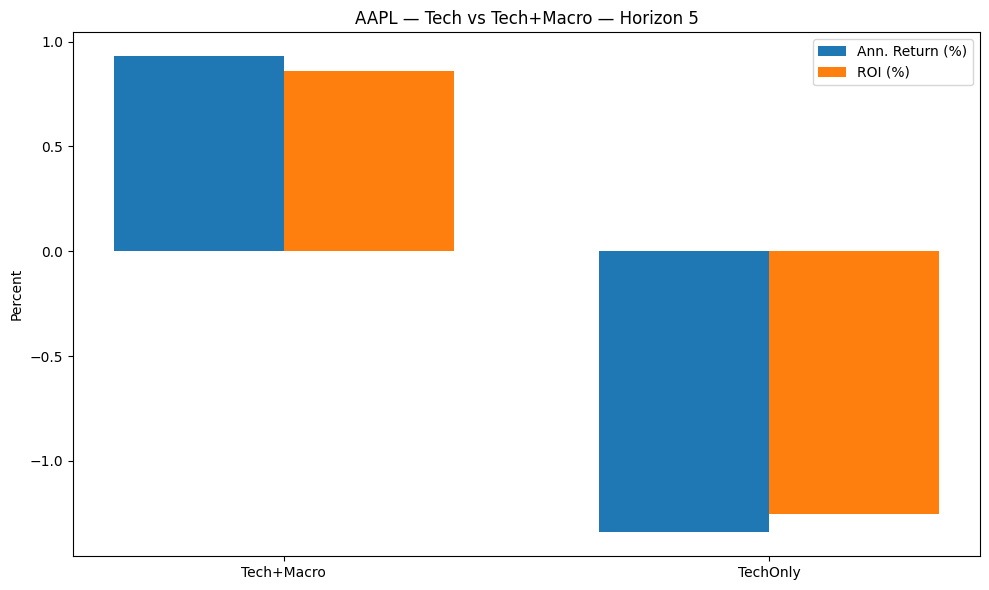

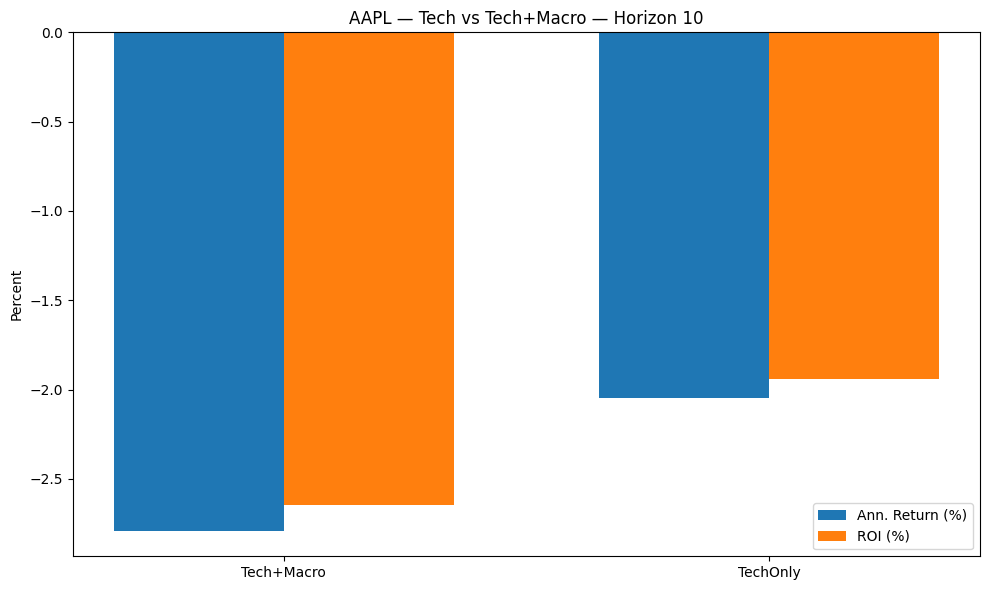

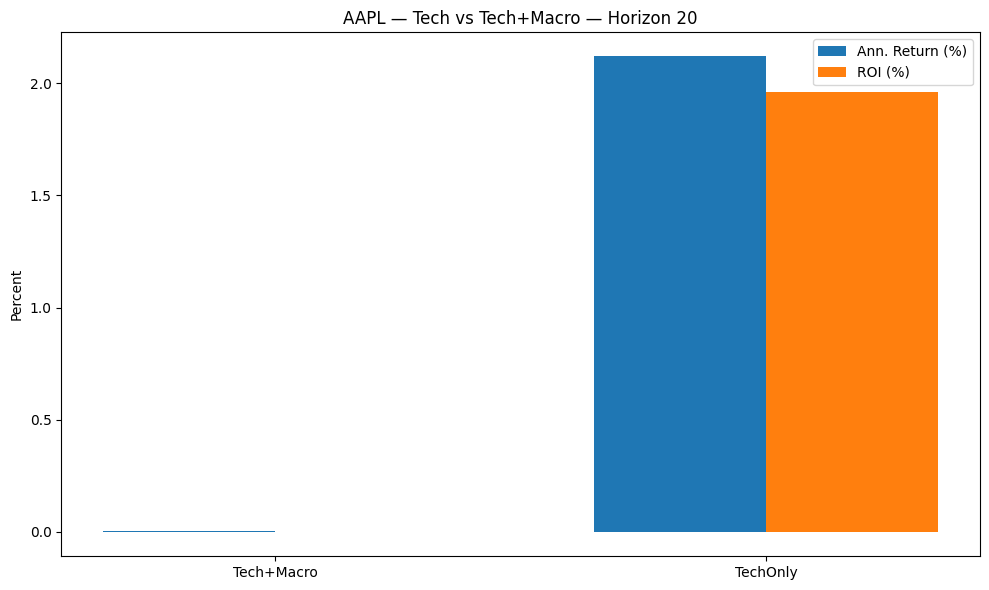

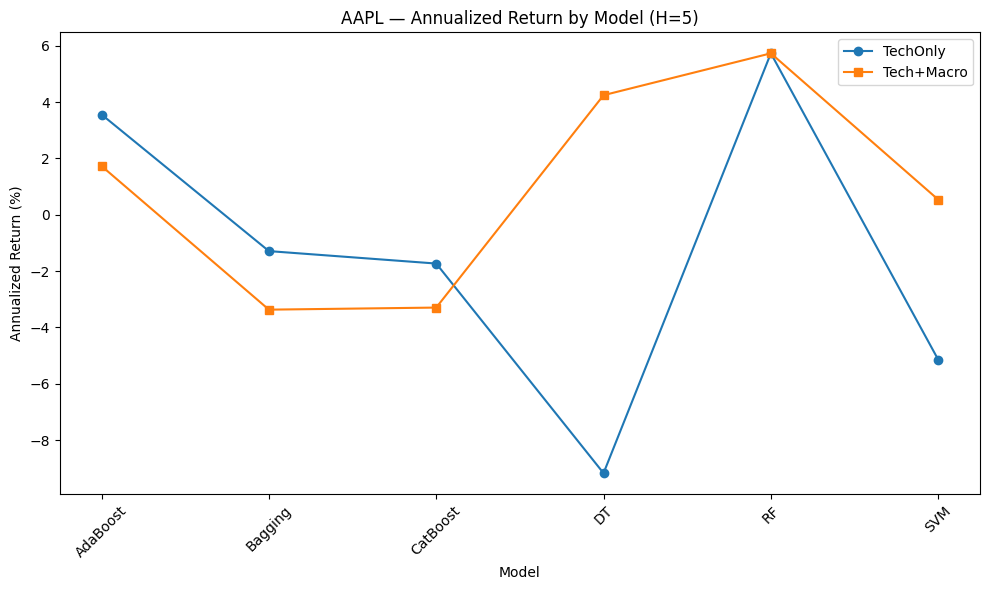

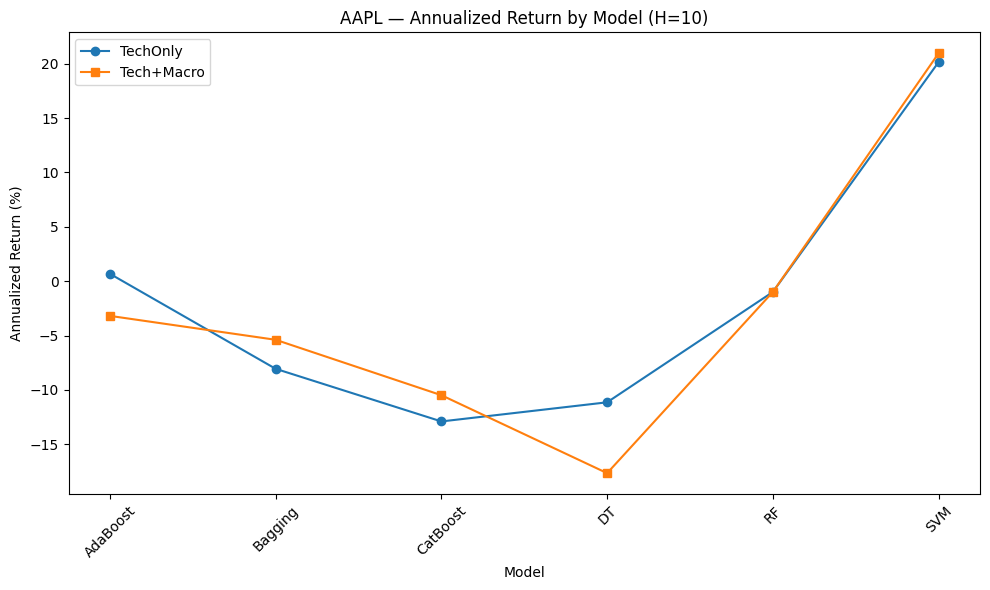

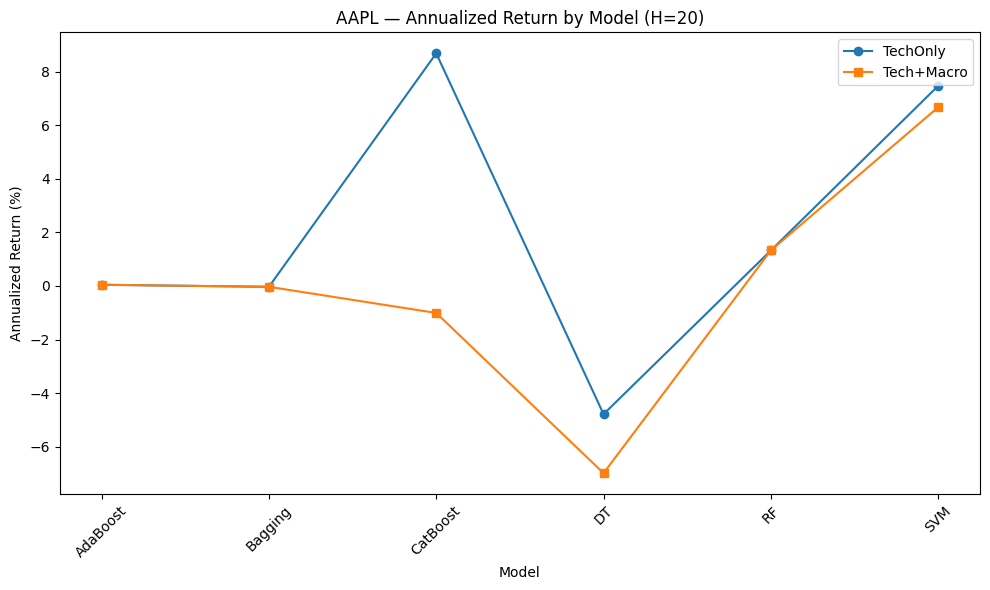


Best Tech+Macro for AAPL, H=5: RF, Ann.Return=5.73%, ROI=5.31%


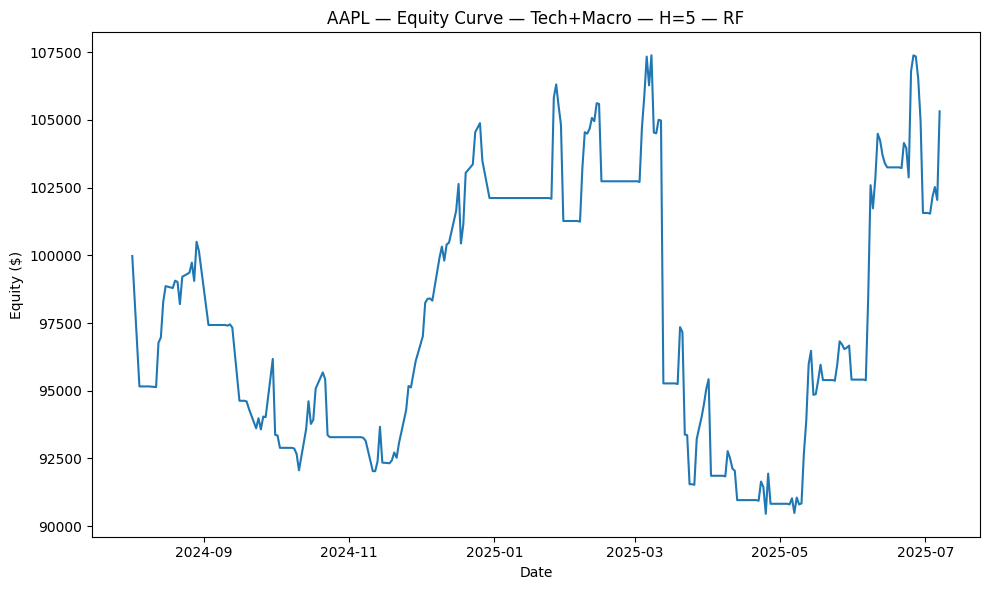

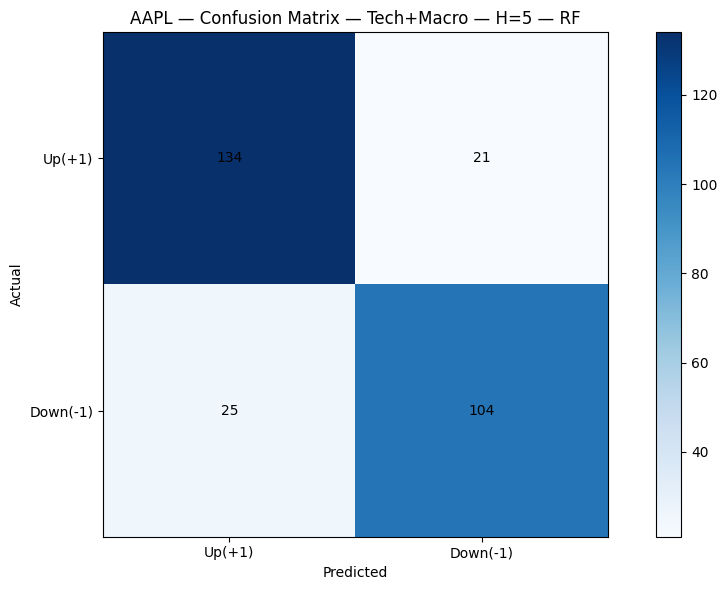

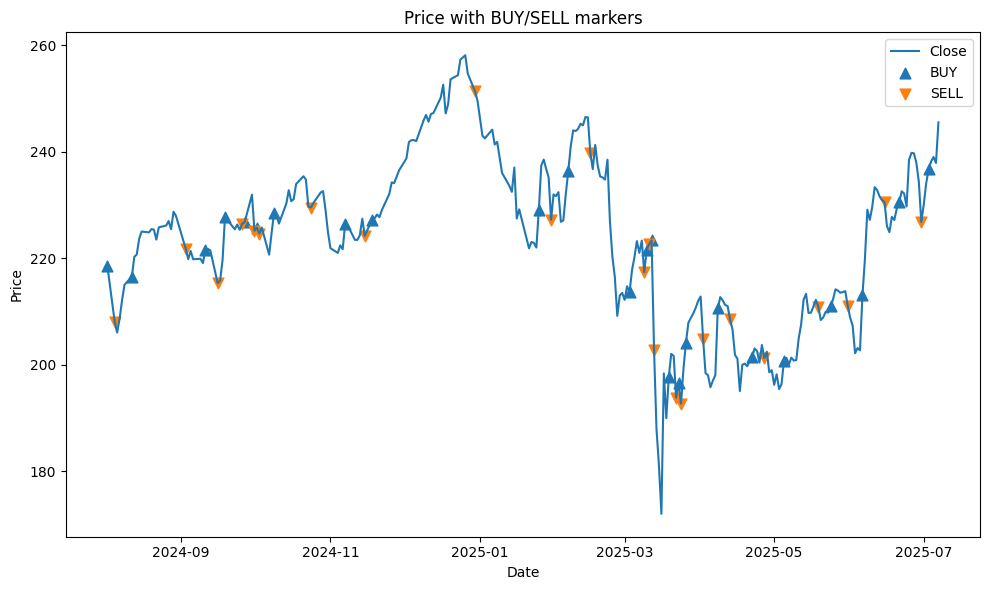

AAPL — Trade log (first 25 rows) — Tech+Macro — H=5 — RF


Date      Close  Pred_Sign  Position Action          Cash  \
0  2024-08-02  218.58849          1         1    BUY    -25.000000   
1  2024-08-05  208.05975         -1         0   SELL  95159.509571   
2  2024-08-06  206.03154         -1         0   CASH  95159.509571   
3  2024-08-07  208.60657         -1         0   CASH  95159.509571   
4  2024-08-08  212.07639         -1         0   CASH  95159.509571   
5  2024-08-09  214.98946         -1         0   CASH  95159.509571   
6  2024-08-12  216.52230          1         1    BUY    -23.789877   
7  2024-08-13  220.24496          1         1   HOLD    -23.789877   
8  2024-08-14  220.69290          1         1   HOLD    -23.789877   
9  2024-08-15  223.67900          1         1   HOLD    -23.789877   
10 2024-08-16  225.00284          1         1   HOLD    -23.789877   
11 2024-08-19  224.84358          1         1   HOLD    -23.789877   
12 2024-08-20  225.46068          1         1   HOLD    -23.789877   
13 2024-08-21  225.35121          1         1   HOLD    -23.789877   
14 2024-08-22  223.48987          1         1   HOLD    -23.789877   
15 2024-08-23  225.78917          1         1   HOLD    -23.789877   
16 2024-08-26  226.12760          1         1   HOLD    -23.789877   
17 2024-08-27  226.97365          1         1   HOLD    -23.789877   
18 2024-08-28  225.44080          1         1   HOLD    -23.789877   
19 2024-08-29  228.72551          1         1   HOLD    -23.789877   
20 2024-08-30  227.93918          1         1   HOLD    -23.789877   
21 2024-09-03  221.73804         -1         0   SELL  97427.415185   
22 2024-09-04  219.82692         -1         0   CASH  97427.415185   
23 2024-09-05  221.34982         -1         0   CASH  97427.415185   
24 2024-09-06  219.79707         -1         0   CASH  97427.415185   

        Shares         Equity  
0   457.480629   99975.000000  
1     0.000000   95159.509571  
2     0.000000   95159.509571  
3     0.000000   95159.509571  
4     0.000000   95159.509571  
5     0.000000   95159.509571  
6   439.490572   95135.719694  
7   439.490572   96771.793668  
8   439.490572   96968.659075  
9   439.490572   98281.021873  
10  439.490572   98862.837073  
11  439.490572   98792.843804  
12  439.490572   99064.053436  
13  439.490572   99015.942403  
14  439.490572   98197.901021  
15  439.490572   99208.421694  
16  439.490572   99357.158489  
17  439.490572   99728.989488  
18  439.490572   99055.316364  
19  439.490572  100498.915442  
20  439.490572  100153.330820  
21    0.000000   97427.415185  
22    0.000000   97427.415185  
23    0.000000   97427.415185  
24    0.000000   97427.415185


Best Tech+Macro for AAPL, H=10: SVM, Ann.Return=20.96%, ROI=19.33%


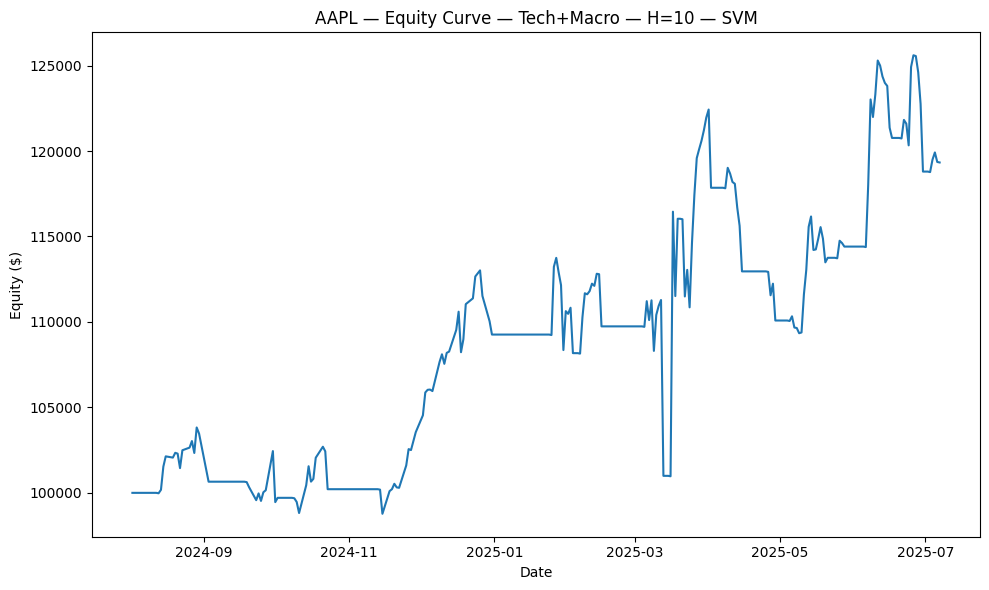

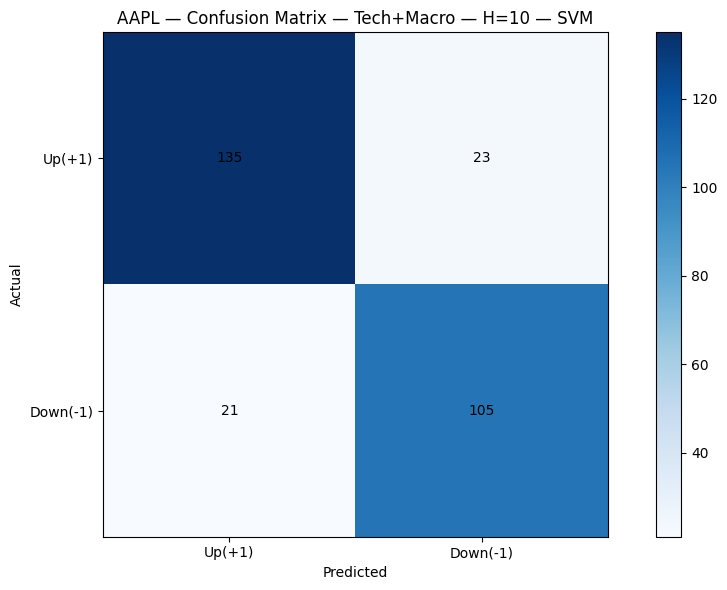

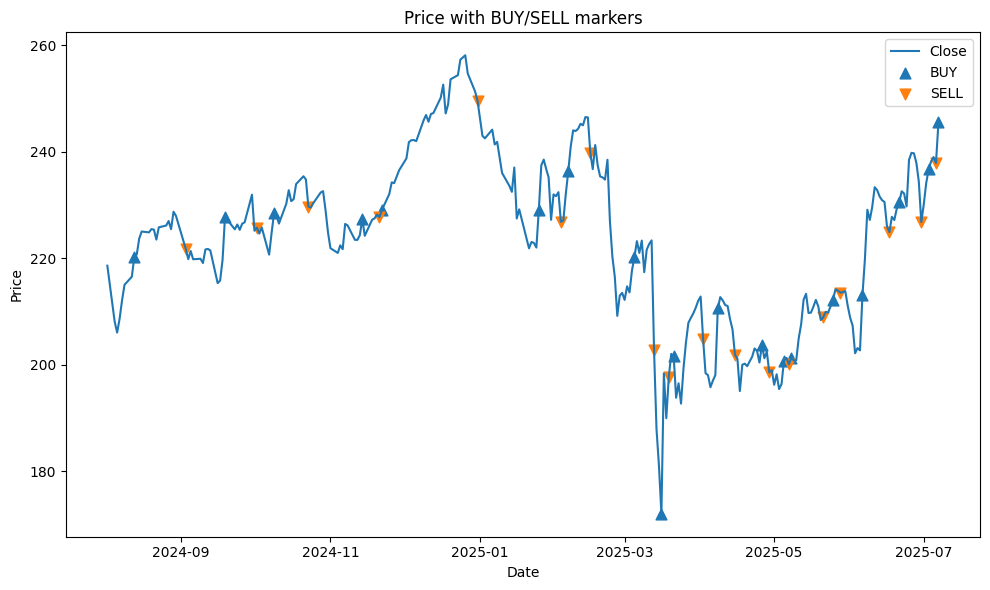

AAPL — Trade log (first 25 rows) — Tech+Macro — H=10 — SVM


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  218.58849         -1         0   CASH  100000.000000   
1  2024-08-05  208.05975         -1         0   CASH  100000.000000   
2  2024-08-06  206.03154         -1         0   CASH  100000.000000   
3  2024-08-07  208.60657         -1         0   CASH  100000.000000   
4  2024-08-08  212.07639         -1         0   CASH  100000.000000   
5  2024-08-09  214.98946         -1         0   CASH  100000.000000   
6  2024-08-12  216.52230         -1         0   CASH  100000.000000   
7  2024-08-13  220.24496          1         1    BUY     -25.000000   
8  2024-08-14  220.69290          1         1   HOLD     -25.000000   
9  2024-08-15  223.67900          1         1   HOLD     -25.000000   
10 2024-08-16  225.00284          1         1   HOLD     -25.000000   
11 2024-08-19  224.84358          1         1   HOLD     -25.000000   
12 2024-08-20  225.46068          1         1   HOLD     -25.000000   
13 2024-08-21  225.35121          1         1   HOLD     -25.000000   
14 2024-08-22  223.48987          1         1   HOLD     -25.000000   
15 2024-08-23  225.78917          1         1   HOLD     -25.000000   
16 2024-08-26  226.12760          1         1   HOLD     -25.000000   
17 2024-08-27  226.97365          1         1   HOLD     -25.000000   
18 2024-08-28  225.44080          1         1   HOLD     -25.000000   
19 2024-08-29  228.72551          1         1   HOLD     -25.000000   
20 2024-08-30  227.93918          1         1   HOLD     -25.000000   
21 2024-09-03  221.73804         -1         0   SELL  100652.748417   
22 2024-09-04  219.82692         -1         0   CASH  100652.748417   
23 2024-09-05  221.34982         -1         0   CASH  100652.748417   
24 2024-09-06  219.79707         -1         0   CASH  100652.748417   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4     0.000000  100000.000000  
5     0.000000  100000.000000  
6     0.000000  100000.000000  
7   454.039902   99975.000000  
8   454.039902  100178.382634  
9   454.039902  101534.191184  
10  454.039902  102135.267368  
11  454.039902  102062.956973  
12  454.039902  102343.144996  
13  454.039902  102293.441248  
14  454.039902  101448.318618  
15  454.039902  102492.292564  
16  454.039902  102645.953288  
17  454.039902  103030.093747  
18  454.039902  102334.118683  
19  454.039902  103825.508089  
20  454.039902  103468.482893  
21    0.000000  100652.748417  
22    0.000000  100652.748417  
23    0.000000  100652.748417  
24    0.000000  100652.748417


Best Tech+Macro for AAPL, H=20: SVM, Ann.Return=6.68%, ROI=6.19%


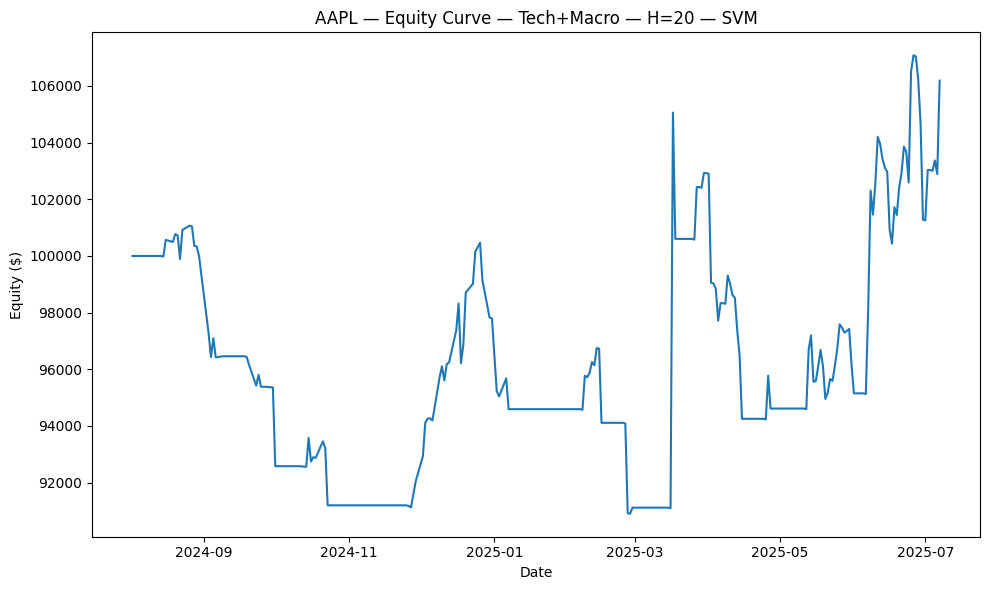

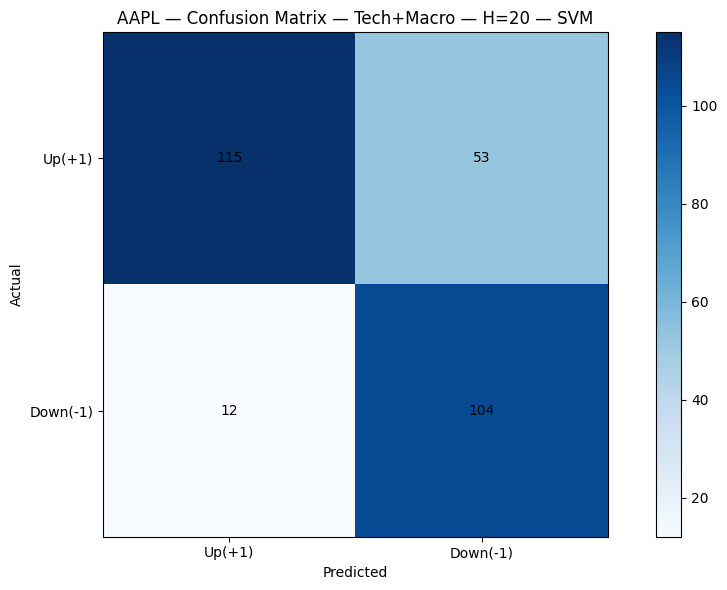

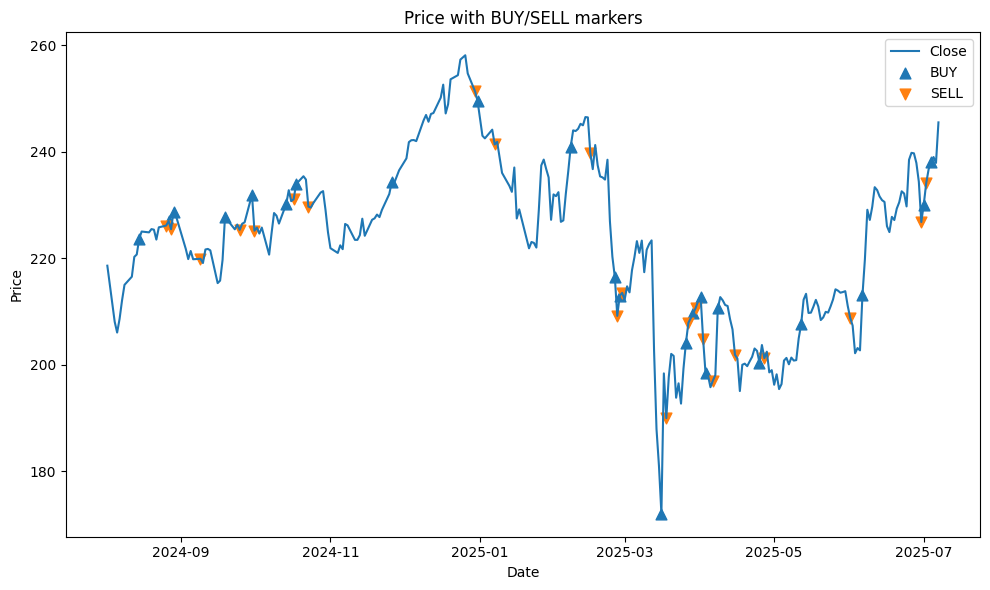

AAPL — Trade log (first 25 rows) — Tech+Macro — H=20 — SVM


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  218.58849         -1         0   CASH  100000.000000   
1  2024-08-05  208.05975         -1         0   CASH  100000.000000   
2  2024-08-06  206.03154         -1         0   CASH  100000.000000   
3  2024-08-07  208.60657         -1         0   CASH  100000.000000   
4  2024-08-08  212.07639         -1         0   CASH  100000.000000   
5  2024-08-09  214.98946         -1         0   CASH  100000.000000   
6  2024-08-12  216.52230         -1         0   CASH  100000.000000   
7  2024-08-13  220.24496         -1         0   CASH  100000.000000   
8  2024-08-14  220.69290         -1         0   CASH  100000.000000   
9  2024-08-15  223.67900          1         1    BUY     -25.000000   
10 2024-08-16  225.00284          1         1   HOLD     -25.000000   
11 2024-08-19  224.84358          1         1   HOLD     -25.000000   
12 2024-08-20  225.46068          1         1   HOLD     -25.000000   
13 2024-08-21  225.35121          1         1   HOLD     -25.000000   
14 2024-08-22  223.48987          1         1   HOLD     -25.000000   
15 2024-08-23  225.78917          1         1   HOLD     -25.000000   
16 2024-08-26  226.12760         -1         0   SELL  101069.420062   
17 2024-08-27  226.97365          1         1    BUY     -25.267355   
18 2024-08-28  225.44080         -1         0   SELL  100361.758387   
19 2024-08-29  228.72551          1         1    BUY     -25.090440   
20 2024-08-30  227.93918          1         1   HOLD     -25.090440   
21 2024-09-03  221.73804          1         1   HOLD     -25.090440   
22 2024-09-04  219.82692          1         1   HOLD     -25.090440   
23 2024-09-05  221.34982          1         1   HOLD     -25.090440   
24 2024-09-06  219.79707          1         1   HOLD     -25.090440   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4     0.000000  100000.000000  
5     0.000000  100000.000000  
6     0.000000  100000.000000  
7     0.000000  100000.000000  
8     0.000000  100000.000000  
9   447.069238   99975.000000  
10  447.069238  100566.848140  
11  447.069238  100495.647893  
12  447.069238  100771.534319  
13  447.069238  100722.593650  
14  447.069238   99890.445795  
15  447.069238  100918.392093  
16    0.000000  101069.420062  
17  445.291425  101044.152707  
18    0.000000  100361.758387  
19  438.786904  100336.667947  
20  438.786904   99991.636641  
21  438.786904   97270.657620  
22  438.786904   96432.083192  
23  438.786904   97100.311768  
24  438.786904   96418.985403

/tmp/ipython-input-1667154152.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


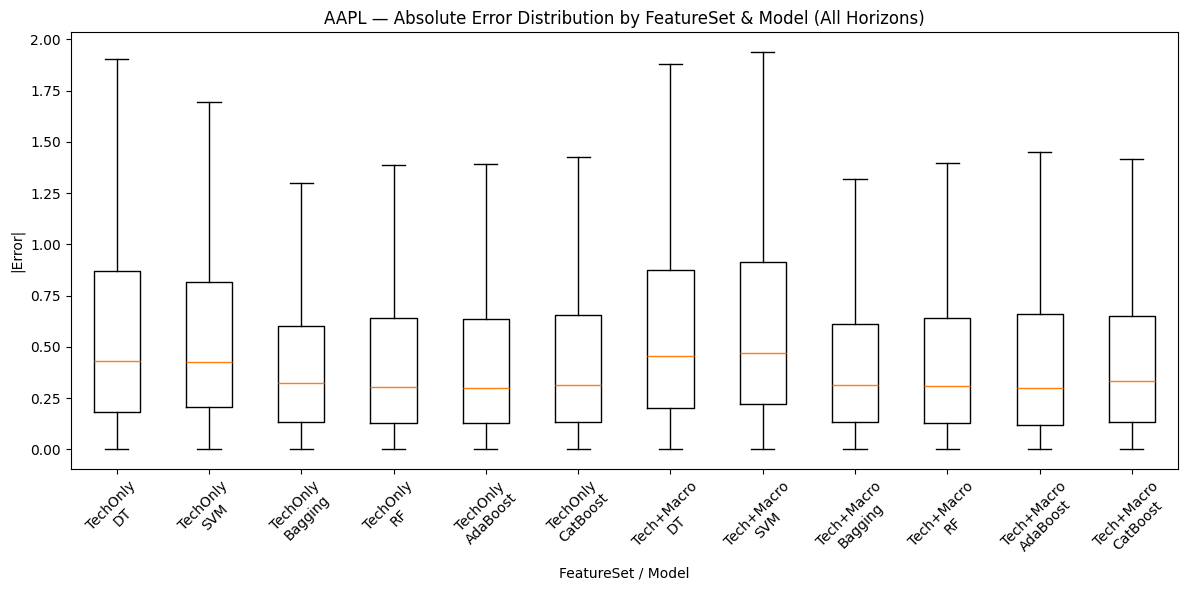

In [ ]:
res_AAPL = run_for_stock("AAPL")



==================== ADBE ====================

Feature set: TechOnly  (#features = 38)
  H=5, Model=DT, FS=TechOnly done.
  H=5, Model=SVM, FS=TechOnly done.
  H=5, Model=Bagging, FS=TechOnly done.
  H=5, Model=RF, FS=TechOnly done.
  H=5, Model=AdaBoost, FS=TechOnly done.
  H=5, Model=CatBoost, FS=TechOnly done.
  H=10, Model=DT, FS=TechOnly done.
  H=10, Model=SVM, FS=TechOnly done.
  H=10, Model=Bagging, FS=TechOnly done.
  H=10, Model=RF, FS=TechOnly done.
  H=10, Model=AdaBoost, FS=TechOnly done.
  H=10, Model=CatBoost, FS=TechOnly done.
  H=20, Model=DT, FS=TechOnly done.
  H=20, Model=SVM, FS=TechOnly done.
  H=20, Model=Bagging, FS=TechOnly done.
  H=20, Model=RF, FS=TechOnly done.
  H=20, Model=AdaBoost, FS=TechOnly done.
  H=20, Model=CatBoost, FS=TechOnly done.

Feature set: Tech+Macro  (#features = 43)
  H=5, Model=DT, FS=Tech+Macro done.
  H=5, Model=SVM, FS=Tech+Macro done.
  H=5, Model=Bagging, FS=Tech+Macro done.
  H=5, Model=RF, FS=Tech+Macro done.
  H=5, Model=AdaBo

Ticker  FeatureSet  Horizon     Model       MAE      RMSE  Accuracy  \
0    ADBE  Tech+Macro        5  AdaBoost  1.855914  2.640199  0.823944   
1    ADBE  Tech+Macro        5   Bagging  1.681087  2.409969  0.859155   
2    ADBE  Tech+Macro        5  CatBoost  1.826437  2.573913  0.834507   
3    ADBE  Tech+Macro        5        DT  2.851274  3.782774  0.711268   
4    ADBE  Tech+Macro        5        RF  1.680517  2.420390  0.845070   
5    ADBE  Tech+Macro        5       SVM  1.780855  2.589666  0.830986   
6    ADBE  Tech+Macro       10  AdaBoost  1.004411  1.368192  0.862676   
7    ADBE  Tech+Macro       10   Bagging  0.941069  1.326325  0.876761   
8    ADBE  Tech+Macro       10  CatBoost  1.059038  1.459302  0.866197   
9    ADBE  Tech+Macro       10        DT  1.561717  2.050870  0.823944   
10   ADBE  Tech+Macro       10        RF  0.980539  1.340795  0.859155   
11   ADBE  Tech+Macro       10       SVM  1.160140  1.530681  0.838028   
12   ADBE  Tech+Macro       20  AdaBoost  0.551229  0.775045  0.897887   
13   ADBE  Tech+Macro       20   Bagging  0.548777  0.766995  0.911972   
14   ADBE  Tech+Macro       20  CatBoost  0.598753  0.842643  0.911972   
15   ADBE  Tech+Macro       20        DT  0.839195  1.135625  0.883803   
16   ADBE  Tech+Macro       20        RF  0.500102  0.717686  0.940141   
17   ADBE  Tech+Macro       20       SVM  0.595416  0.832498  0.915493   
18   ADBE    TechOnly        5  AdaBoost  1.872959  2.637862  0.838028   
19   ADBE    TechOnly        5   Bagging  1.658751  2.388308  0.859155   
20   ADBE    TechOnly        5  CatBoost  1.805167  2.536123  0.845070   
21   ADBE    TechOnly        5        DT  2.676001  3.469344  0.746479   
22   ADBE    TechOnly        5        RF  1.680203  2.419148  0.845070   
23   ADBE    TechOnly        5       SVM  1.769489  2.602172  0.838028   
24   ADBE    TechOnly       10  AdaBoost  1.008011  1.366916  0.862676   
25   ADBE    TechOnly       10   Bagging  0.945376  1.322422  0.883803   
26   ADBE    TechOnly       10  CatBoost  1.013570  1.391144  0.866197   
27   ADBE    TechOnly       10        DT  1.508345  1.952100  0.813380   
28   ADBE    TechOnly       10        RF  0.978954  1.337881  0.859155   
29   ADBE    TechOnly       10       SVM  1.196809  1.616170  0.830986   
30   ADBE    TechOnly       20  AdaBoost  0.533217  0.742961  0.897887   
31   ADBE    TechOnly       20   Bagging  0.551123  0.766428  0.911972   
32   ADBE    TechOnly       20  CatBoost  0.631518  0.878391  0.894366   
33   ADBE    TechOnly       20        DT  0.812584  1.088573  0.883803   
34   ADBE    TechOnly       20        RF  0.499022  0.716087  0.940141   
35   ADBE    TechOnly       20       SVM  0.614086  0.845358  0.922535   

    Precision    Recall        F1  TotalReturn_%      ROI_%  \
0    0.783439  0.884892  0.831081     -12.589110 -12.589110   
1    0.872180  0.834532  0.852941       6.763635   6.763635   
2    0.802632  0.877698  0.838488     -10.802211 -10.802211   
3    0.696552  0.726619  0.711268     -17.393139 -17.393139   
4    0.836879  0.848921  0.842857      -7.082095  -7.082095   
5    0.809524  0.856115  0.832168     -11.705719 -11.705719   
6    0.889908  0.782258  0.832618      -8.944201  -8.944201   
7    0.844961  0.879032  0.861660     -26.628388 -26.628388   
8    0.802817  0.919355  0.857143     -28.399399 -28.399399   
9    0.772059  0.846774  0.807692     -27.154695 -27.154695   
10   0.800000  0.903226  0.848485     -12.472322 -12.472322   
11   0.770833  0.895161  0.828358     -30.839390 -30.839390   
12   0.809917  0.942308  0.871111      -9.516787  -9.516787   
13   0.826446  0.961538  0.888889      -9.366997  -9.366997   
14   0.821138  0.971154  0.889868      -2.543927  -2.543927   
15   0.808696  0.894231  0.849315      -9.256375  -9.256375   
16   0.884956  0.961538  0.921659      -9.150526  -9.150526   
17   0.827869  0.971154  0.893805     -21.625856 -21.625856   
18   0.803922  0.884892  0.842466      -9.358069  -9.358069   
19  


Average performance by FeatureSet & Horizon:


MAE    RMSE  Accuracy      F1    ROI_%  \
FeatureSet Horizon                                              
Tech+Macro 5        1.9460  2.7362    0.8175  0.8181  -8.8014   
           10       1.1178  1.5127    0.8545  0.8393 -22.4064   
           20       0.6056  0.8451    0.9102  0.8858 -10.2434   
TechOnly   5        1.9104  2.6755    0.8286  0.8273  -6.4651   
           10       1.1085  1.4978    0.8527  0.8372 -16.0756   
           20       0.6069  0.8396    0.9085  0.8835  -8.5203   

                    AnnualizedReturn_%  MaxDrawdown_%  
FeatureSet Horizon                                     
Tech+Macro 5                   -7.8514       -25.9776  
           10                 -20.1320       -33.4217  
           20                  -9.1280       -20.1894  
TechOnly   5                   -5.8064       -23.4929  
           10                 -14.3823       -28.2843  
           20                  -7.5716       -17.8928


Average performance by FeatureSet (all horizons & models):


MAE   RMSE  Accuracy      F1    ROI_%  AnnualizedReturn_%  \
FeatureSet                                                                 
Tech+Macro  1.2231  1.698    0.8607  0.8477 -13.8171            -12.3705   
TechOnly    1.2086  1.671    0.8633  0.8494 -10.3537             -9.2534   

            MaxDrawdown_%  
FeatureSet                 
Tech+Macro       -26.5296  
TechOnly         -23.2233

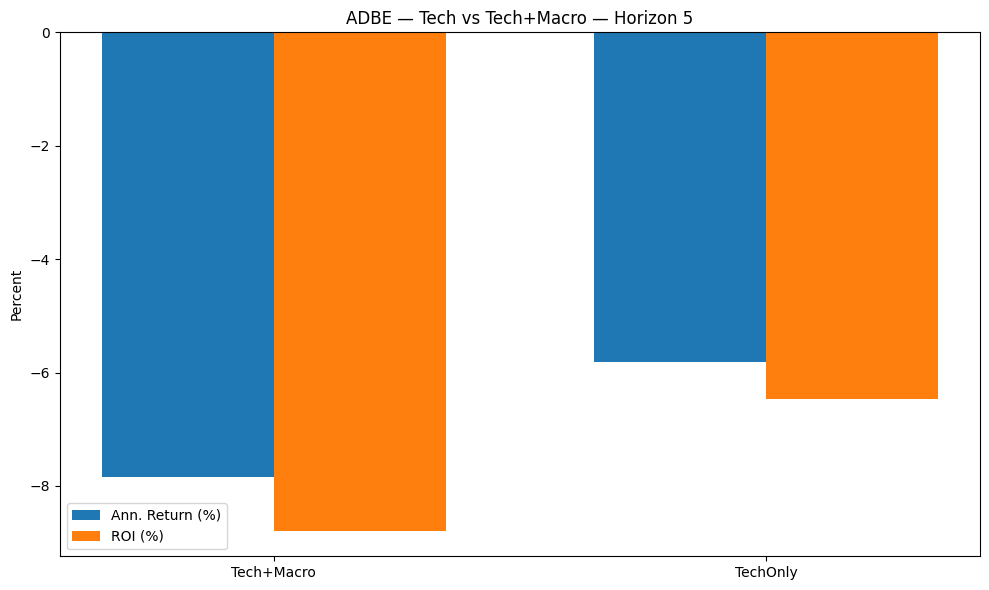

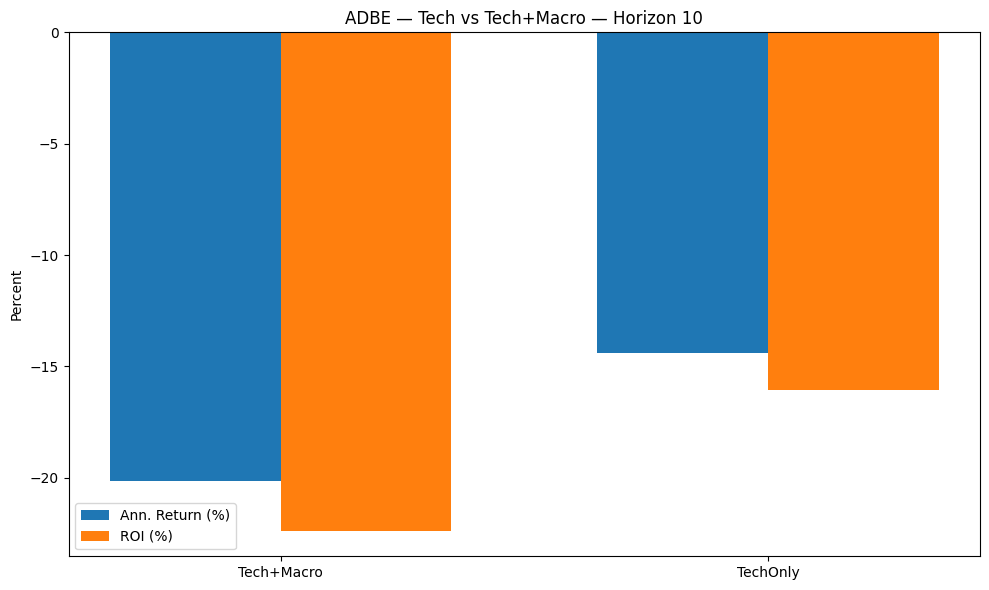

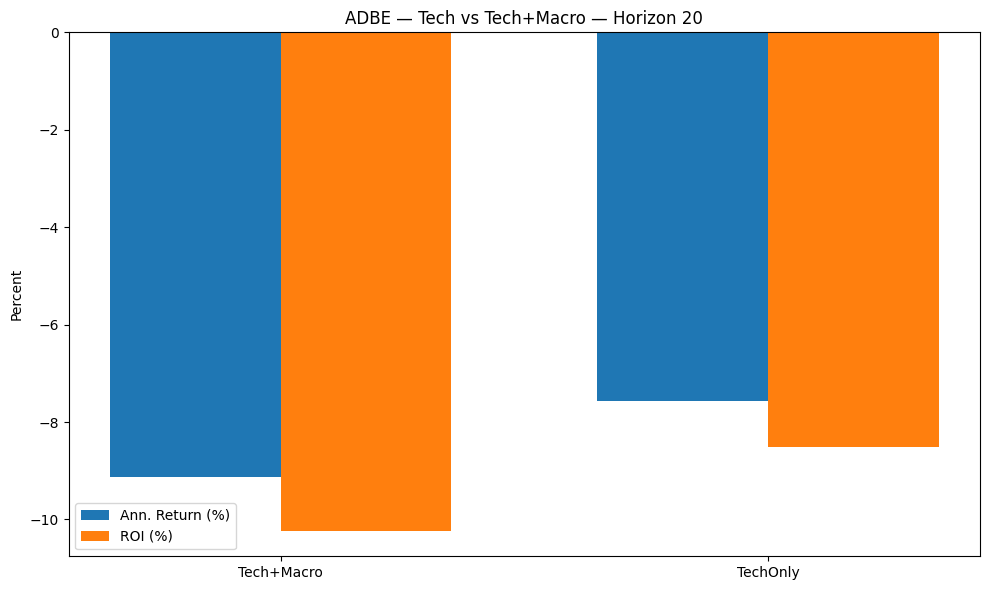

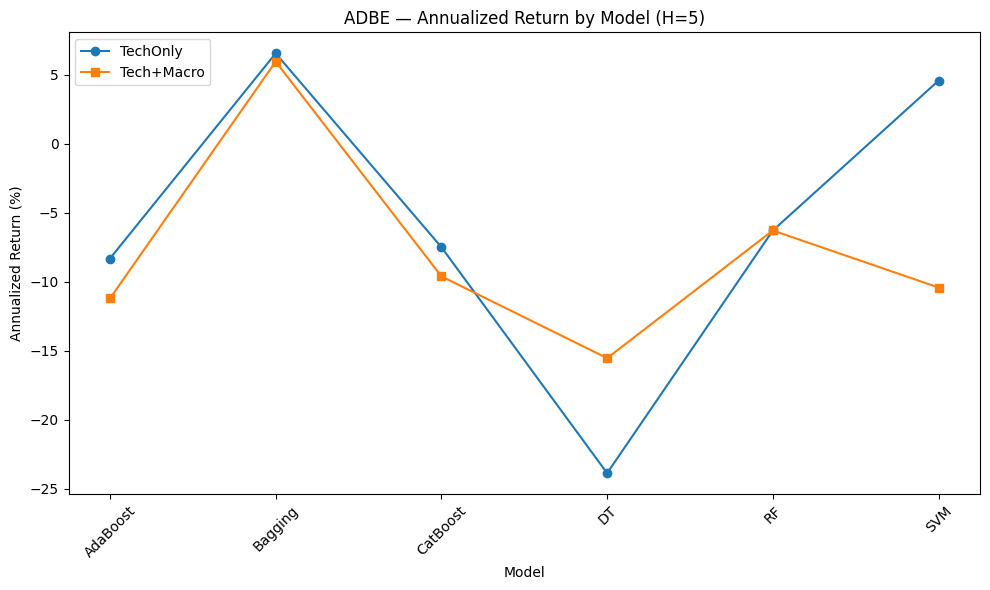

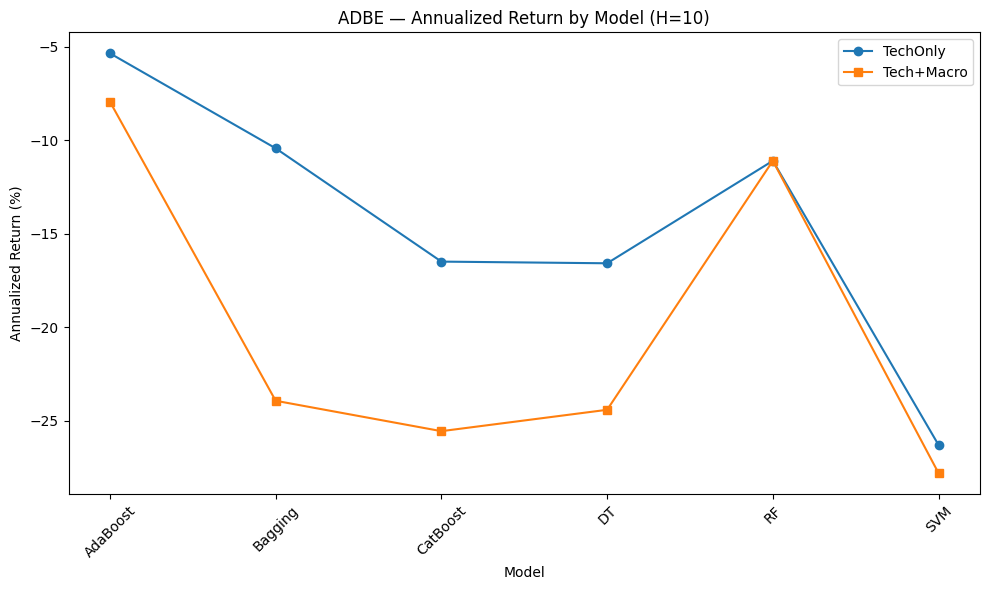

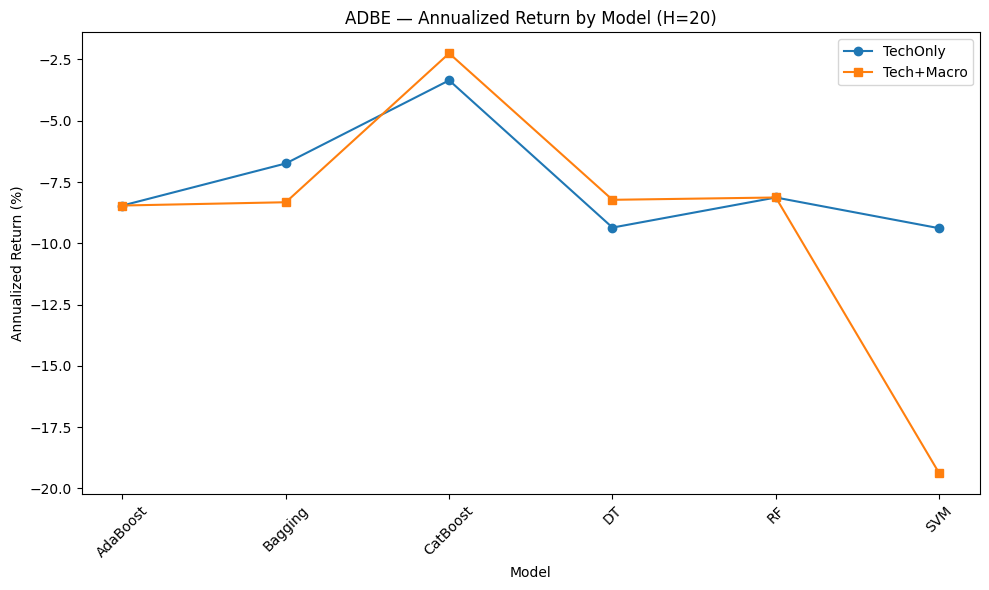


Best Tech+Macro for ADBE, H=5: Bagging, Ann.Return=5.95%, ROI=6.76%


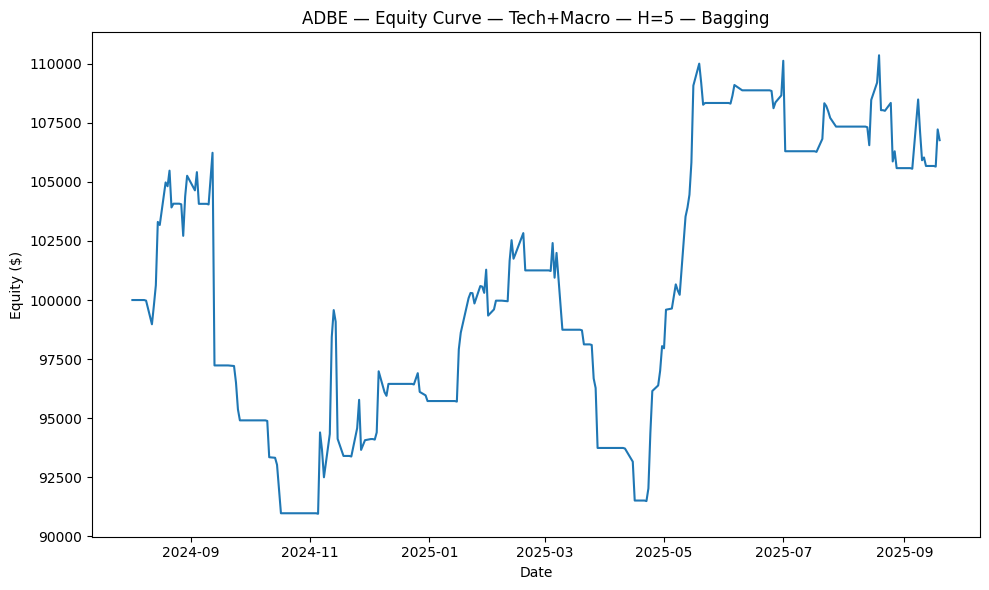

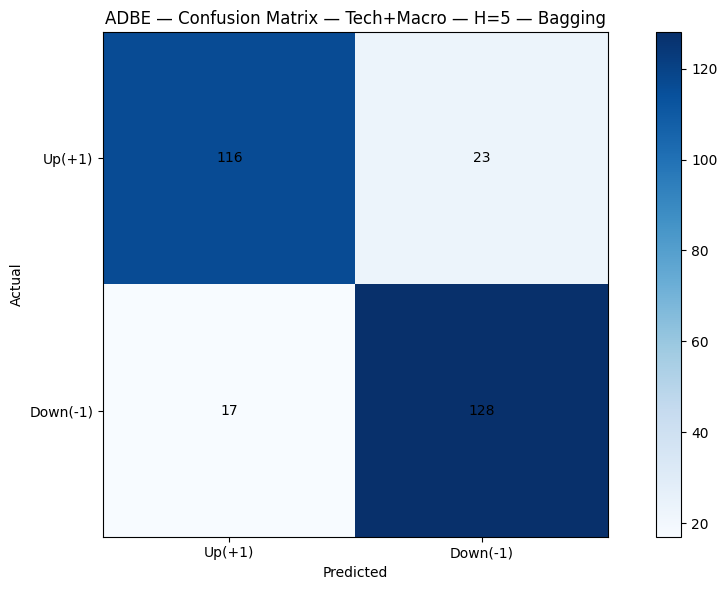

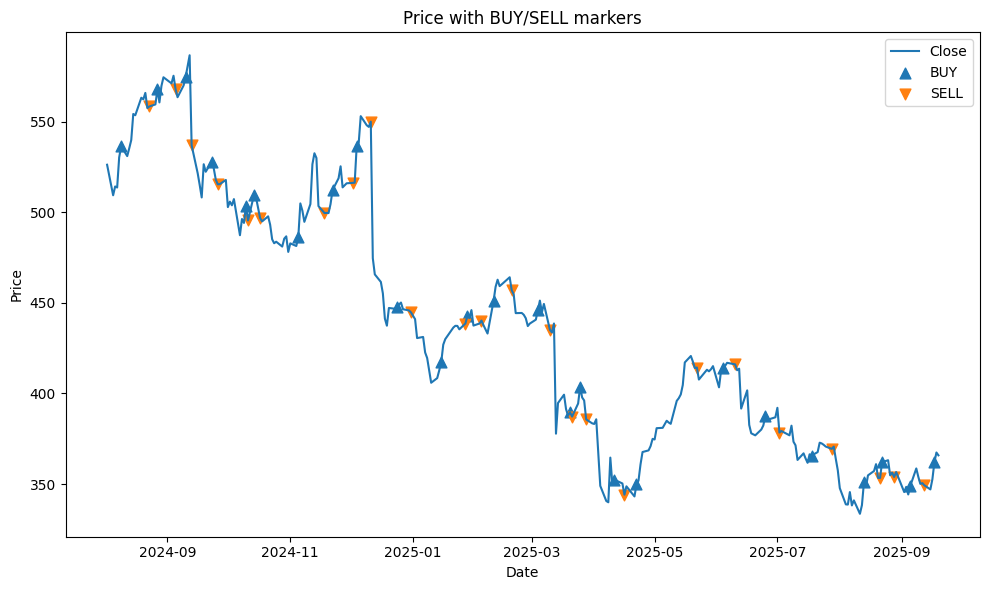

ADBE — Trade log (first 25 rows) — Tech+Macro — H=5 — Bagging


Date   Close  Pred_Sign  Position Action           Cash      Shares  \
0  2024-08-02  526.17         -1         0   CASH  100000.000000    0.000000   
1  2024-08-05  509.32         -1         0   CASH  100000.000000    0.000000   
2  2024-08-06  514.20         -1         0   CASH  100000.000000    0.000000   
3  2024-08-07  513.62         -1         0   CASH  100000.000000    0.000000   
4  2024-08-08  530.24         -1         0   CASH  100000.000000    0.000000   
5  2024-08-09  536.30          1         1    BUY     -25.000000  186.462801   
6  2024-08-12  530.93          1         1   HOLD     -25.000000  186.462801   
7  2024-08-13  535.22          1         1   HOLD     -25.000000  186.462801   
8  2024-08-14  539.79          1         1   HOLD     -25.000000  186.462801   
9  2024-08-15  554.16          1         1   HOLD     -25.000000  186.462801   
10 2024-08-16  553.46          1         1   HOLD     -25.000000  186.462801   
11 2024-08-19  563.12          1         1   HOLD     -25.000000  186.462801   
12 2024-08-20  562.25          1         1   HOLD     -25.000000  186.462801   
13 2024-08-21  565.79          1         1   HOLD     -25.000000  186.462801   
14 2024-08-22  557.44          1         1   HOLD     -25.000000  186.462801   
15 2024-08-23  558.30         -1         0   SELL  104076.156069    0.000000   
16 2024-08-26  559.44         -1         0   CASH  104076.156069    0.000000   
17 2024-08-27  567.82          1         1    BUY     -26.019039  183.290754   
18 2024-08-28  560.54          1         1   HOLD     -26.019039  183.290754   
19 2024-08-29  569.63          1         1   HOLD     -26.019039  183.290754   
20 2024-08-30  574.41          1         1   HOLD     -26.019039  183.290754   
21 2024-09-03  571.04          1         1   HOLD     -26.019039  183.290754   
22 2024-09-04  575.25          1         1   HOLD     -26.019039  183.290754   
23 2024-09-05  567.93         -1         0   SELL  104070.293973    0.000000   
24 2024-09-06  563.41         -1         0   CASH  104070.293973    0.000000   

           Equity  
0   100000.000000  
1   100000.000000  
2   100000.000000  
3   100000.000000  
4   100000.000000  
5    99975.000000  
6    98973.694760  
7    99773.620175  
8   100625.755174  
9   103305.225620  
10  103174.701660  
11  104975.932314  
12  104813.709677  
13  105473.787992  
14  103916.823606  
15  104076.156069  
16  104076.156069  
17  104050.137030  
18  102715.780340  
19  104381.893296  
20  105258.023101  
21  104640.333259  
22  105411.987334  
23  104070.293973  
24  104070.293973


Best Tech+Macro for ADBE, H=10: AdaBoost, Ann.Return=-7.95%, ROI=-8.94%


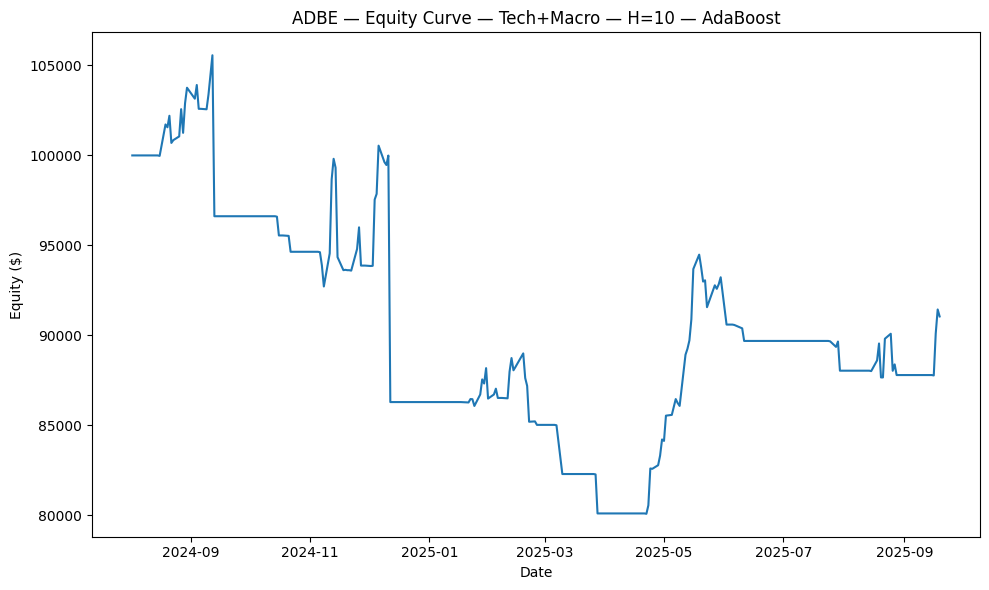

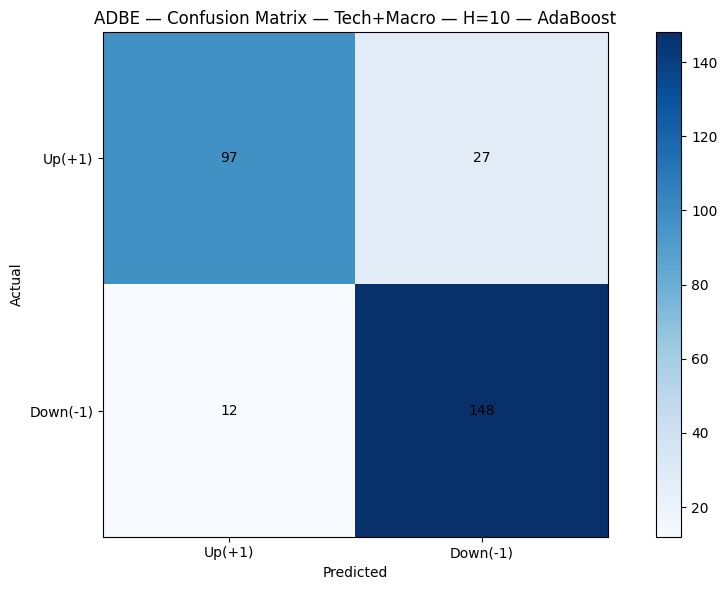

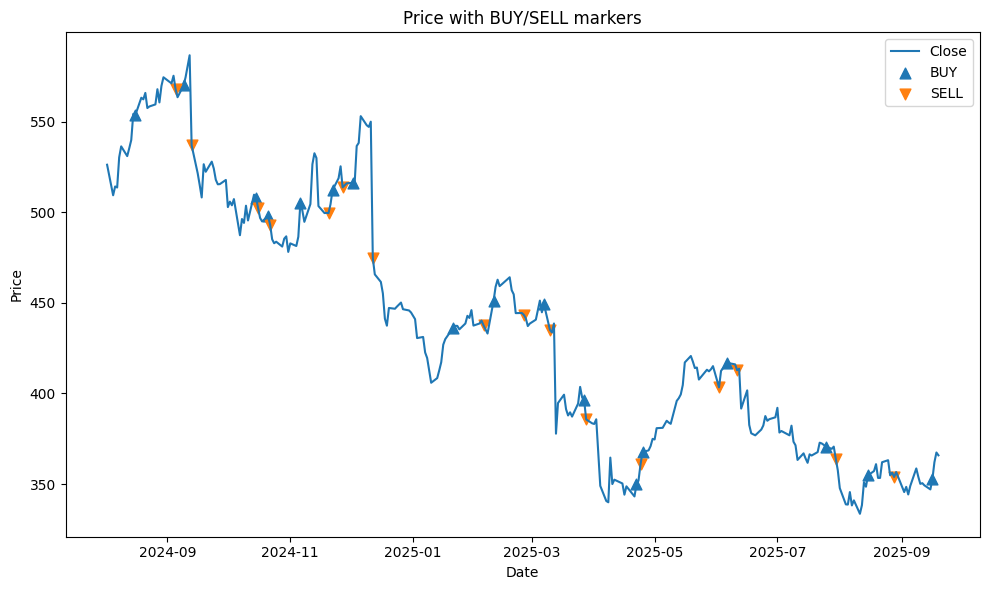

ADBE — Trade log (first 25 rows) — Tech+Macro — H=10 — AdaBoost


Date   Close  Pred_Sign  Position Action           Cash      Shares  \
0  2024-08-02  526.17         -1         0   CASH  100000.000000    0.000000   
1  2024-08-05  509.32         -1         0   CASH  100000.000000    0.000000   
2  2024-08-06  514.20         -1         0   CASH  100000.000000    0.000000   
3  2024-08-07  513.62         -1         0   CASH  100000.000000    0.000000   
4  2024-08-08  530.24         -1         0   CASH  100000.000000    0.000000   
5  2024-08-09  536.30         -1         0   CASH  100000.000000    0.000000   
6  2024-08-12  530.93         -1         0   CASH  100000.000000    0.000000   
7  2024-08-13  535.22         -1         0   CASH  100000.000000    0.000000   
8  2024-08-14  539.79         -1         0   CASH  100000.000000    0.000000   
9  2024-08-15  554.16         -1         0   CASH  100000.000000    0.000000   
10 2024-08-16  553.46          1         1    BUY     -25.000000  180.681531   
11 2024-08-19  563.12          1         1   HOLD     -25.000000  180.681531   
12 2024-08-20  562.25          1         1   HOLD     -25.000000  180.681531   
13 2024-08-21  565.79          1         1   HOLD     -25.000000  180.681531   
14 2024-08-22  557.44          1         1   HOLD     -25.000000  180.681531   
15 2024-08-23  558.30          1         1   HOLD     -25.000000  180.681531   
16 2024-08-26  559.44          1         1   HOLD     -25.000000  180.681531   
17 2024-08-27  567.82          1         1   HOLD     -25.000000  180.681531   
18 2024-08-28  560.54          1         1   HOLD     -25.000000  180.681531   
19 2024-08-29  569.63          1         1   HOLD     -25.000000  180.681531   
20 2024-08-30  574.41          1         1   HOLD     -25.000000  180.681531   
21 2024-09-03  571.04          1         1   HOLD     -25.000000  180.681531   
22 2024-09-04  575.25          1         1   HOLD     -25.000000  180.681531   
23 2024-09-05  567.93         -1         0   SELL  102588.808134    0.000000   
24 2024-09-06  563.41         -1         0   CASH  102588.808134    0.000000   

           Equity  
0   100000.000000  
1   100000.000000  
2   100000.000000  
3   100000.000000  
4   100000.000000  
5   100000.000000  
6   100000.000000  
7   100000.000000  
8   100000.000000  
9   100000.000000  
10   99975.000000  
11  101720.383587  
12  101563.190655  
13  102202.803274  
14  100694.112492  
15  100849.498609  
16  101055.475554  
17  102569.586781  
18  101254.225238  
19  102896.620352  
20  103760.278069  
21  103151.381310  
22  103912.050555  
23  102588.808134  
24  102588.808134


Best Tech+Macro for ADBE, H=20: CatBoost, Ann.Return=-2.25%, ROI=-2.54%


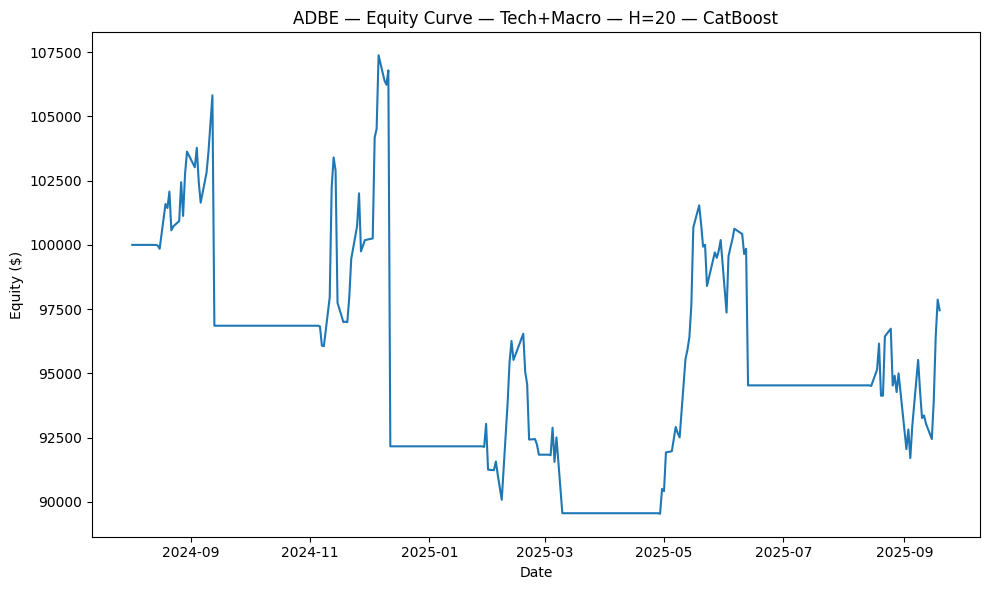

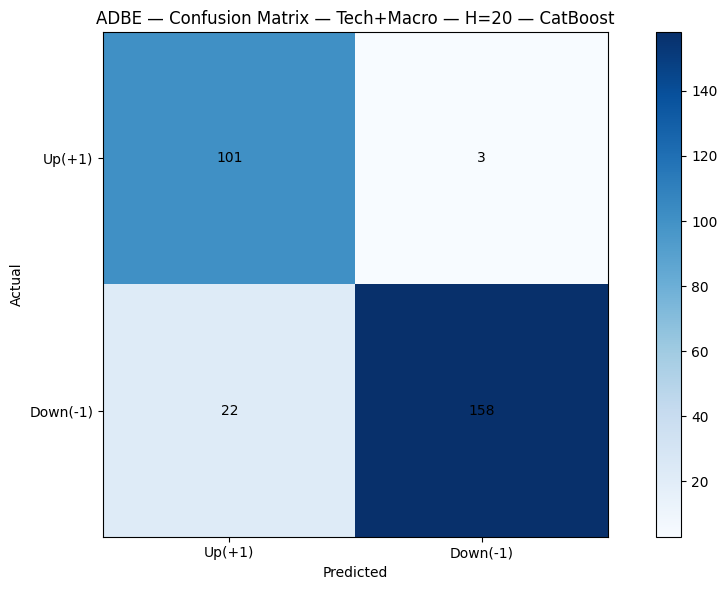

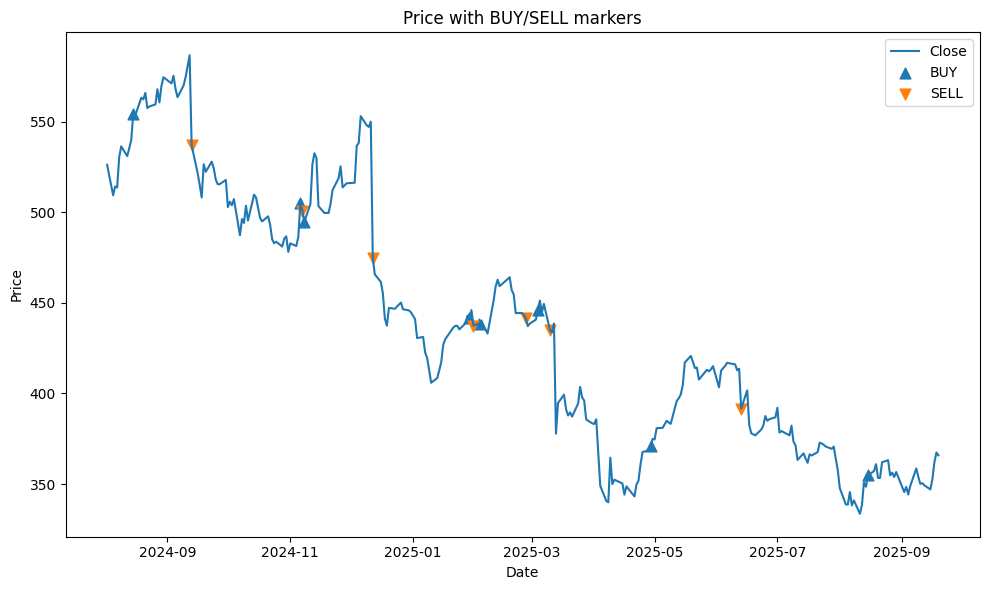

ADBE — Trade log (first 25 rows) — Tech+Macro — H=20 — CatBoost


Date   Close  Pred_Sign  Position Action      Cash      Shares  \
0  2024-08-02  526.17         -1         0   CASH  100000.0    0.000000   
1  2024-08-05  509.32         -1         0   CASH  100000.0    0.000000   
2  2024-08-06  514.20         -1         0   CASH  100000.0    0.000000   
3  2024-08-07  513.62         -1         0   CASH  100000.0    0.000000   
4  2024-08-08  530.24         -1         0   CASH  100000.0    0.000000   
5  2024-08-09  536.30         -1         0   CASH  100000.0    0.000000   
6  2024-08-12  530.93         -1         0   CASH  100000.0    0.000000   
7  2024-08-13  535.22         -1         0   CASH  100000.0    0.000000   
8  2024-08-14  539.79         -1         0   CASH  100000.0    0.000000   
9  2024-08-15  554.16          1         1    BUY     -25.0  180.453299   
10 2024-08-16  553.46          1         1   HOLD     -25.0  180.453299   
11 2024-08-19  563.12          1         1   HOLD     -25.0  180.453299   
12 2024-08-20  562.25          1         1   HOLD     -25.0  180.453299   
13 2024-08-21  565.79          1         1   HOLD     -25.0  180.453299   
14 2024-08-22  557.44          1         1   HOLD     -25.0  180.453299   
15 2024-08-23  558.30          1         1   HOLD     -25.0  180.453299   
16 2024-08-26  559.44          1         1   HOLD     -25.0  180.453299   
17 2024-08-27  567.82          1         1   HOLD     -25.0  180.453299   
18 2024-08-28  560.54          1         1   HOLD     -25.0  180.453299   
19 2024-08-29  569.63          1         1   HOLD     -25.0  180.453299   
20 2024-08-30  574.41          1         1   HOLD     -25.0  180.453299   
21 2024-09-03  571.04          1         1   HOLD     -25.0  180.453299   
22 2024-09-04  575.25          1         1   HOLD     -25.0  180.453299   
23 2024-09-05  567.93          1         1   HOLD     -25.0  180.453299   
24 2024-09-06  563.41          1         1   HOLD     -25.0  180.453299   

           Equity  
0   100000.000000  
1   100000.000000  
2   100000.000000  
3   100000.000000  
4   100000.000000  
5   100000.000000  
6   100000.000000  
7   100000.000000  
8   100000.000000  
9    99975.000000  
10   99848.682691  
11  101591.861556  
12  101434.867186  
13  102073.671864  
14  100566.886820  
15  100722.076657  
16  100927.793417  
17  102439.992060  
18  101126.292046  
19  102766.612531  
20  103629.179298  
21  103021.051682  
22  103780.760069  
23  102459.841923  
24  101644.193013

/tmp/ipython-input-1667154152.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


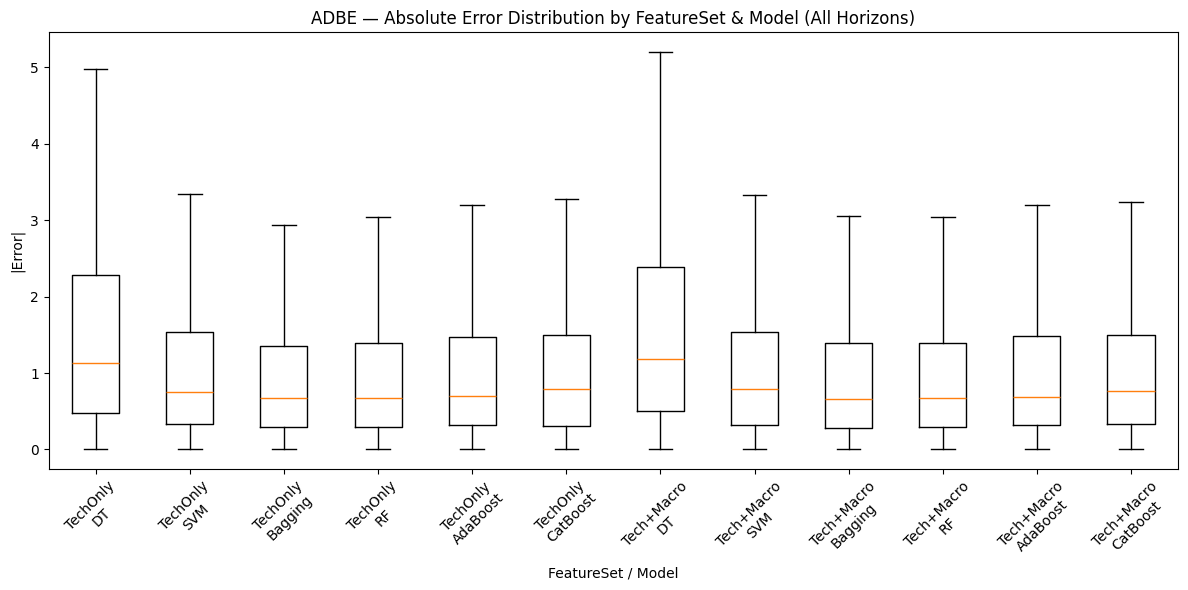

In [ ]:
res_ADBE = run_for_stock("ADBE")



==================== AMD ====================

Feature set: TechOnly  (#features = 38)
  H=5, Model=DT, FS=TechOnly done.
  H=5, Model=SVM, FS=TechOnly done.
  H=5, Model=Bagging, FS=TechOnly done.
  H=5, Model=RF, FS=TechOnly done.
  H=5, Model=AdaBoost, FS=TechOnly done.
  H=5, Model=CatBoost, FS=TechOnly done.
  H=10, Model=DT, FS=TechOnly done.
  H=10, Model=SVM, FS=TechOnly done.
  H=10, Model=Bagging, FS=TechOnly done.
  H=10, Model=RF, FS=TechOnly done.
  H=10, Model=AdaBoost, FS=TechOnly done.
  H=10, Model=CatBoost, FS=TechOnly done.
  H=20, Model=DT, FS=TechOnly done.
  H=20, Model=SVM, FS=TechOnly done.
  H=20, Model=Bagging, FS=TechOnly done.
  H=20, Model=RF, FS=TechOnly done.
  H=20, Model=AdaBoost, FS=TechOnly done.
  H=20, Model=CatBoost, FS=TechOnly done.

Feature set: Tech+Macro  (#features = 43)
  H=5, Model=DT, FS=Tech+Macro done.
  H=5, Model=SVM, FS=Tech+Macro done.
  H=5, Model=Bagging, FS=Tech+Macro done.
  H=5, Model=RF, FS=Tech+Macro done.
  H=5, Model=AdaBoo

Ticker  FeatureSet  Horizon     Model       MAE      RMSE  Accuracy  \
0     AMD  Tech+Macro        5  AdaBoost  0.823841  1.080278  0.841549   
1     AMD  Tech+Macro        5   Bagging  0.788431  1.049102  0.834507   
2     AMD  Tech+Macro        5  CatBoost  0.779241  1.031631  0.834507   
3     AMD  Tech+Macro        5        DT  1.209085  1.515448  0.711268   
4     AMD  Tech+Macro        5        RF  0.809160  1.065590  0.852113   
5     AMD  Tech+Macro        5       SVM  0.971886  1.242331  0.795775   
6     AMD  Tech+Macro       10  AdaBoost  0.446695  0.567911  0.876761   
7     AMD  Tech+Macro       10   Bagging  0.447288  0.570509  0.869718   
8     AMD  Tech+Macro       10  CatBoost  0.428882  0.547733  0.887324   
9     AMD  Tech+Macro       10        DT  0.635965  0.788449  0.806338   
10    AMD  Tech+Macro       10        RF  0.431264  0.550445  0.873239   
11    AMD  Tech+Macro       10       SVM  0.511966  0.660784  0.838028   
12    AMD  Tech+Macro       20  AdaBoost  0.246604  0.318818  0.908451   
13    AMD  Tech+Macro       20   Bagging  0.246497  0.319967  0.919014   
14    AMD  Tech+Macro       20  CatBoost  0.222530  0.287862  0.933099   
15    AMD  Tech+Macro       20        DT  0.354752  0.444424  0.859155   
16    AMD  Tech+Macro       20        RF  0.233829  0.309304  0.911972   
17    AMD  Tech+Macro       20       SVM  0.296688  0.375956  0.926056   
18    AMD    TechOnly        5  AdaBoost  0.822441  1.077241  0.838028   
19    AMD    TechOnly        5   Bagging  0.792998  1.053367  0.848592   
20    AMD    TechOnly        5  CatBoost  0.763570  1.017152  0.855634   
21    AMD    TechOnly        5        DT  1.202881  1.496322  0.725352   
22    AMD    TechOnly        5        RF  0.808140  1.064829  0.852113   
23    AMD    TechOnly        5       SVM  1.020569  1.280311  0.778169   
24    AMD    TechOnly       10  AdaBoost  0.444259  0.565975  0.873239   
25    AMD    TechOnly       10   Bagging  0.448430  0.573515  0.876761   
26    AMD    TechOnly       10  CatBoost  0.422681  0.537132  0.880282   
27    AMD    TechOnly       10        DT  0.636972  0.789964  0.792254   
28    AMD    TechOnly       10        RF  0.431491  0.550522  0.873239   
29    AMD    TechOnly       10       SVM  0.545589  0.688664  0.827465   
30    AMD    TechOnly       20  AdaBoost  0.246459  0.319268  0.908451   
31    AMD    TechOnly       20   Bagging  0.248141  0.320734  0.919014   
32    AMD    TechOnly       20  CatBoost  0.227696  0.291700  0.936620   
33    AMD    TechOnly       20        DT  0.348896  0.437449  0.859155   
34    AMD    TechOnly       20        RF  0.233864  0.309270  0.911972   
35    AMD    TechOnly       20       SVM  0.309954  0.392014  0.883803   

    Precision    Recall        F1  TotalReturn_%      ROI_%  \
0    0.865248  0.824324  0.844291      17.857123  17.857123   
1    0.838926  0.844595  0.841751       9.082612   9.082612   
2    0.830065  0.858108  0.843854       7.757493   7.757493   
3    0.698795  0.783784  0.738854      12.899955  12.899955   
4    0.848684  0.871622  0.860000      11.967933  11.967933   
5    0.761628  0.885135  0.818750      10.452538  10.452538   
6    0.854167  0.897810  0.875445      18.617906  18.617906   
7    0.852113  0.883212  0.867384      11.644223  11.644223   
8    0.883212  0.883212  0.883212      38.472385  38.472385   
9    0.792857  0.810219  0.801444      -7.903007  -7.903007   
10   0.868613  0.868613  0.868613      36.115980  36.115980   
11   0.779141  0.927007  0.846667      -2.844401  -2.844401   
12   0.956897  0.840909  0.895161      11.885924  11.885924   
13   0.950413  0.871212  0.909091       8.315837   8.315837   
14   0.944882  0.909091  0.926641      11.515157  11.515157   
15   0.859375  0.833333  0.846154      13.346009  13.346009   
16   0.957265  0.848485  0.899598      12.081872  12.081872   
17   0.930233  0.909091  0.919540      26.918181  26.918181   
18   0.854167  0.831081  0.842466      10.585233  10.585233   
19  


Average performance by FeatureSet & Horizon:


MAE    RMSE  Accuracy      F1    ROI_%  \
FeatureSet Horizon                                              
Tech+Macro 5        0.8969  1.1641    0.8116  0.8246  11.6696   
           10       0.4837  0.6143    0.8586  0.8571  15.6838   
           20       0.2668  0.3427    0.9096  0.8994  14.0105   
TechOnly   5        0.9018  1.1649    0.8163  0.8296  10.3169   
           10       0.4882  0.6176    0.8539  0.8520  13.1691   
           20       0.2692  0.3451    0.9032  0.8929   9.5694   

                    AnnualizedReturn_%  MaxDrawdown_%  
FeatureSet Horizon                                     
Tech+Macro 5                   10.2415       -37.5466  
           10                  13.6054       -39.5208  
           20                  12.2709       -31.6164  
TechOnly   5                    9.0215       -38.6186  
           10                  11.3559       -38.9460  
           20                   8.4048       -32.8116


Average performance by FeatureSet (all horizons & models):


MAE    RMSE  Accuracy      F1    ROI_%  AnnualizedReturn_%  \
FeatureSet                                                                  
Tech+Macro  0.5491  0.7070    0.8599  0.8604  13.7880             12.0392   
TechOnly    0.5531  0.7092    0.8578  0.8582  11.0185              9.5941   

            MaxDrawdown_%  
FeatureSet                 
Tech+Macro       -36.2279  
TechOnly         -36.7921

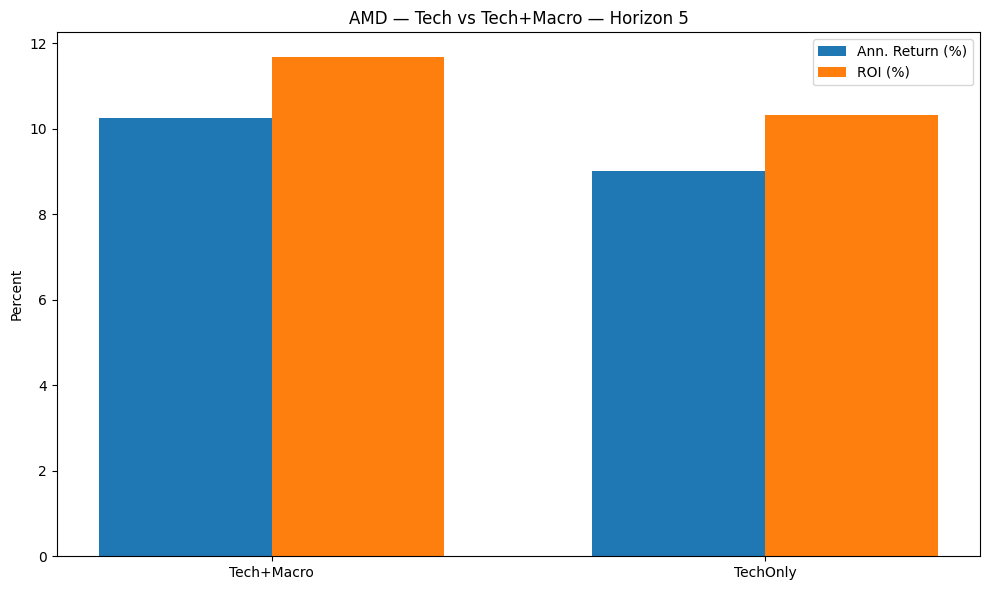

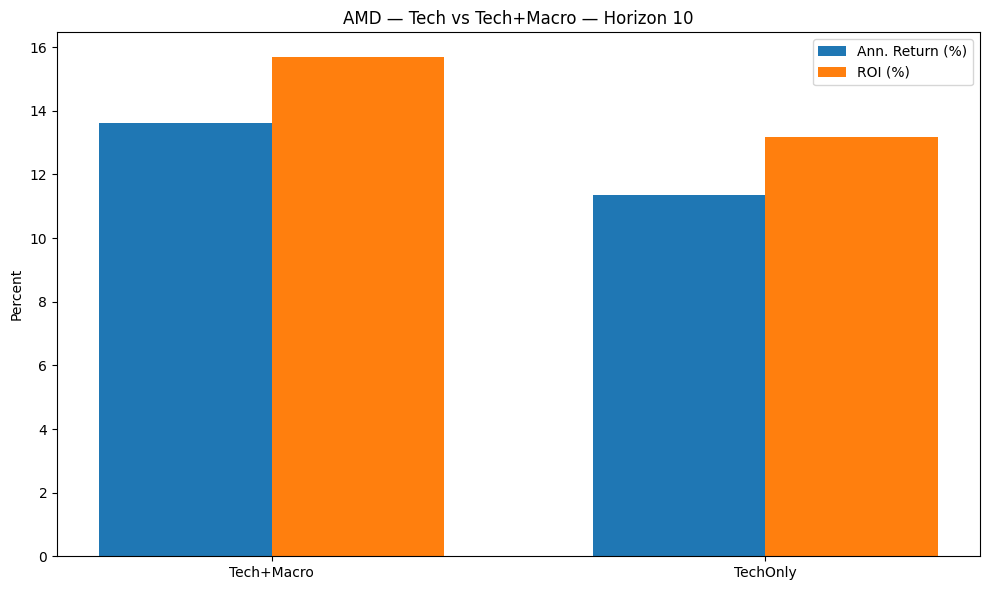

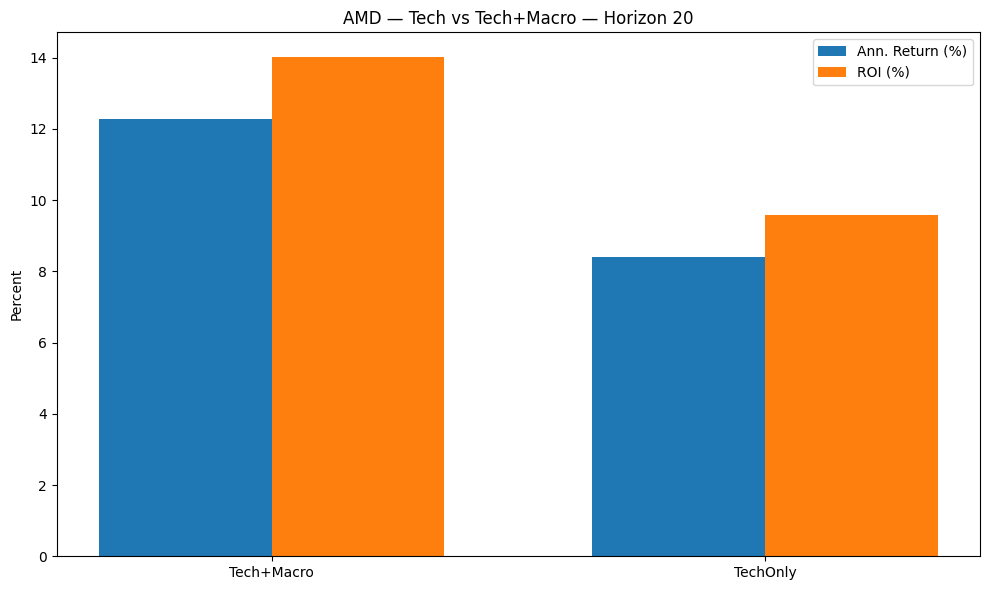

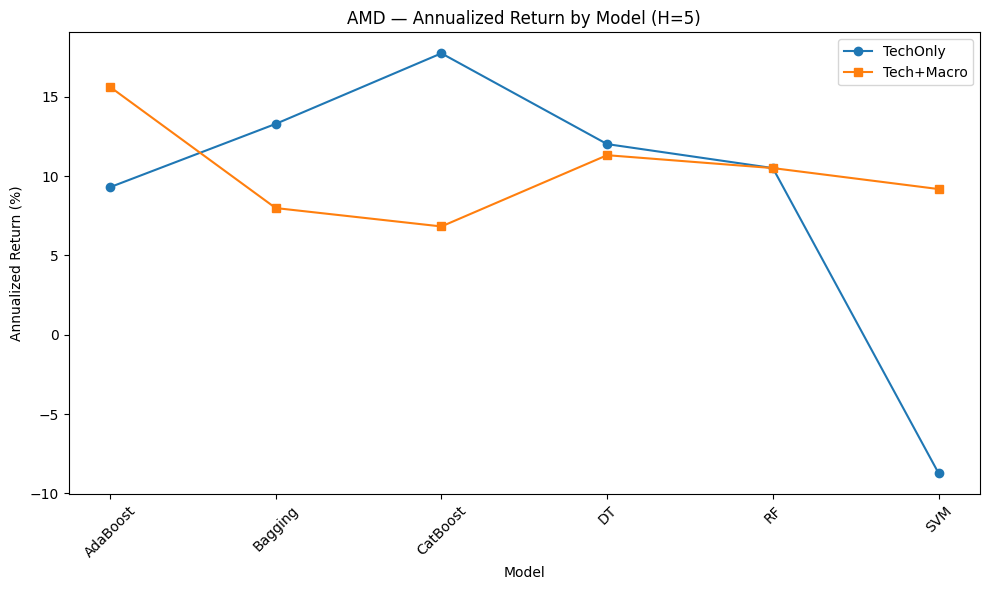

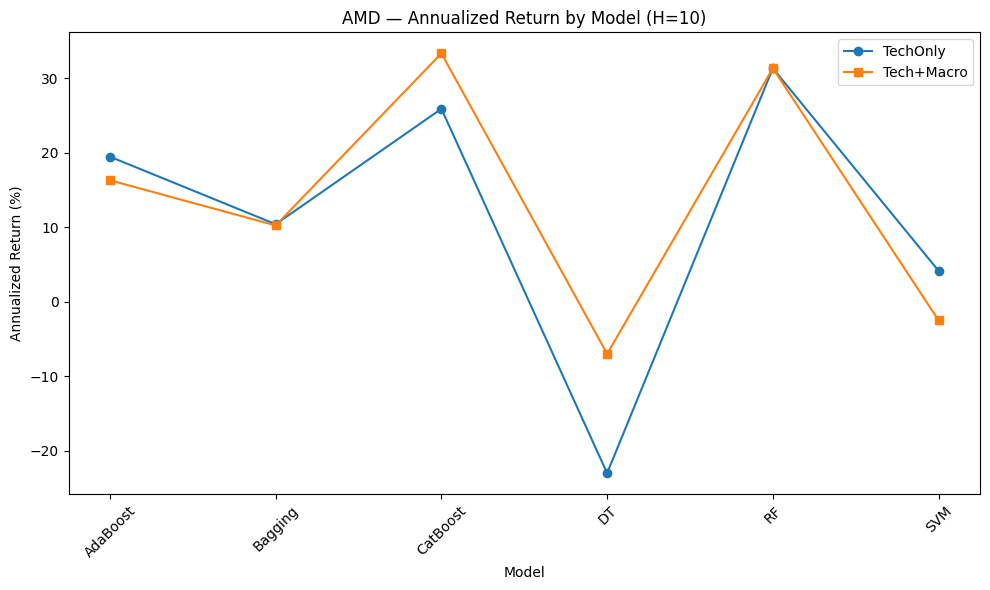

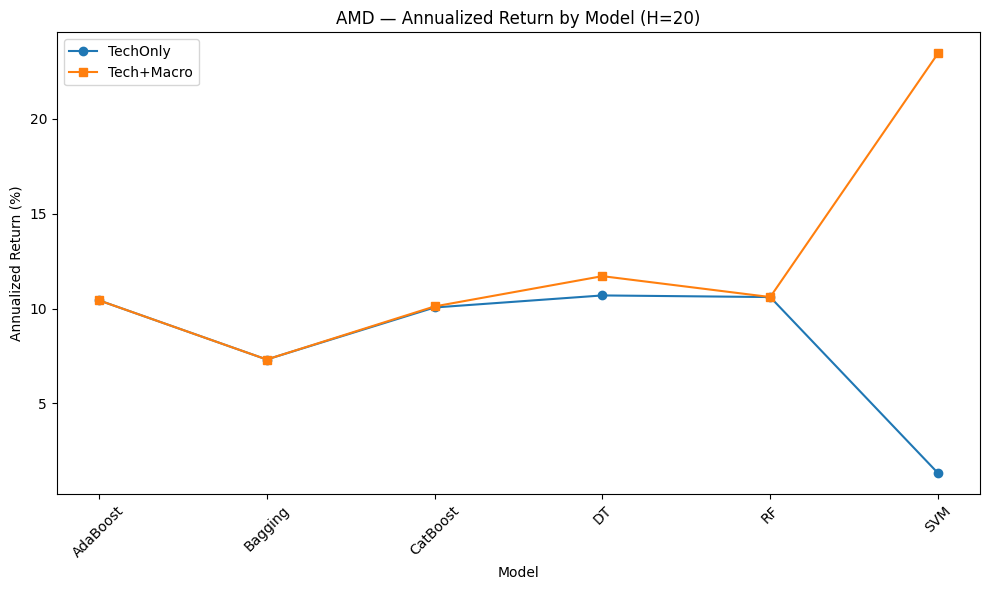


Best Tech+Macro for AMD, H=5: AdaBoost, Ann.Return=15.63%, ROI=17.86%


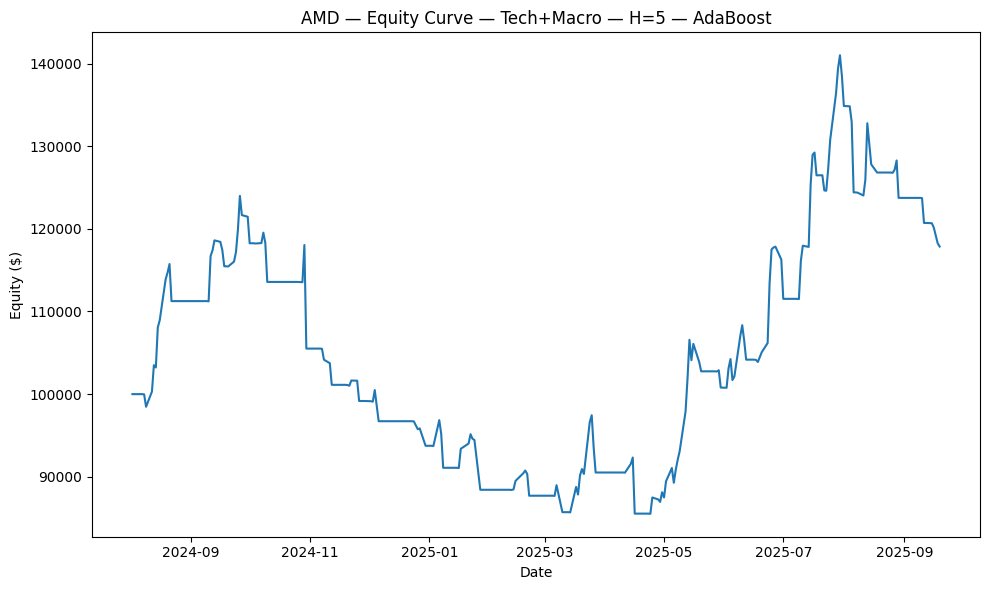

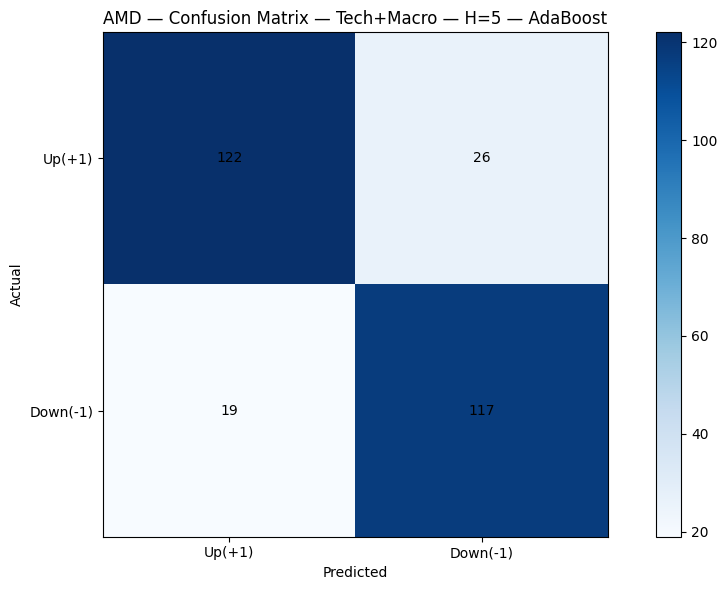

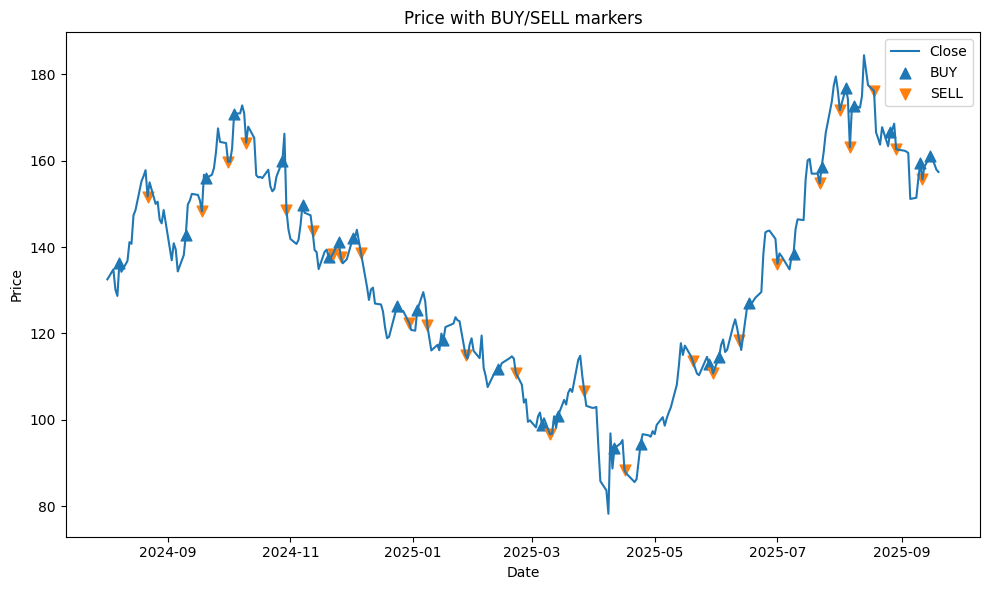

AMD — Trade log (first 25 rows) — Tech+Macro — H=5 — AdaBoost


Date   Close  Pred_Sign  Position Action           Cash      Shares  \
0  2024-08-02  132.50         -1         0   CASH  100000.000000    0.000000   
1  2024-08-05  134.82         -1         0   CASH  100000.000000    0.000000   
2  2024-08-06  130.18         -1         0   CASH  100000.000000    0.000000   
3  2024-08-07  128.67         -1         0   CASH  100000.000000    0.000000   
4  2024-08-08  136.32          1         1    BUY     -25.000000  733.568075   
5  2024-08-09  134.27          1         1   HOLD     -25.000000  733.568075   
6  2024-08-12  136.77          1         1   HOLD     -25.000000  733.568075   
7  2024-08-13  141.13          1         1   HOLD     -25.000000  733.568075   
8  2024-08-14  140.75          1         1   HOLD     -25.000000  733.568075   
9  2024-08-15  147.36          1         1   HOLD     -25.000000  733.568075   
10 2024-08-16  148.56          1         1   HOLD     -25.000000  733.568075   
11 2024-08-19  155.28          1         1   HOLD     -25.000000  733.568075   
12 2024-08-20  156.40          1         1   HOLD     -25.000000  733.568075   
13 2024-08-21  157.81          1         1   HOLD     -25.000000  733.568075   
14 2024-08-22  151.70         -1         0   SELL  111254.456426    0.000000   
15 2024-08-23  154.98         -1         0   CASH  111254.456426    0.000000   
16 2024-08-26  149.99         -1         0   CASH  111254.456426    0.000000   
17 2024-08-27  150.50         -1         0   CASH  111254.456426    0.000000   
18 2024-08-28  146.36         -1         0   CASH  111254.456426    0.000000   
19 2024-08-29  145.49         -1         0   CASH  111254.456426    0.000000   
20 2024-08-30  148.56         -1         0   CASH  111254.456426    0.000000   
21 2024-09-03  136.94         -1         0   CASH  111254.456426    0.000000   
22 2024-09-04  140.87         -1         0   CASH  111254.456426    0.000000   
23 2024-09-05  139.44         -1         0   CASH  111254.456426    0.000000   
24 2024-09-06  134.35         -1         0   CASH  111254.456426    0.000000   

           Equity  
0   100000.000000  
1   100000.000000  
2   100000.000000  
3   100000.000000  
4    99975.000000  
5    98471.185446  
6   100305.105634  
7   103503.462441  
8   103224.706573  
9   108073.591549  
10  108953.873239  
11  113883.450704  
12  114705.046948  
13  115739.377934  
14  111254.456426  
15  111254.456426  
16  111254.456426  
17  111254.456426  
18  111254.456426  
19  111254.456426  
20  111254.456426  
21  111254.456426  
22  111254.456426  
23  111254.456426  
24  111254.456426


Best Tech+Macro for AMD, H=10: CatBoost, Ann.Return=33.33%, ROI=38.47%


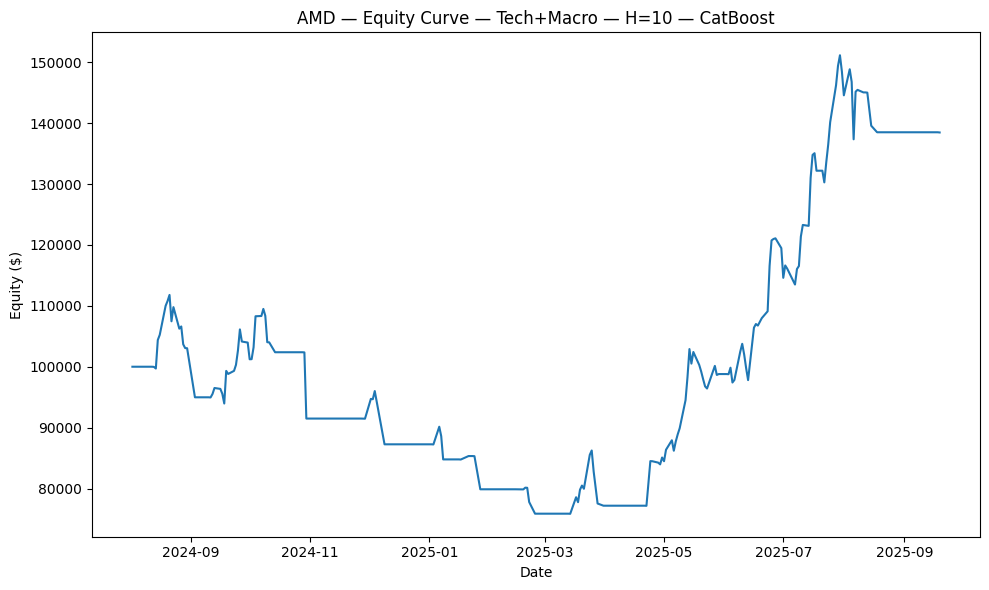

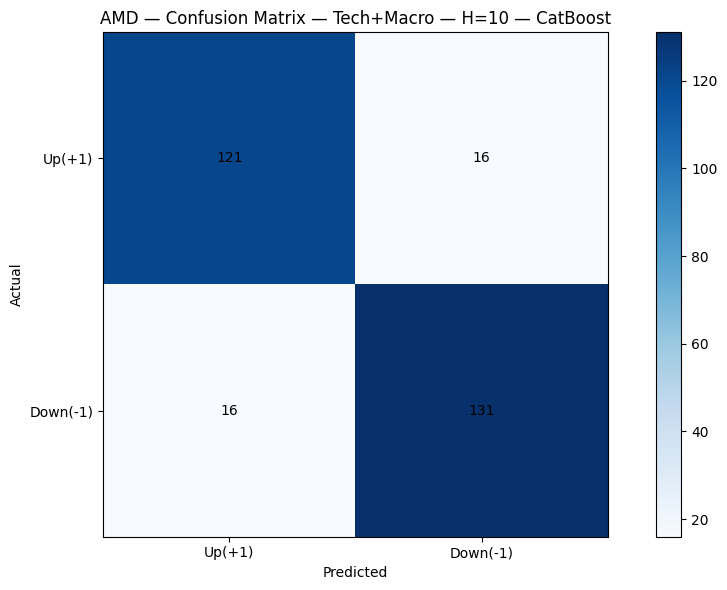

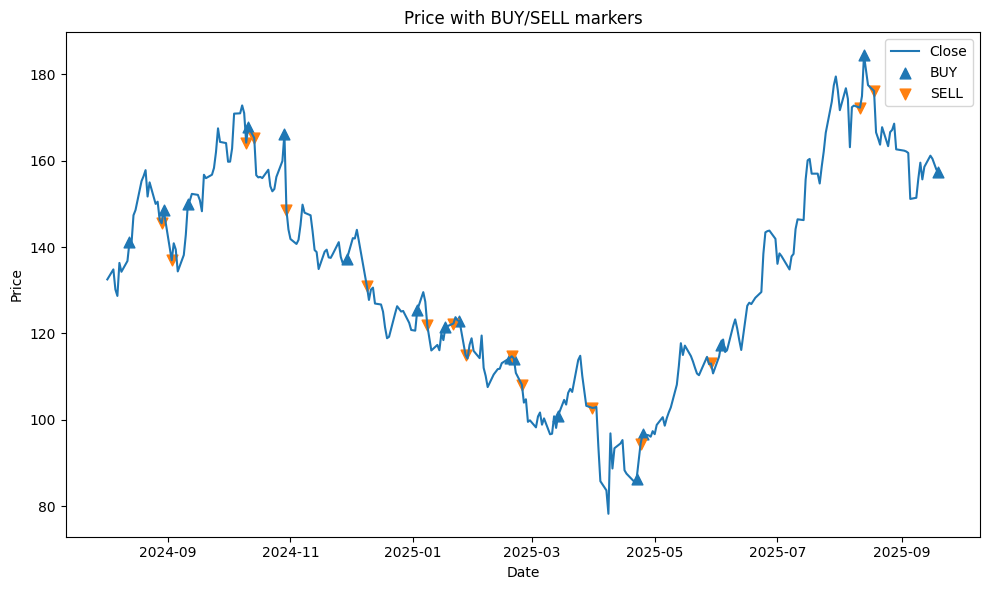

AMD — Trade log (first 25 rows) — Tech+Macro — H=10 — CatBoost


Date   Close  Pred_Sign  Position Action           Cash      Shares  \
0  2024-08-02  132.50         -1         0   CASH  100000.000000    0.000000   
1  2024-08-05  134.82         -1         0   CASH  100000.000000    0.000000   
2  2024-08-06  130.18         -1         0   CASH  100000.000000    0.000000   
3  2024-08-07  128.67         -1         0   CASH  100000.000000    0.000000   
4  2024-08-08  136.32         -1         0   CASH  100000.000000    0.000000   
5  2024-08-09  134.27         -1         0   CASH  100000.000000    0.000000   
6  2024-08-12  136.77         -1         0   CASH  100000.000000    0.000000   
7  2024-08-13  141.13          1         1    BUY     -25.000000  708.566570   
8  2024-08-14  140.75          1         1   HOLD     -25.000000  708.566570   
9  2024-08-15  147.36          1         1   HOLD     -25.000000  708.566570   
10 2024-08-16  148.56          1         1   HOLD     -25.000000  708.566570   
11 2024-08-19  155.28          1         1   HOLD     -25.000000  708.566570   
12 2024-08-20  156.40          1         1   HOLD     -25.000000  708.566570   
13 2024-08-21  157.81          1         1   HOLD     -25.000000  708.566570   
14 2024-08-22  151.70          1         1   HOLD     -25.000000  708.566570   
15 2024-08-23  154.98          1         1   HOLD     -25.000000  708.566570   
16 2024-08-26  149.99          1         1   HOLD     -25.000000  708.566570   
17 2024-08-27  150.50          1         1   HOLD     -25.000000  708.566570   
18 2024-08-28  146.36          1         1   HOLD     -25.000000  708.566570   
19 2024-08-29  145.49         -1         0   SELL  103063.577907    0.000000   
20 2024-08-30  148.56          1         1    BUY     -25.765894  693.750524   
21 2024-09-03  136.94         -1         0   SELL   94978.446264    0.000000   
22 2024-09-04  140.87         -1         0   CASH   94978.446264    0.000000   
23 2024-09-05  139.44         -1         0   CASH   94978.446264    0.000000   
24 2024-09-06  134.35         -1         0   CASH   94978.446264    0.000000   

           Equity  
0   100000.000000  
1   100000.000000  
2   100000.000000  
3   100000.000000  
4   100000.000000  
5   100000.000000  
6   100000.000000  
7    99975.000000  
8    99705.744703  
9   104389.369730  
10  105239.649614  
11  110001.216963  
12  110794.811521  
13  111793.890385  
14  107464.548643  
15  109788.646992  
16  106252.899809  
17  106614.268759  
18  103680.803160  
19  103063.577907  
20  103037.812012  
21   94978.446264  
22   94978.446264  
23   94978.446264  
24   94978.446264


Best Tech+Macro for AMD, H=20: SVM, Ann.Return=23.45%, ROI=26.92%


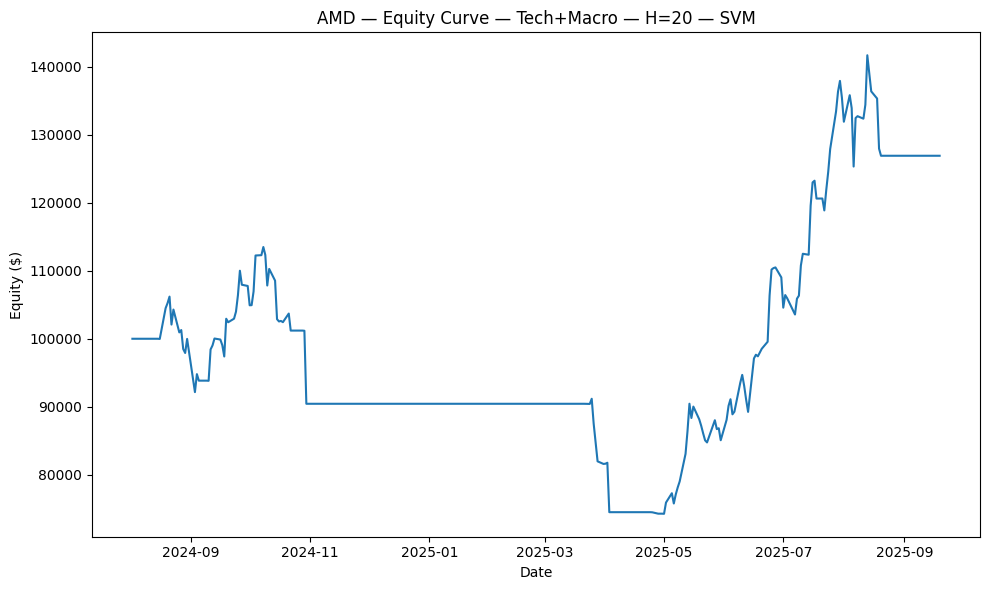

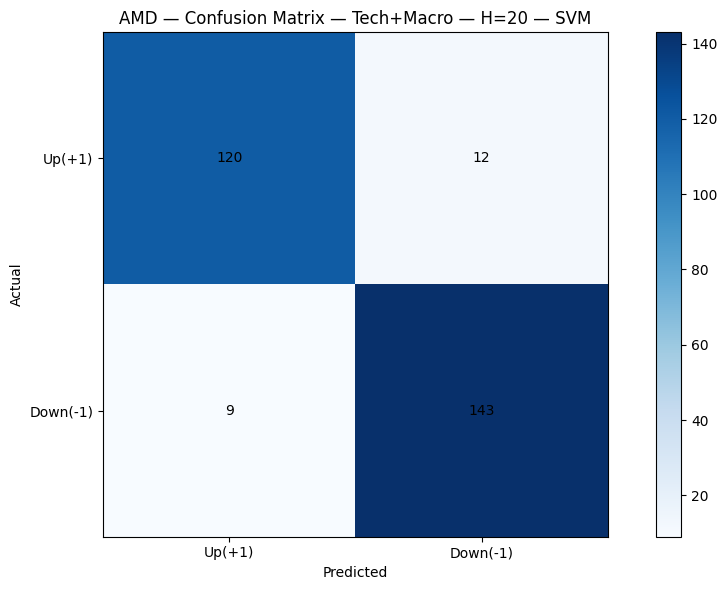

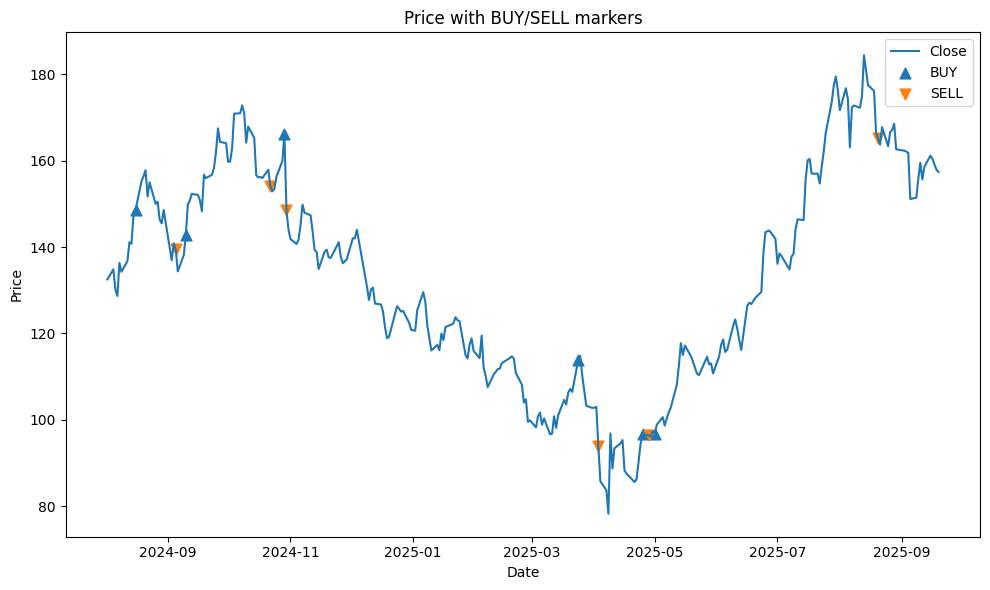

AMD — Trade log (first 25 rows) — Tech+Macro — H=20 — SVM


Date   Close  Pred_Sign  Position Action           Cash      Shares  \
0  2024-08-02  132.50         -1         0   CASH  100000.000000    0.000000   
1  2024-08-05  134.82         -1         0   CASH  100000.000000    0.000000   
2  2024-08-06  130.18         -1         0   CASH  100000.000000    0.000000   
3  2024-08-07  128.67         -1         0   CASH  100000.000000    0.000000   
4  2024-08-08  136.32         -1         0   CASH  100000.000000    0.000000   
5  2024-08-09  134.27         -1         0   CASH  100000.000000    0.000000   
6  2024-08-12  136.77         -1         0   CASH  100000.000000    0.000000   
7  2024-08-13  141.13         -1         0   CASH  100000.000000    0.000000   
8  2024-08-14  140.75         -1         0   CASH  100000.000000    0.000000   
9  2024-08-15  147.36         -1         0   CASH  100000.000000    0.000000   
10 2024-08-16  148.56          1         1    BUY     -25.000000  673.128702   
11 2024-08-19  155.28          1         1   HOLD     -25.000000  673.128702   
12 2024-08-20  156.40          1         1   HOLD     -25.000000  673.128702   
13 2024-08-21  157.81          1         1   HOLD     -25.000000  673.128702   
14 2024-08-22  151.70          1         1   HOLD     -25.000000  673.128702   
15 2024-08-23  154.98          1         1   HOLD     -25.000000  673.128702   
16 2024-08-26  149.99          1         1   HOLD     -25.000000  673.128702   
17 2024-08-27  150.50          1         1   HOLD     -25.000000  673.128702   
18 2024-08-28  146.36          1         1   HOLD     -25.000000  673.128702   
19 2024-08-29  145.49          1         1   HOLD     -25.000000  673.128702   
20 2024-08-30  148.56          1         1   HOLD     -25.000000  673.128702   
21 2024-09-03  136.94          1         1   HOLD     -25.000000  673.128702   
22 2024-09-04  140.87          1         1   HOLD     -25.000000  673.128702   
23 2024-09-05  139.44         -1         0   SELL   93837.600969    0.000000   
24 2024-09-06  134.35         -1         0   CASH   93837.600969    0.000000   

           Equity  
0   100000.000000  
1   100000.000000  
2   100000.000000  
3   100000.000000  
4   100000.000000  
5   100000.000000  
6   100000.000000  
7   100000.000000  
8   100000.000000  
9   100000.000000  
10   99975.000000  
11  104498.424879  
12  105252.329025  
13  106201.440495  
14  102088.624125  
15  104296.486268  
16  100937.574044  
17  101280.869682  
18   98494.116855  
19   97908.494884  
20   99975.000000  
21   92153.244480  
22   94798.640280  
23   93837.600969  
24   93837.600969

/tmp/ipython-input-1667154152.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


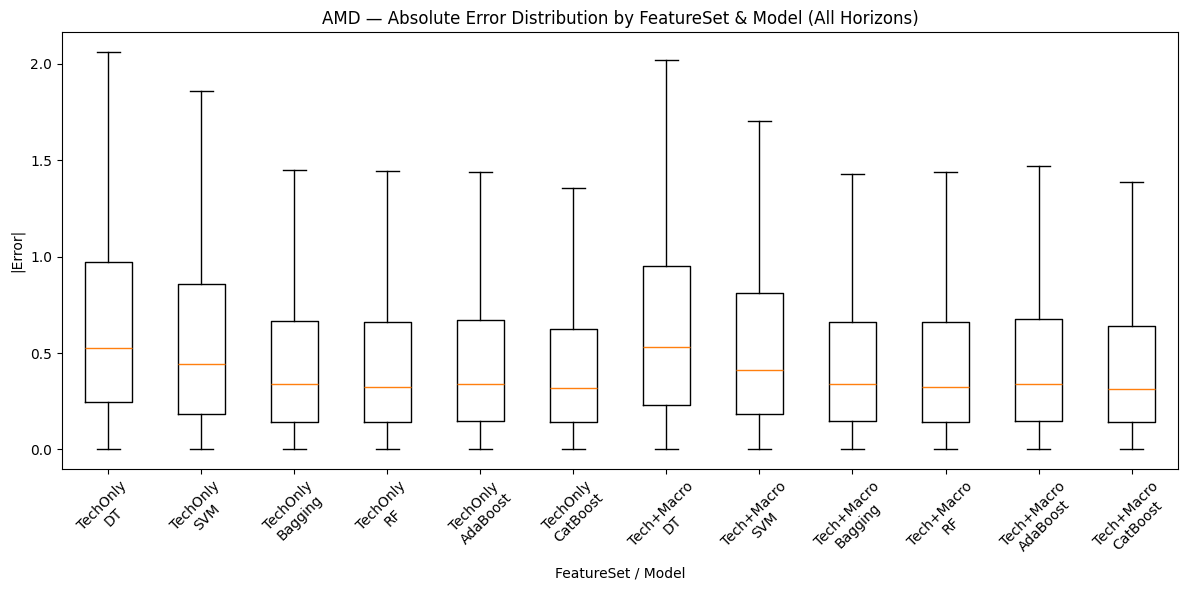

In [ ]:
res_AMD = run_for_stock("AMD")



==================== CRM ====================

Feature set: TechOnly  (#features = 38)
  H=5, Model=DT, FS=TechOnly done.
  H=5, Model=SVM, FS=TechOnly done.
  H=5, Model=Bagging, FS=TechOnly done.
  H=5, Model=RF, FS=TechOnly done.
  H=5, Model=AdaBoost, FS=TechOnly done.
  H=5, Model=CatBoost, FS=TechOnly done.
  H=10, Model=DT, FS=TechOnly done.
  H=10, Model=SVM, FS=TechOnly done.
  H=10, Model=Bagging, FS=TechOnly done.
  H=10, Model=RF, FS=TechOnly done.
  H=10, Model=AdaBoost, FS=TechOnly done.
  H=10, Model=CatBoost, FS=TechOnly done.
  H=20, Model=DT, FS=TechOnly done.
  H=20, Model=SVM, FS=TechOnly done.
  H=20, Model=Bagging, FS=TechOnly done.
  H=20, Model=RF, FS=TechOnly done.
  H=20, Model=AdaBoost, FS=TechOnly done.
  H=20, Model=CatBoost, FS=TechOnly done.

Feature set: Tech+Macro  (#features = 43)
  H=5, Model=DT, FS=Tech+Macro done.
  H=5, Model=SVM, FS=Tech+Macro done.
  H=5, Model=Bagging, FS=Tech+Macro done.
  H=5, Model=RF, FS=Tech+Macro done.
  H=5, Model=AdaBoo

Ticker  FeatureSet  Horizon     Model       MAE      RMSE  Accuracy  \
0     CRM  Tech+Macro        5  AdaBoost  1.241269  1.610973  0.841549   
1     CRM  Tech+Macro        5   Bagging  1.162469  1.512226  0.852113   
2     CRM  Tech+Macro        5  CatBoost  1.174561  1.568817  0.852113   
3     CRM  Tech+Macro        5        DT  1.622432  2.046618  0.795775   
4     CRM  Tech+Macro        5        RF  1.166839  1.508046  0.827465   
5     CRM  Tech+Macro        5       SVM  1.366215  1.849136  0.771127   
6     CRM  Tech+Macro       10  AdaBoost  0.662198  0.895360  0.901408   
7     CRM  Tech+Macro       10   Bagging  0.630806  0.859273  0.901408   
8     CRM  Tech+Macro       10  CatBoost  0.626747  0.846954  0.890845   
9     CRM  Tech+Macro       10        DT  1.025030  1.330175  0.693662   
10    CRM  Tech+Macro       10        RF  0.612387  0.842103  0.904930   
11    CRM  Tech+Macro       10       SVM  0.861825  1.151717  0.873239   
12    CRM  Tech+Macro       20  AdaBoost  0.355042  0.455732  0.880282   
13    CRM  Tech+Macro       20   Bagging  0.332214  0.431110  0.873239   
14    CRM  Tech+Macro       20  CatBoost  0.332820  0.425137  0.866197   
15    CRM  Tech+Macro       20        DT  0.514014  0.667921  0.802817   
16    CRM  Tech+Macro       20        RF  0.307666  0.406361  0.890845   
17    CRM  Tech+Macro       20       SVM  0.480470  0.627493  0.883803   
18    CRM    TechOnly        5  AdaBoost  1.239188  1.609193  0.841549   
19    CRM    TechOnly        5   Bagging  1.173313  1.519148  0.845070   
20    CRM    TechOnly        5  CatBoost  1.162138  1.562588  0.852113   
21    CRM    TechOnly        5        DT  1.730233  2.230406  0.750000   
22    CRM    TechOnly        5        RF  1.168350  1.509386  0.827465   
23    CRM    TechOnly        5       SVM  1.281036  1.788360  0.795775   
24    CRM    TechOnly       10  AdaBoost  0.657926  0.890454  0.897887   
25    CRM    TechOnly       10   Bagging  0.626317  0.851215  0.901408   
26    CRM    TechOnly       10  CatBoost  0.625834  0.854533  0.887324   
27    CRM    TechOnly       10        DT  0.917764  1.223876  0.799296   
28    CRM    TechOnly       10        RF  0.612003  0.842043  0.904930   
29    CRM    TechOnly       10       SVM  0.785333  1.071573  0.855634   
30    CRM    TechOnly       20  AdaBoost  0.356386  0.455112  0.883803   
31    CRM    TechOnly       20   Bagging  0.326613  0.425120  0.880282   
32    CRM    TechOnly       20  CatBoost  0.337242  0.432669  0.883803   
33    CRM    TechOnly       20        DT  0.573330  0.772707  0.788732   
34    CRM    TechOnly       20        RF  0.308507  0.409132  0.890845   
35    CRM    TechOnly       20       SVM  0.441751  0.588913  0.869718   

    Precision    Recall        F1  TotalReturn_%      ROI_%  \
0    0.821656  0.883562  0.851485       6.491094   6.491094   
1    0.851351  0.863014  0.857143      13.508060  13.508060   
2    0.851351  0.863014  0.857143      13.268517  13.268517   
3    0.814286  0.780822  0.797203       8.447727   8.447727   
4    0.808917  0.869863  0.838284       8.487778   8.487778   
5    0.871560  0.650685  0.745098      20.634122  20.634122   
6    0.851351  0.954545  0.900000      23.546003  23.546003   
7    0.866197  0.931818  0.897810      22.105556  22.105556   
8    0.874074  0.893939  0.883895      10.980022  10.980022   
9    0.634731  0.803030  0.709030       0.158324   0.158324   
10   0.862069  0.946970  0.902527      22.767083  22.767083   
11   0.906780  0.810606  0.856000      33.680015  33.680015   
12   0.914729  0.836879  0.874074      -9.000080  -9.000080   
13   0.877698  0.865248  0.871429      -0.598140  -0.598140   
14   0.865248  0.865248  0.865248       1.731199   1.731199   
15   0.793103  0.815603  0.804196       1.925062   1.925062   
16   0.852564  0.943262  0.895623      -0.060186  -0.060186   
17   0.957627  0.801418  0.872587       3.490230   3.490230   
18   0.821656  0.883562  0.851485       6.491094   6.491094   
19  


Average performance by FeatureSet & Horizon:


MAE    RMSE  Accuracy      F1    ROI_%  \
FeatureSet Horizon                                              
Tech+Macro 5        1.2890  1.6826    0.8234  0.8244  11.8062   
           10       0.7365  0.9876    0.8609  0.8582  18.8728   
           20       0.3870  0.5023    0.8662  0.8639  -0.4187   
TechOnly   5        1.2924  1.7032    0.8187  0.8239  15.0348   
           10       0.7042  0.9556    0.8744  0.8680  17.8338   
           20       0.3906  0.5139    0.8662  0.8622  -1.3261   

                    AnnualizedReturn_%  MaxDrawdown_%  
FeatureSet Horizon                                     
Tech+Macro 5                   10.3555       -19.0314  
           10                  16.4592       -18.2845  
           20                  -0.3788       -25.4529  
TechOnly   5                   13.1453       -17.7088  
           10                  15.5853       -18.2022  
           20                  -1.1830       -25.4771


Average performance by FeatureSet (all horizons & models):


MAE    RMSE  Accuracy      F1    ROI_%  AnnualizedReturn_%  \
FeatureSet                                                                  
Tech+Macro  0.8042  1.0575    0.8502  0.8488  10.0868              8.8120   
TechOnly    0.7957  1.0576    0.8531  0.8514  10.5142              9.1826   

            MaxDrawdown_%  
FeatureSet                 
Tech+Macro       -20.9229  
TechOnly         -20.4627

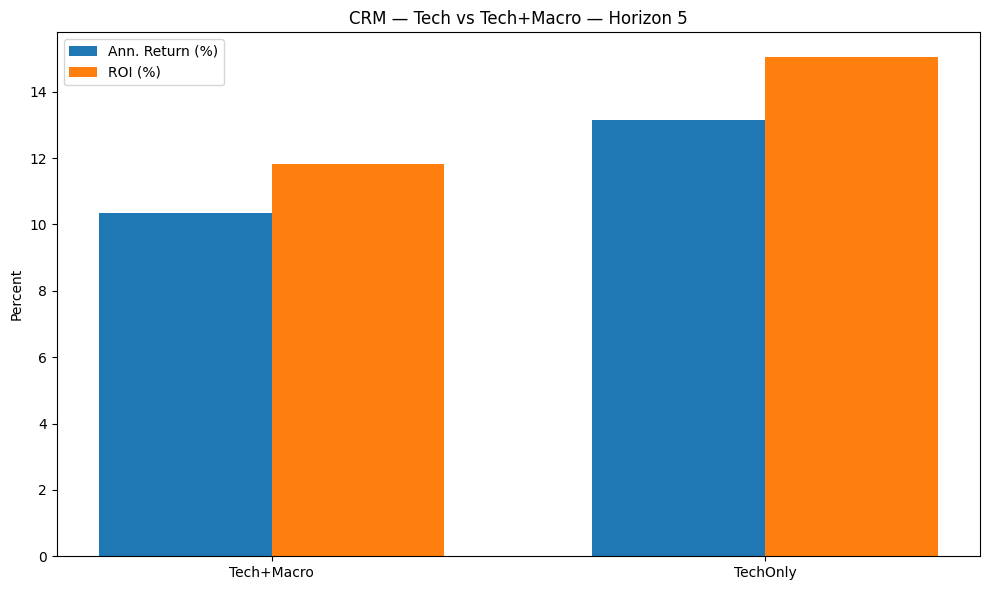

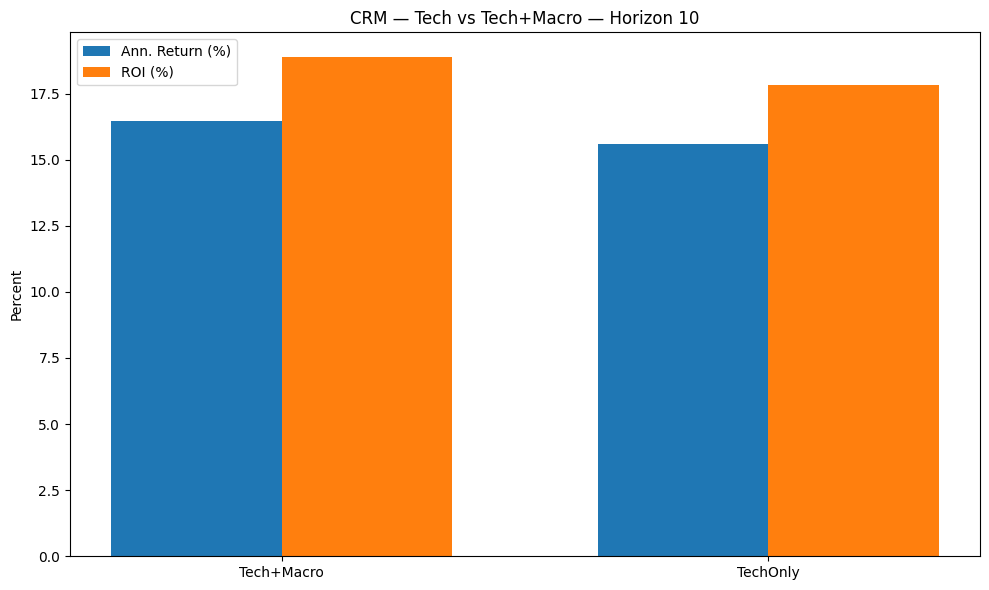

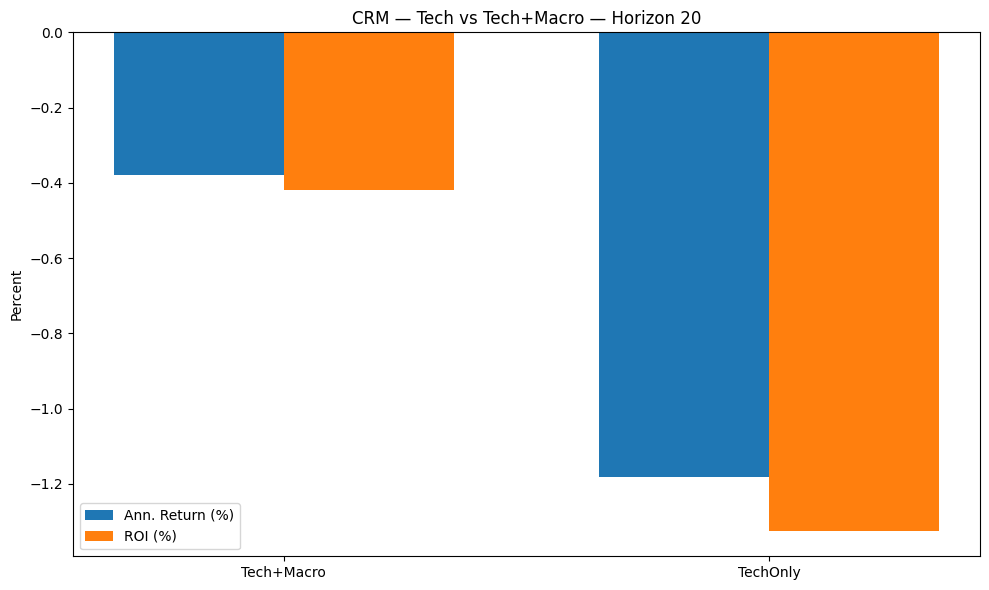

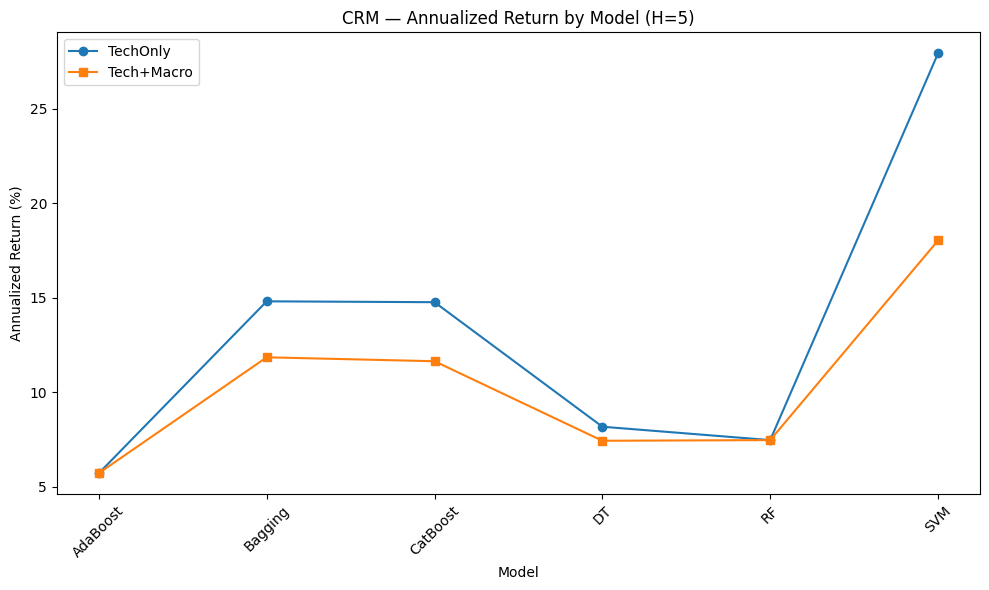

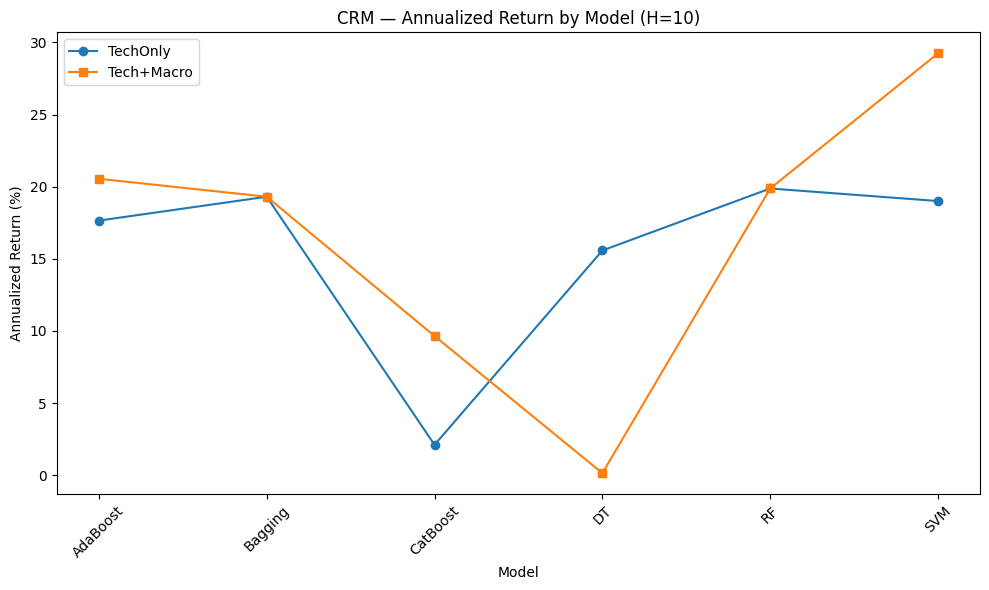

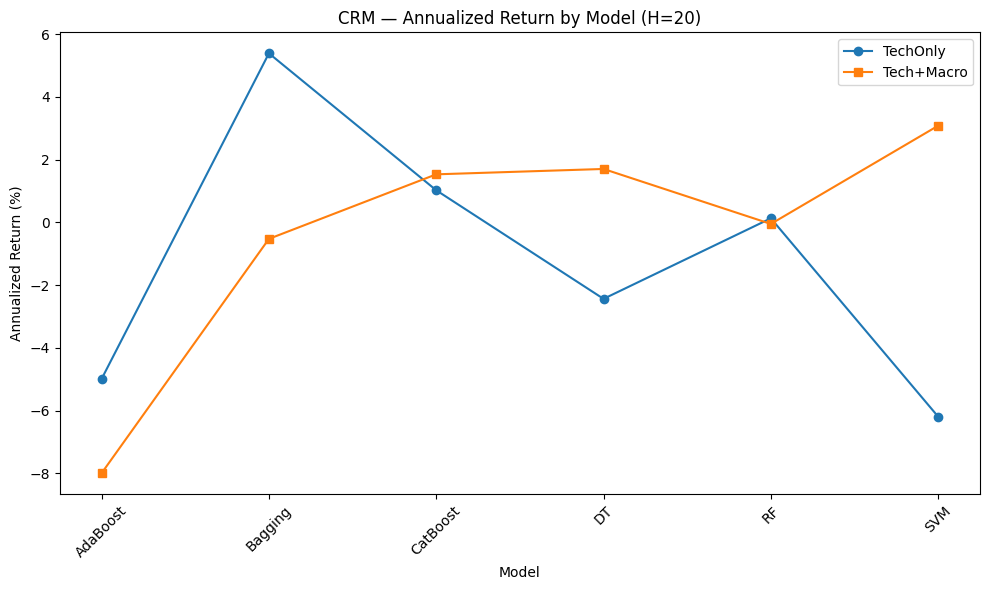


Best Tech+Macro for CRM, H=5: SVM, Ann.Return=18.03%, ROI=20.63%


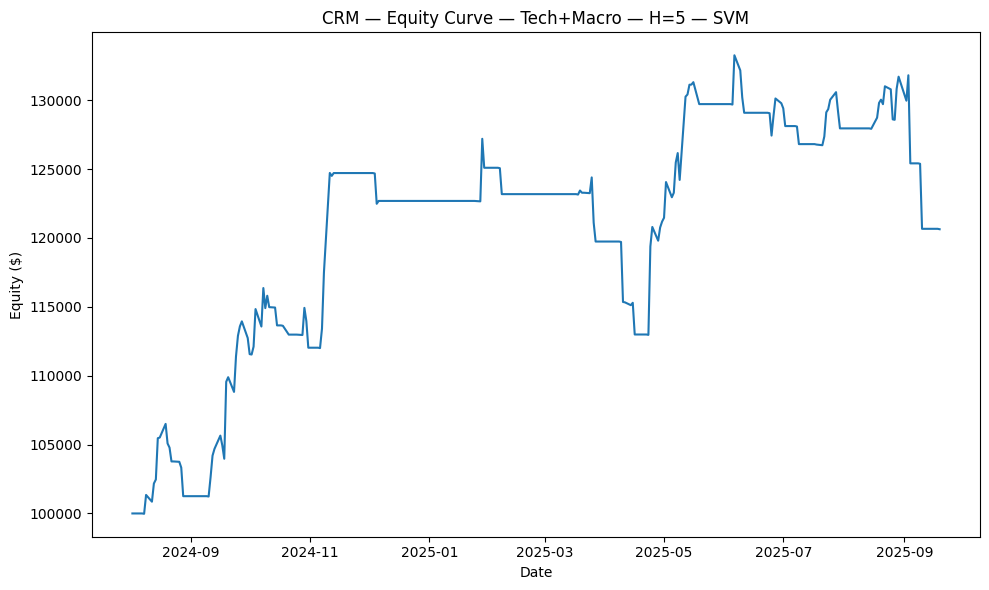

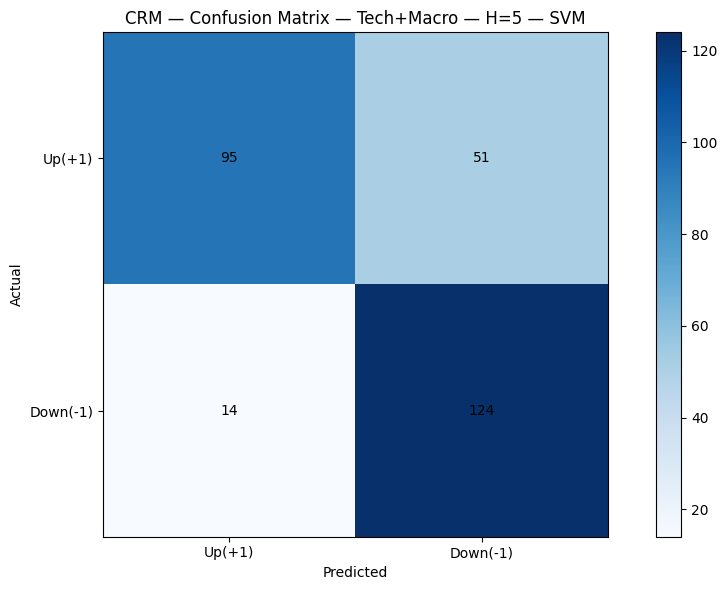

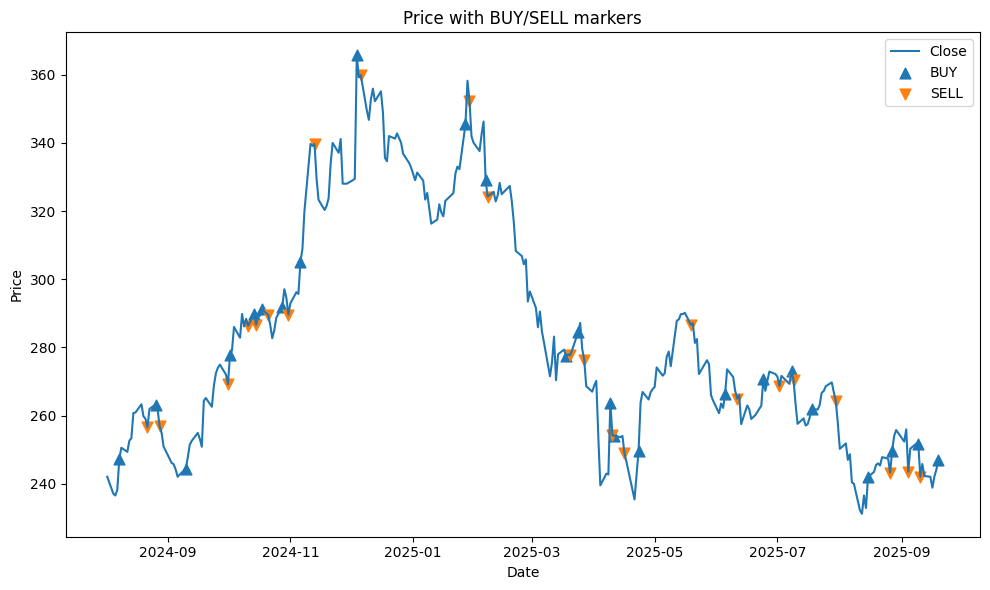

CRM — Trade log (first 25 rows) — Tech+Macro — H=5 — SVM


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  242.12204         -1         0   CASH  100000.000000   
1  2024-08-05  237.19960         -1         0   CASH  100000.000000   
2  2024-08-06  236.61409         -1         0   CASH  100000.000000   
3  2024-08-07  238.22180         -1         0   CASH  100000.000000   
4  2024-08-08  247.23303          1         1    BUY     -25.000000   
5  2024-08-09  250.61720          1         1   HOLD     -25.000000   
6  2024-08-12  249.40643          1         1   HOLD     -25.000000   
7  2024-08-13  252.67154          1         1   HOLD     -25.000000   
8  2024-08-14  253.38610          1         1   HOLD     -25.000000   
9  2024-08-15  260.79950          1         1   HOLD     -25.000000   
10 2024-08-16  260.91855          1         1   HOLD     -25.000000   
11 2024-08-19  263.36987          1         1   HOLD     -25.000000   
12 2024-08-20  259.85666          1         1   HOLD     -25.000000   
13 2024-08-21  259.11237          1         1   HOLD     -25.000000   
14 2024-08-22  256.63132         -1         0   SELL  103775.438974   
15 2024-08-23  262.00030         -1         0   CASH  103775.438974   
16 2024-08-26  263.27063          1         1    BUY     -25.943860   
17 2024-08-27  262.19880          1         1   HOLD     -25.943860   
18 2024-08-28  256.93893         -1         0   SELL  101254.303462   
19 2024-08-29  255.06328         -1         0   CASH  101254.303462   
20 2024-08-30  250.98440         -1         0   CASH  101254.303462   
21 2024-09-03  246.18106         -1         0   CASH  101254.303462   
22 2024-09-04  245.80392         -1         0   CASH  101254.303462   
23 2024-09-05  244.25574         -1         0   CASH  101254.303462   
24 2024-09-06  242.12204         -1         0   CASH  101254.303462   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4   404.476700   99975.000000  
5   404.476700  101343.817912  
6   404.476700  100854.089659  
7   404.476700  102174.750575  
8   404.476700  102463.773446  
9   404.476700  105462.321010  
10  404.476700  105510.473962  
11  404.476700  106501.975785  
12  404.476700  105080.964199  
13  404.476700  104779.916236  
14    0.000000  103775.438974  
15    0.000000  103775.438974  
16  394.177805  103749.495114  
17  394.177805  103327.003517  
18    0.000000  101254.303462  
19    0.000000  101254.303462  
20    0.000000  101254.303462  
21    0.000000  101254.303462  
22    0.000000  101254.303462  
23    0.000000  101254.303462  
24    0.000000  101254.303462


Best Tech+Macro for CRM, H=10: SVM, Ann.Return=29.25%, ROI=33.68%


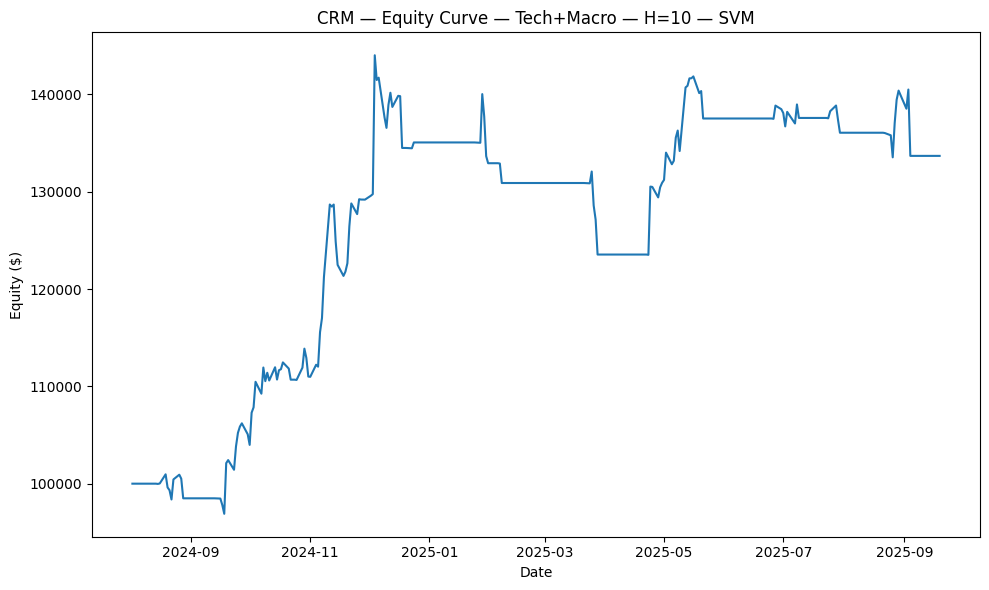

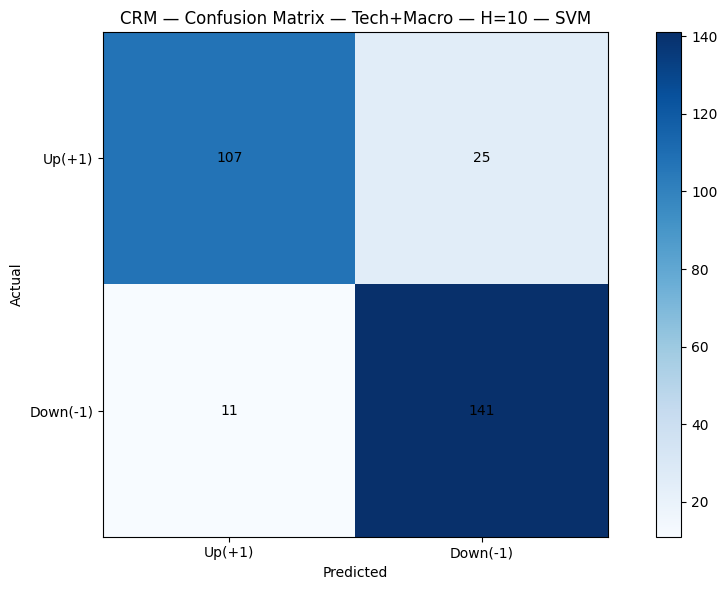

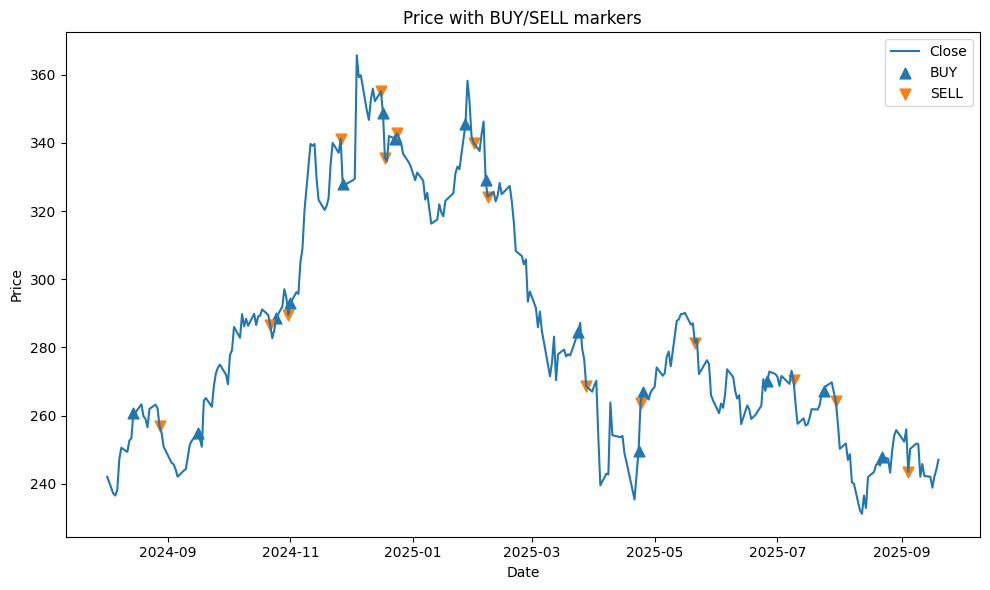

CRM — Trade log (first 25 rows) — Tech+Macro — H=10 — SVM


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  242.12204         -1         0   CASH  100000.000000   
1  2024-08-05  237.19960         -1         0   CASH  100000.000000   
2  2024-08-06  236.61409         -1         0   CASH  100000.000000   
3  2024-08-07  238.22180         -1         0   CASH  100000.000000   
4  2024-08-08  247.23303         -1         0   CASH  100000.000000   
5  2024-08-09  250.61720         -1         0   CASH  100000.000000   
6  2024-08-12  249.40643         -1         0   CASH  100000.000000   
7  2024-08-13  252.67154         -1         0   CASH  100000.000000   
8  2024-08-14  253.38610         -1         0   CASH  100000.000000   
9  2024-08-15  260.79950          1         1    BUY     -25.000000   
10 2024-08-16  260.91855          1         1   HOLD     -25.000000   
11 2024-08-19  263.36987          1         1   HOLD     -25.000000   
12 2024-08-20  259.85666          1         1   HOLD     -25.000000   
13 2024-08-21  259.11237          1         1   HOLD     -25.000000   
14 2024-08-22  256.63132          1         1   HOLD     -25.000000   
15 2024-08-23  262.00030          1         1   HOLD     -25.000000   
16 2024-08-26  263.27063          1         1   HOLD     -25.000000   
17 2024-08-27  262.19880          1         1   HOLD     -25.000000   
18 2024-08-28  256.93893         -1         0   SELL   98495.087325   
19 2024-08-29  255.06328         -1         0   CASH   98495.087325   
20 2024-08-30  250.98440         -1         0   CASH   98495.087325   
21 2024-09-03  246.18106         -1         0   CASH   98495.087325   
22 2024-09-04  245.80392         -1         0   CASH   98495.087325   
23 2024-09-05  244.25574         -1         0   CASH   98495.087325   
24 2024-09-06  242.12204         -1         0   CASH   98495.087325   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4     0.000000  100000.000000  
5     0.000000  100000.000000  
6     0.000000  100000.000000  
7     0.000000  100000.000000  
8     0.000000  100000.000000  
9   383.436318   99975.000000  
10  383.436318  100020.648094  
11  383.436318  100960.573209  
12  383.436318   99613.480902  
13  383.436318   99328.093085  
14  383.436318   98376.768408  
15  383.436318  100435.430331  
16  383.436318  100922.520988  
17  383.436318  100511.542440  
18    0.000000   98495.087325  
19    0.000000   98495.087325  
20    0.000000   98495.087325  
21    0.000000   98495.087325  
22    0.000000   98495.087325  
23    0.000000   98495.087325  
24    0.000000   98495.087325


Best Tech+Macro for CRM, H=20: SVM, Ann.Return=3.08%, ROI=3.49%


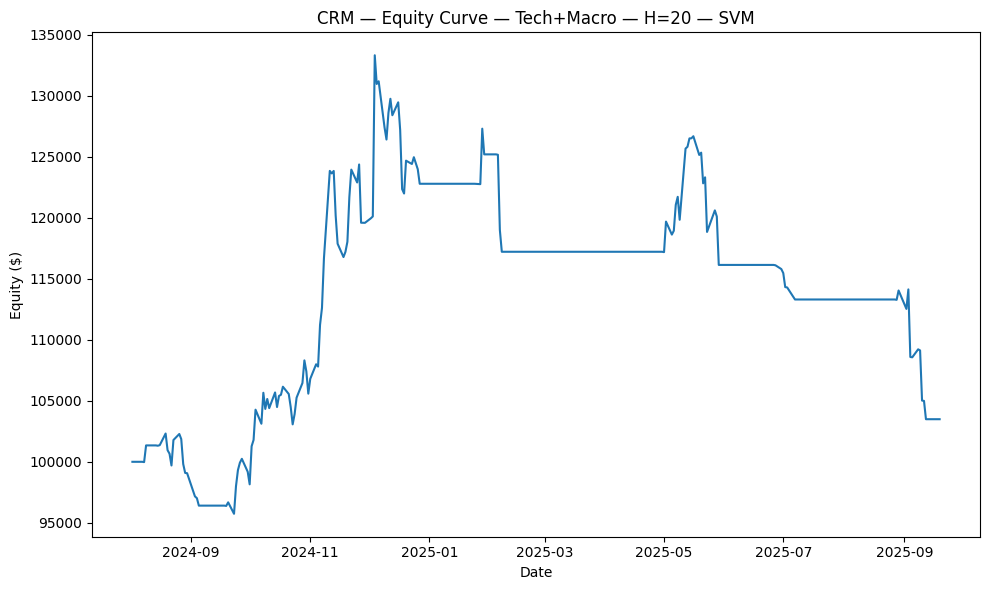

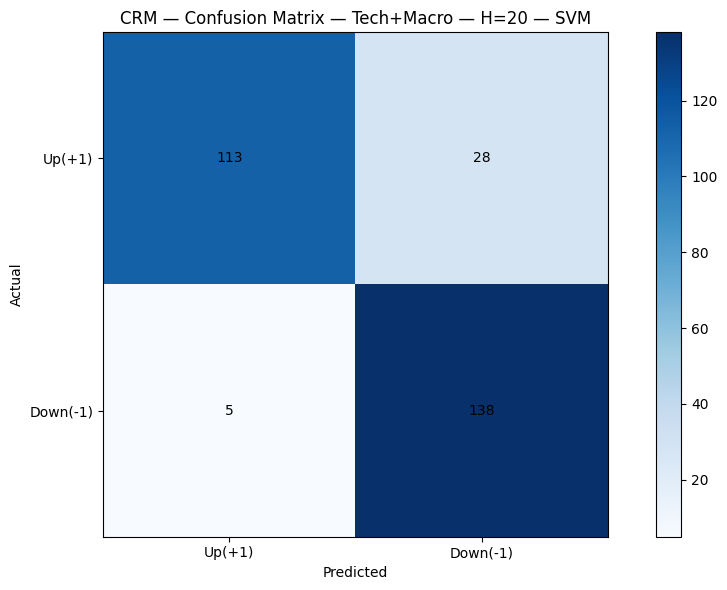

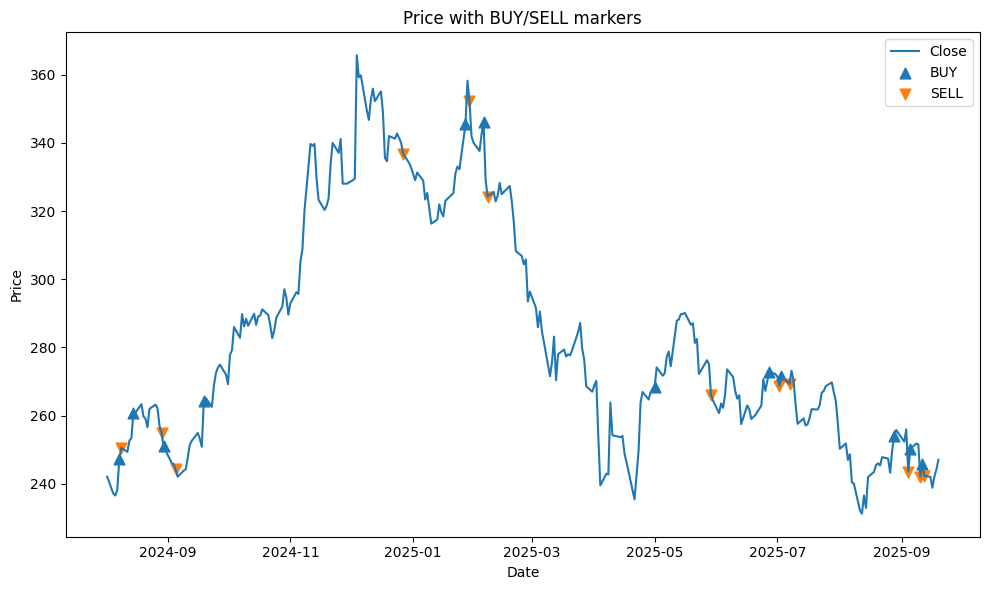

CRM — Trade log (first 25 rows) — Tech+Macro — H=20 — SVM


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  242.12204         -1         0   CASH  100000.000000   
1  2024-08-05  237.19960         -1         0   CASH  100000.000000   
2  2024-08-06  236.61409         -1         0   CASH  100000.000000   
3  2024-08-07  238.22180         -1         0   CASH  100000.000000   
4  2024-08-08  247.23303          1         1    BUY     -25.000000   
5  2024-08-09  250.61720         -1         0   SELL  101343.475708   
6  2024-08-12  249.40643         -1         0   CASH  101343.475708   
7  2024-08-13  252.67154         -1         0   CASH  101343.475708   
8  2024-08-14  253.38610         -1         0   CASH  101343.475708   
9  2024-08-15  260.79950          1         1    BUY     -25.335869   
10 2024-08-16  260.91855          1         1   HOLD     -25.335869   
11 2024-08-19  263.36987          1         1   HOLD     -25.335869   
12 2024-08-20  259.85666          1         1   HOLD     -25.335869   
13 2024-08-21  259.11237          1         1   HOLD     -25.335869   
14 2024-08-22  256.63132          1         1   HOLD     -25.335869   
15 2024-08-23  262.00030          1         1   HOLD     -25.335869   
16 2024-08-26  263.27063          1         1   HOLD     -25.335869   
17 2024-08-27  262.19880          1         1   HOLD     -25.335869   
18 2024-08-28  256.93893          1         1   HOLD     -25.335869   
19 2024-08-29  255.06328         -1         0   SELL   99089.672606   
20 2024-08-30  250.98440          1         1    BUY     -24.772418   
21 2024-09-03  246.18106          1         1   HOLD     -24.772418   
22 2024-09-04  245.80392          1         1   HOLD     -24.772418   
23 2024-09-05  244.25574         -1         0   SELL   96409.061692   
24 2024-09-06  242.12204         -1         0   CASH   96409.061692   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4   404.476700   99975.000000  
5     0.000000  101343.475708  
6     0.000000  101343.475708  
7     0.000000  101343.475708  
8     0.000000  101343.475708  
9   388.587692  101318.139839  
10  388.587692  101364.401204  
11  388.587692  102316.953984  
12  388.587692  100951.763820  
13  388.587692  100662.541887  
14  388.587692   99698.436394  
15  388.587692  101784.755939  
16  388.587692  102278.390542  
17  388.587692  101861.890596  
18  388.587692   99817.969854  
19    0.000000   99089.672606  
20  394.804110   99064.900188  
21  394.804110   97168.521815  
22  394.804110   97019.625393  
23    0.000000   96409.061692  
24    0.000000   96409.061692

/tmp/ipython-input-1667154152.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


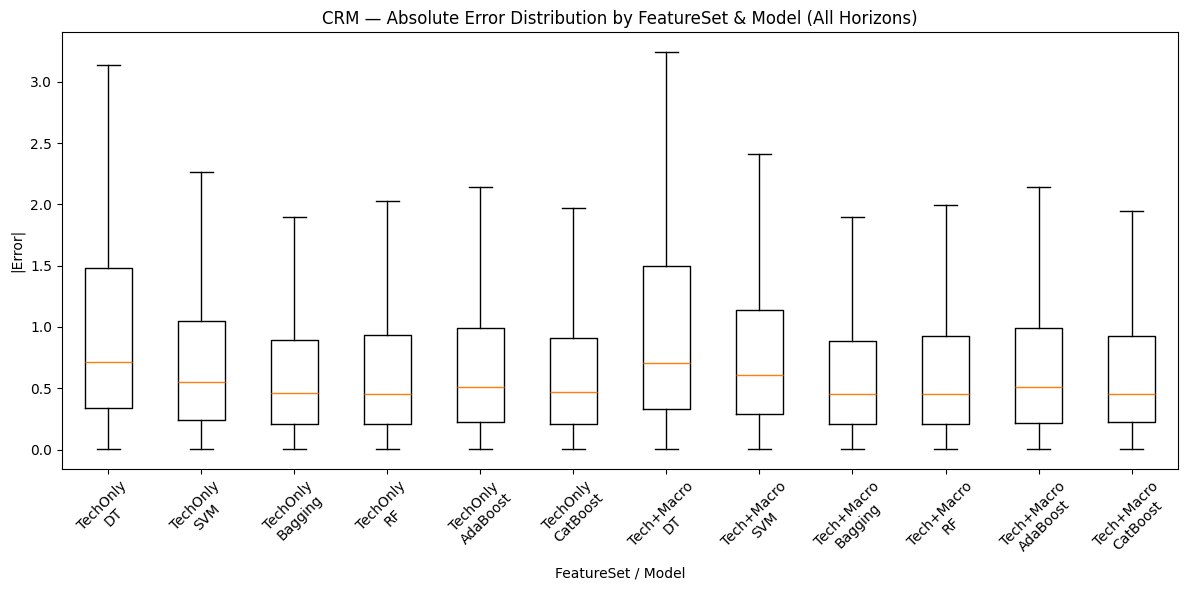

In [ ]:
res_CRM = run_for_stock("CRM")



==================== CRM ====================

Feature set: TechOnly  (#features = 38)
  H=5, Model=DT, FS=TechOnly done.
  H=5, Model=SVM, FS=TechOnly done.
  H=5, Model=Bagging, FS=TechOnly done.
  H=5, Model=RF, FS=TechOnly done.
  H=5, Model=AdaBoost, FS=TechOnly done.
  H=5, Model=CatBoost, FS=TechOnly done.
  H=10, Model=DT, FS=TechOnly done.
  H=10, Model=SVM, FS=TechOnly done.
  H=10, Model=Bagging, FS=TechOnly done.
  H=10, Model=RF, FS=TechOnly done.
  H=10, Model=AdaBoost, FS=TechOnly done.
  H=10, Model=CatBoost, FS=TechOnly done.
  H=20, Model=DT, FS=TechOnly done.
  H=20, Model=SVM, FS=TechOnly done.
  H=20, Model=Bagging, FS=TechOnly done.
  H=20, Model=RF, FS=TechOnly done.
  H=20, Model=AdaBoost, FS=TechOnly done.
  H=20, Model=CatBoost, FS=TechOnly done.

Feature set: Tech+Macro  (#features = 43)
  H=5, Model=DT, FS=Tech+Macro done.
  H=5, Model=SVM, FS=Tech+Macro done.
  H=5, Model=Bagging, FS=Tech+Macro done.
  H=5, Model=RF, FS=Tech+Macro done.
  H=5, Model=AdaBoo

Ticker  FeatureSet  Horizon     Model       MAE      RMSE  Accuracy  \
0     CRM  Tech+Macro        5  AdaBoost  1.241269  1.610973  0.841549   
1     CRM  Tech+Macro        5   Bagging  1.162469  1.512226  0.852113   
2     CRM  Tech+Macro        5  CatBoost  1.174561  1.568817  0.852113   
3     CRM  Tech+Macro        5        DT  1.622432  2.046618  0.795775   
4     CRM  Tech+Macro        5        RF  1.166839  1.508046  0.827465   
5     CRM  Tech+Macro        5       SVM  1.366215  1.849136  0.771127   
6     CRM  Tech+Macro       10  AdaBoost  0.662198  0.895360  0.901408   
7     CRM  Tech+Macro       10   Bagging  0.630806  0.859273  0.901408   
8     CRM  Tech+Macro       10  CatBoost  0.626747  0.846954  0.890845   
9     CRM  Tech+Macro       10        DT  1.025030  1.330175  0.693662   
10    CRM  Tech+Macro       10        RF  0.612387  0.842103  0.904930   
11    CRM  Tech+Macro       10       SVM  0.861825  1.151717  0.873239   
12    CRM  Tech+Macro       20  AdaBoost  0.355042  0.455732  0.880282   
13    CRM  Tech+Macro       20   Bagging  0.332214  0.431110  0.873239   
14    CRM  Tech+Macro       20  CatBoost  0.332820  0.425137  0.866197   
15    CRM  Tech+Macro       20        DT  0.514014  0.667921  0.802817   
16    CRM  Tech+Macro       20        RF  0.307666  0.406361  0.890845   
17    CRM  Tech+Macro       20       SVM  0.480470  0.627493  0.883803   
18    CRM    TechOnly        5  AdaBoost  1.239188  1.609193  0.841549   
19    CRM    TechOnly        5   Bagging  1.173313  1.519148  0.845070   
20    CRM    TechOnly        5  CatBoost  1.162138  1.562588  0.852113   
21    CRM    TechOnly        5        DT  1.730233  2.230406  0.750000   
22    CRM    TechOnly        5        RF  1.168350  1.509386  0.827465   
23    CRM    TechOnly        5       SVM  1.281036  1.788360  0.795775   
24    CRM    TechOnly       10  AdaBoost  0.657926  0.890454  0.897887   
25    CRM    TechOnly       10   Bagging  0.626317  0.851215  0.901408   
26    CRM    TechOnly       10  CatBoost  0.625834  0.854533  0.887324   
27    CRM    TechOnly       10        DT  0.917764  1.223876  0.799296   
28    CRM    TechOnly       10        RF  0.612003  0.842043  0.904930   
29    CRM    TechOnly       10       SVM  0.785333  1.071573  0.855634   
30    CRM    TechOnly       20  AdaBoost  0.356386  0.455112  0.883803   
31    CRM    TechOnly       20   Bagging  0.326613  0.425120  0.880282   
32    CRM    TechOnly       20  CatBoost  0.337242  0.432669  0.883803   
33    CRM    TechOnly       20        DT  0.573330  0.772707  0.788732   
34    CRM    TechOnly       20        RF  0.308507  0.409132  0.890845   
35    CRM    TechOnly       20       SVM  0.441751  0.588913  0.869718   

    Precision    Recall        F1  TotalReturn_%      ROI_%  \
0    0.821656  0.883562  0.851485       6.491094   6.491094   
1    0.851351  0.863014  0.857143      13.508060  13.508060   
2    0.851351  0.863014  0.857143      13.268517  13.268517   
3    0.814286  0.780822  0.797203       8.447727   8.447727   
4    0.808917  0.869863  0.838284       8.487778   8.487778   
5    0.871560  0.650685  0.745098      20.634122  20.634122   
6    0.851351  0.954545  0.900000      23.546003  23.546003   
7    0.866197  0.931818  0.897810      22.105556  22.105556   
8    0.874074  0.893939  0.883895      10.980022  10.980022   
9    0.634731  0.803030  0.709030       0.158324   0.158324   
10   0.862069  0.946970  0.902527      22.767083  22.767083   
11   0.906780  0.810606  0.856000      33.680015  33.680015   
12   0.914729  0.836879  0.874074      -9.000080  -9.000080   
13   0.877698  0.865248  0.871429      -0.598140  -0.598140   
14   0.865248  0.865248  0.865248       1.731199   1.731199   
15   0.793103  0.815603  0.804196       1.925062   1.925062   
16   0.852564  0.943262  0.895623      -0.060186  -0.060186   
17   0.957627  0.801418  0.872587       3.490230   3.490230   
18   0.821656  0.883562  0.851485       6.491094   6.491094   
19  


Average performance by FeatureSet & Horizon:


MAE    RMSE  Accuracy      F1    ROI_%  \
FeatureSet Horizon                                              
Tech+Macro 5        1.2890  1.6826    0.8234  0.8244  11.8062   
           10       0.7365  0.9876    0.8609  0.8582  18.8728   
           20       0.3870  0.5023    0.8662  0.8639  -0.4187   
TechOnly   5        1.2924  1.7032    0.8187  0.8239  15.0348   
           10       0.7042  0.9556    0.8744  0.8680  17.8338   
           20       0.3906  0.5139    0.8662  0.8622  -1.3261   

                    AnnualizedReturn_%  MaxDrawdown_%  
FeatureSet Horizon                                     
Tech+Macro 5                   10.3555       -19.0314  
           10                  16.4592       -18.2845  
           20                  -0.3788       -25.4529  
TechOnly   5                   13.1453       -17.7088  
           10                  15.5853       -18.2022  
           20                  -1.1830       -25.4771


Average performance by FeatureSet (all horizons & models):


MAE    RMSE  Accuracy      F1    ROI_%  AnnualizedReturn_%  \
FeatureSet                                                                  
Tech+Macro  0.8042  1.0575    0.8502  0.8488  10.0868              8.8120   
TechOnly    0.7957  1.0576    0.8531  0.8514  10.5142              9.1826   

            MaxDrawdown_%  
FeatureSet                 
Tech+Macro       -20.9229  
TechOnly         -20.4627

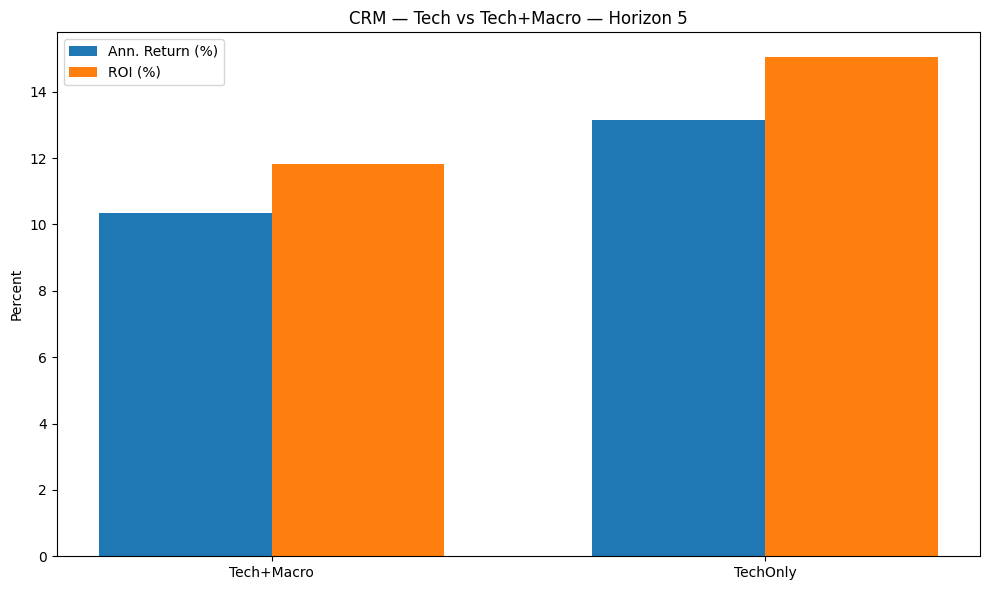

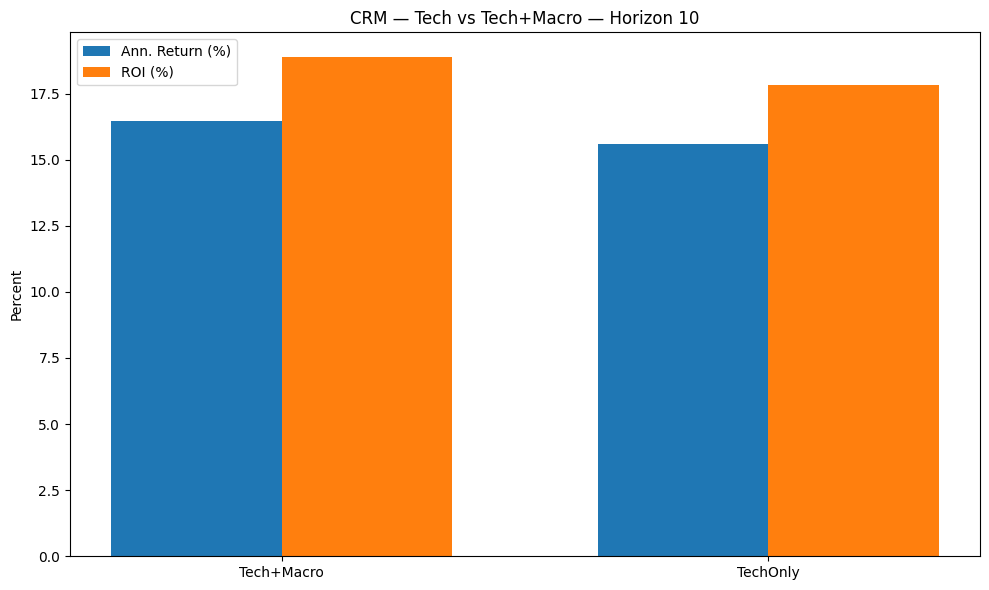

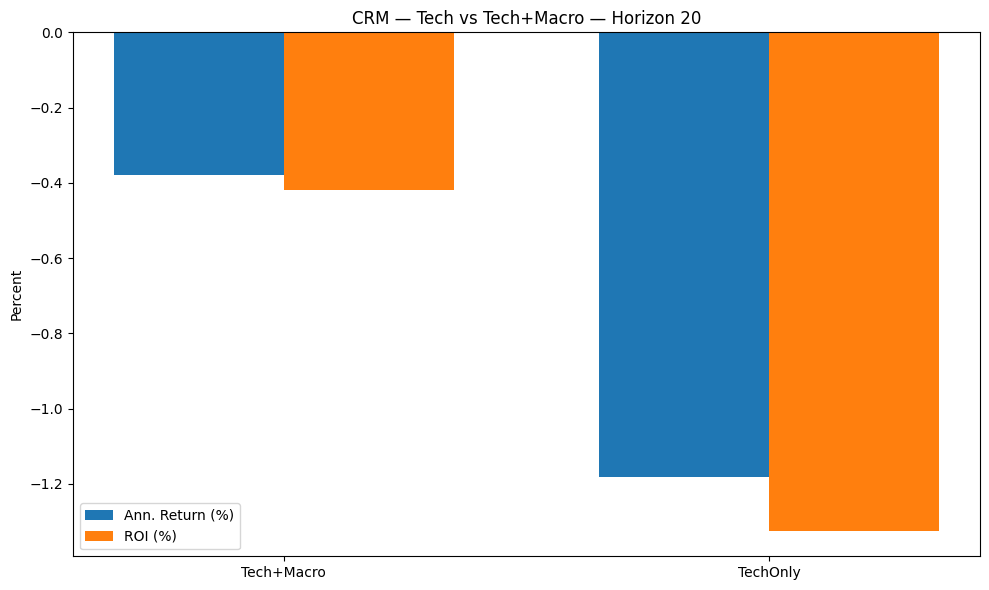

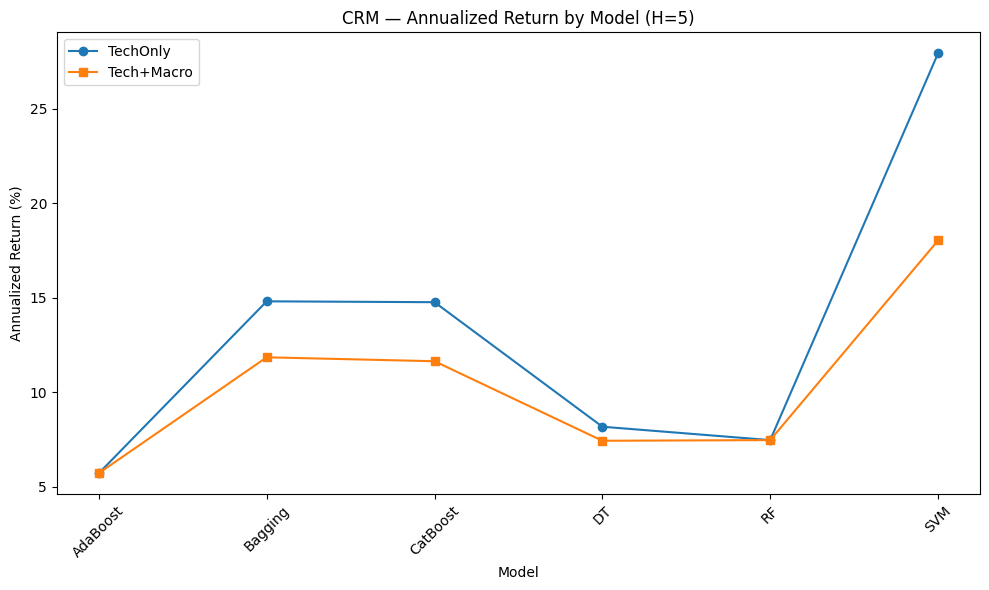

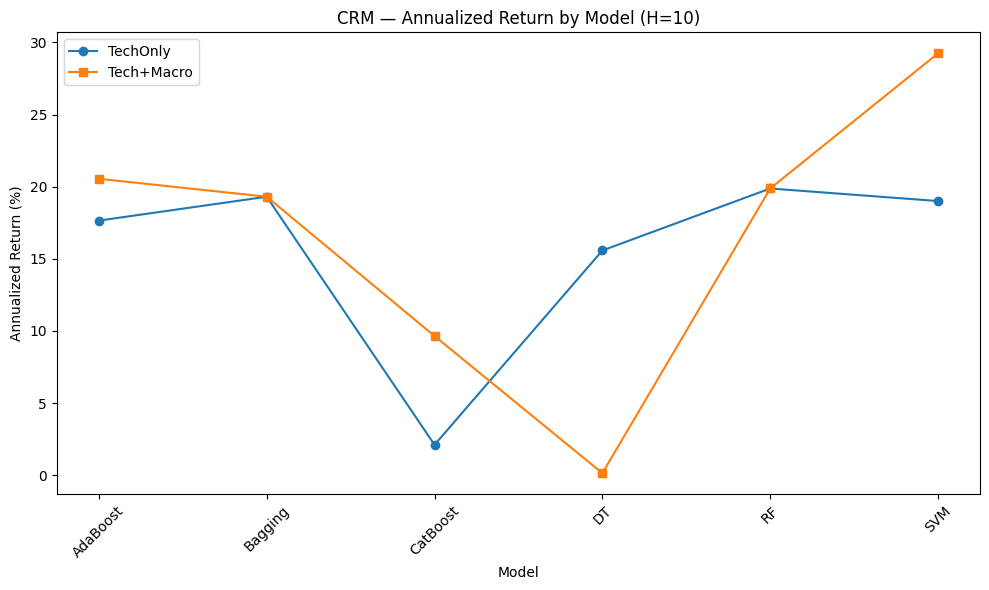

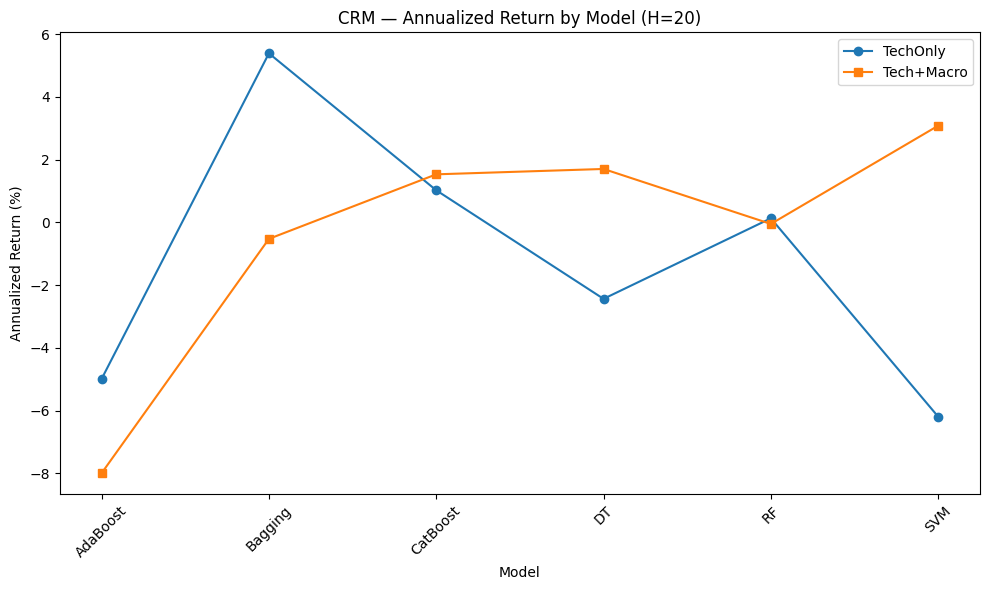


Best Tech+Macro for CRM, H=5: SVM, Ann.Return=18.03%, ROI=20.63%


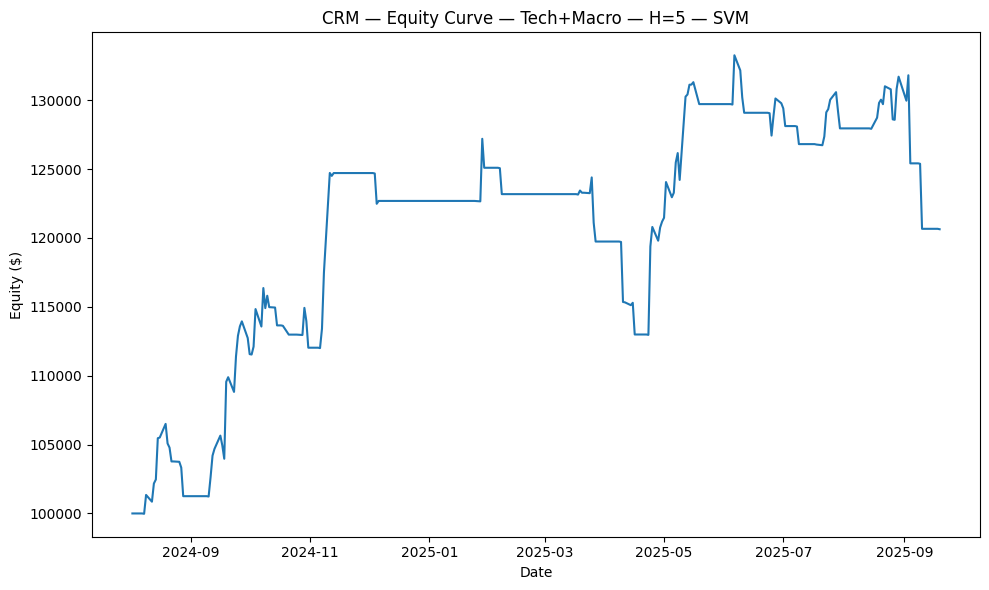

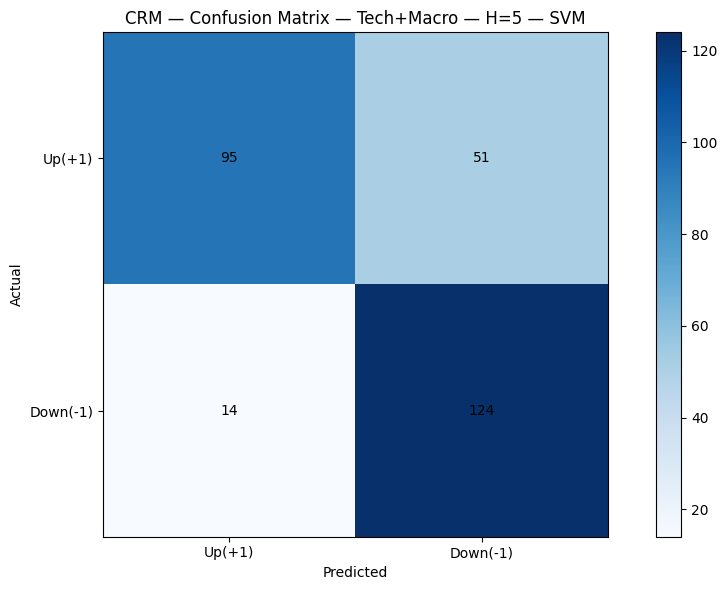

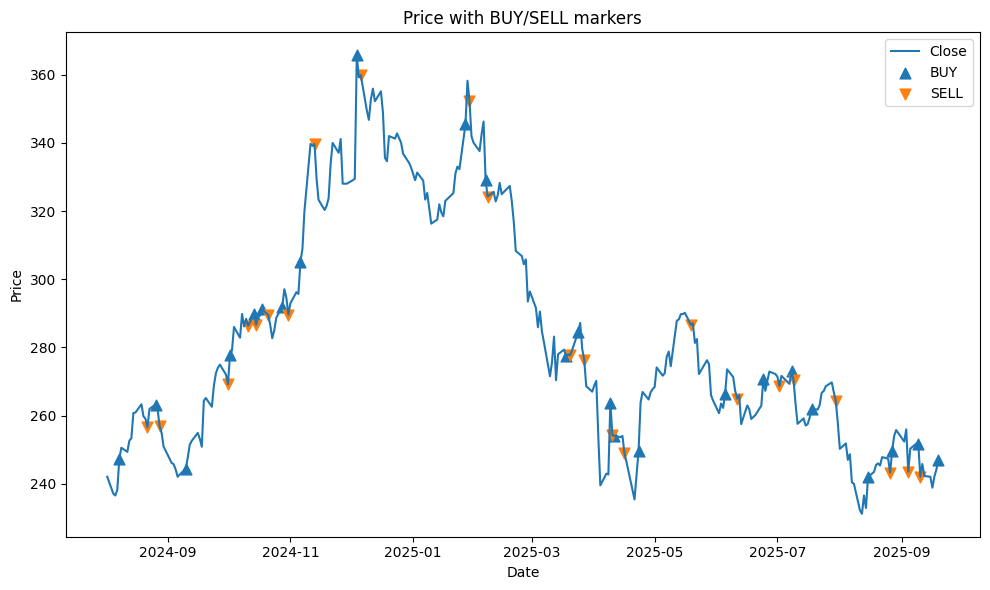

CRM — Trade log (first 25 rows) — Tech+Macro — H=5 — SVM


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  242.12204         -1         0   CASH  100000.000000   
1  2024-08-05  237.19960         -1         0   CASH  100000.000000   
2  2024-08-06  236.61409         -1         0   CASH  100000.000000   
3  2024-08-07  238.22180         -1         0   CASH  100000.000000   
4  2024-08-08  247.23303          1         1    BUY     -25.000000   
5  2024-08-09  250.61720          1         1   HOLD     -25.000000   
6  2024-08-12  249.40643          1         1   HOLD     -25.000000   
7  2024-08-13  252.67154          1         1   HOLD     -25.000000   
8  2024-08-14  253.38610          1         1   HOLD     -25.000000   
9  2024-08-15  260.79950          1         1   HOLD     -25.000000   
10 2024-08-16  260.91855          1         1   HOLD     -25.000000   
11 2024-08-19  263.36987          1         1   HOLD     -25.000000   
12 2024-08-20  259.85666          1         1   HOLD     -25.000000   
13 2024-08-21  259.11237          1         1   HOLD     -25.000000   
14 2024-08-22  256.63132         -1         0   SELL  103775.438974   
15 2024-08-23  262.00030         -1         0   CASH  103775.438974   
16 2024-08-26  263.27063          1         1    BUY     -25.943860   
17 2024-08-27  262.19880          1         1   HOLD     -25.943860   
18 2024-08-28  256.93893         -1         0   SELL  101254.303462   
19 2024-08-29  255.06328         -1         0   CASH  101254.303462   
20 2024-08-30  250.98440         -1         0   CASH  101254.303462   
21 2024-09-03  246.18106         -1         0   CASH  101254.303462   
22 2024-09-04  245.80392         -1         0   CASH  101254.303462   
23 2024-09-05  244.25574         -1         0   CASH  101254.303462   
24 2024-09-06  242.12204         -1         0   CASH  101254.303462   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4   404.476700   99975.000000  
5   404.476700  101343.817912  
6   404.476700  100854.089659  
7   404.476700  102174.750575  
8   404.476700  102463.773446  
9   404.476700  105462.321010  
10  404.476700  105510.473962  
11  404.476700  106501.975785  
12  404.476700  105080.964199  
13  404.476700  104779.916236  
14    0.000000  103775.438974  
15    0.000000  103775.438974  
16  394.177805  103749.495114  
17  394.177805  103327.003517  
18    0.000000  101254.303462  
19    0.000000  101254.303462  
20    0.000000  101254.303462  
21    0.000000  101254.303462  
22    0.000000  101254.303462  
23    0.000000  101254.303462  
24    0.000000  101254.303462


Best Tech+Macro for CRM, H=10: SVM, Ann.Return=29.25%, ROI=33.68%


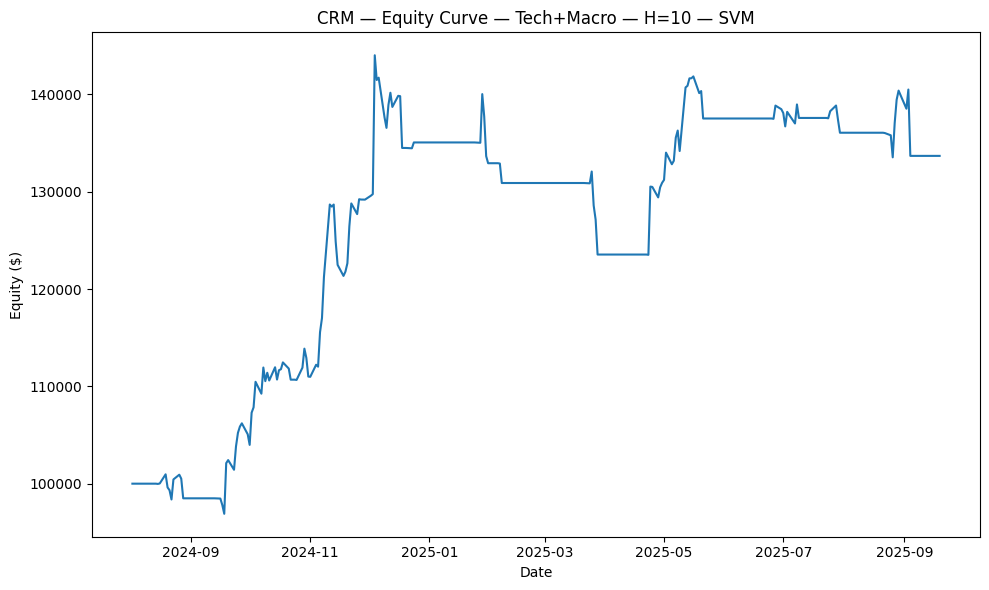

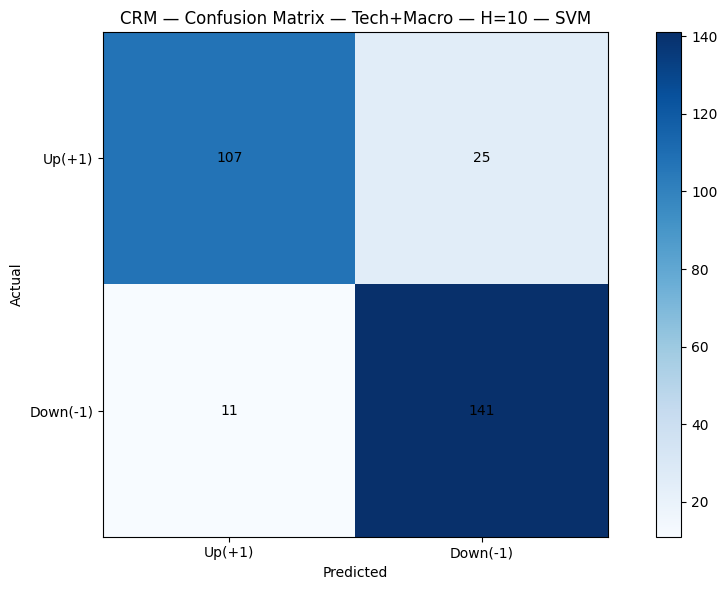

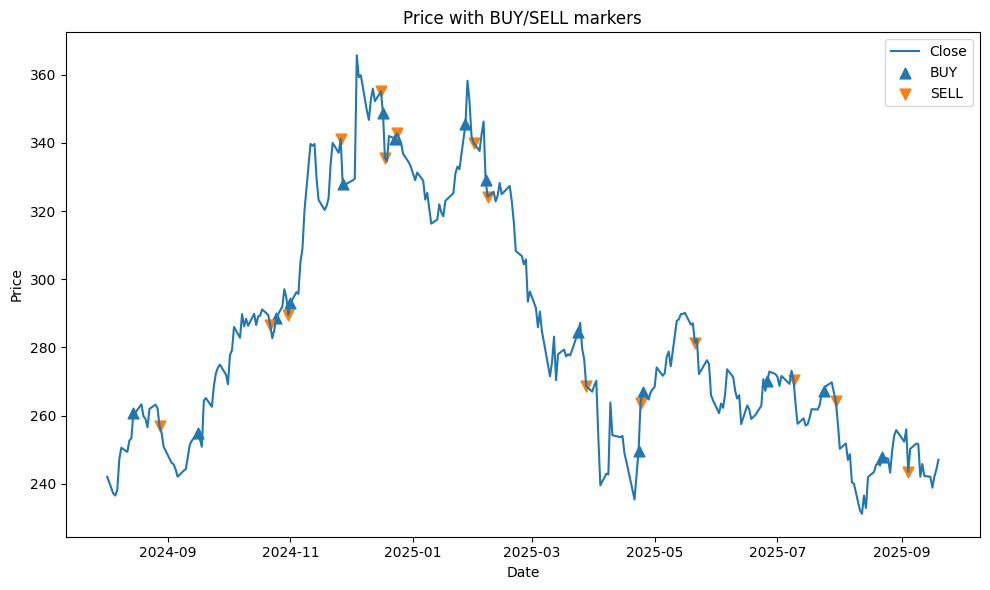

CRM — Trade log (first 25 rows) — Tech+Macro — H=10 — SVM


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  242.12204         -1         0   CASH  100000.000000   
1  2024-08-05  237.19960         -1         0   CASH  100000.000000   
2  2024-08-06  236.61409         -1         0   CASH  100000.000000   
3  2024-08-07  238.22180         -1         0   CASH  100000.000000   
4  2024-08-08  247.23303         -1         0   CASH  100000.000000   
5  2024-08-09  250.61720         -1         0   CASH  100000.000000   
6  2024-08-12  249.40643         -1         0   CASH  100000.000000   
7  2024-08-13  252.67154         -1         0   CASH  100000.000000   
8  2024-08-14  253.38610         -1         0   CASH  100000.000000   
9  2024-08-15  260.79950          1         1    BUY     -25.000000   
10 2024-08-16  260.91855          1         1   HOLD     -25.000000   
11 2024-08-19  263.36987          1         1   HOLD     -25.000000   
12 2024-08-20  259.85666          1         1   HOLD     -25.000000   
13 2024-08-21  259.11237          1         1   HOLD     -25.000000   
14 2024-08-22  256.63132          1         1   HOLD     -25.000000   
15 2024-08-23  262.00030          1         1   HOLD     -25.000000   
16 2024-08-26  263.27063          1         1   HOLD     -25.000000   
17 2024-08-27  262.19880          1         1   HOLD     -25.000000   
18 2024-08-28  256.93893         -1         0   SELL   98495.087325   
19 2024-08-29  255.06328         -1         0   CASH   98495.087325   
20 2024-08-30  250.98440         -1         0   CASH   98495.087325   
21 2024-09-03  246.18106         -1         0   CASH   98495.087325   
22 2024-09-04  245.80392         -1         0   CASH   98495.087325   
23 2024-09-05  244.25574         -1         0   CASH   98495.087325   
24 2024-09-06  242.12204         -1         0   CASH   98495.087325   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4     0.000000  100000.000000  
5     0.000000  100000.000000  
6     0.000000  100000.000000  
7     0.000000  100000.000000  
8     0.000000  100000.000000  
9   383.436318   99975.000000  
10  383.436318  100020.648094  
11  383.436318  100960.573209  
12  383.436318   99613.480902  
13  383.436318   99328.093085  
14  383.436318   98376.768408  
15  383.436318  100435.430331  
16  383.436318  100922.520988  
17  383.436318  100511.542440  
18    0.000000   98495.087325  
19    0.000000   98495.087325  
20    0.000000   98495.087325  
21    0.000000   98495.087325  
22    0.000000   98495.087325  
23    0.000000   98495.087325  
24    0.000000   98495.087325


Best Tech+Macro for CRM, H=20: SVM, Ann.Return=3.08%, ROI=3.49%


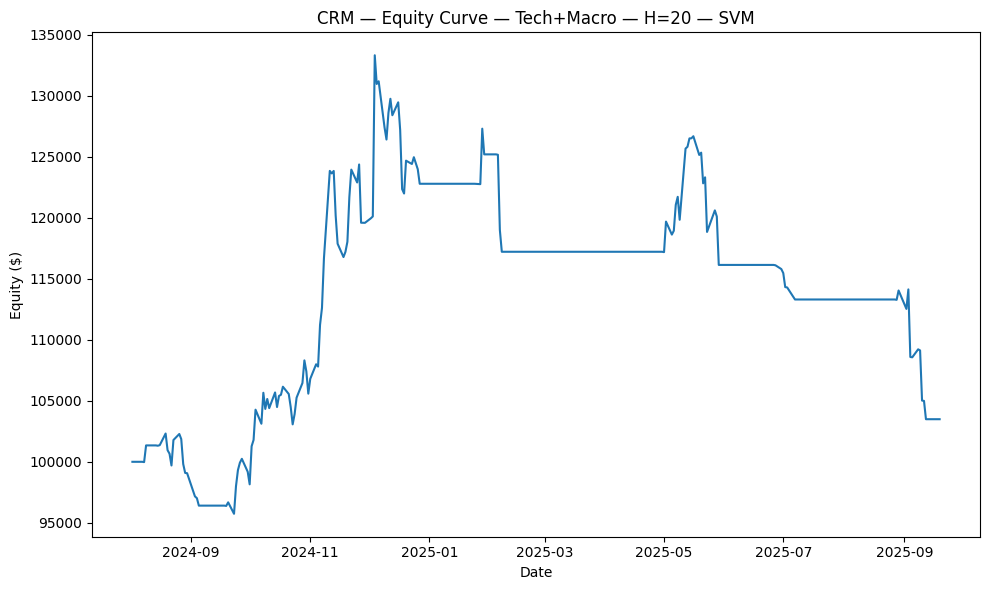

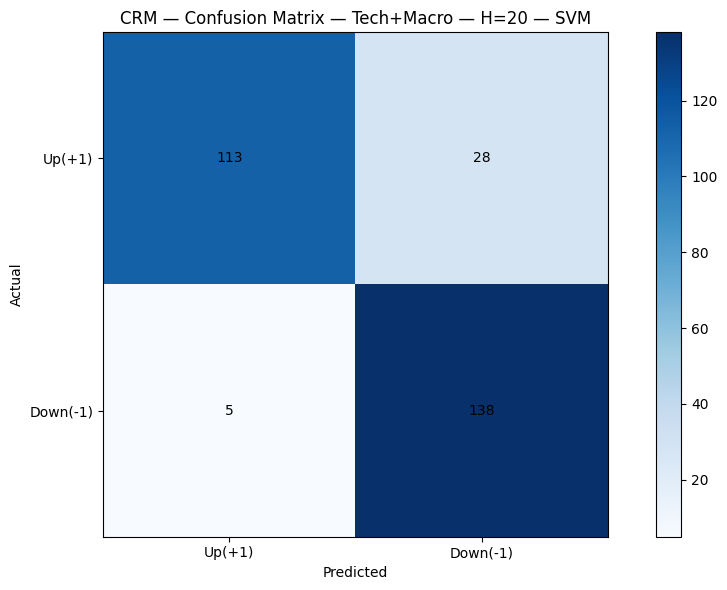

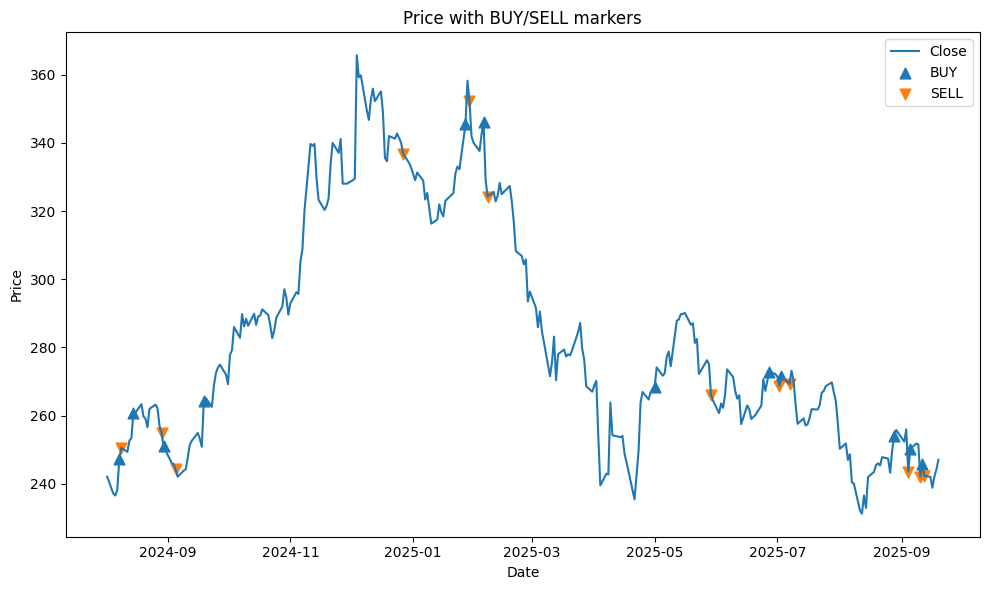

CRM — Trade log (first 25 rows) — Tech+Macro — H=20 — SVM


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  242.12204         -1         0   CASH  100000.000000   
1  2024-08-05  237.19960         -1         0   CASH  100000.000000   
2  2024-08-06  236.61409         -1         0   CASH  100000.000000   
3  2024-08-07  238.22180         -1         0   CASH  100000.000000   
4  2024-08-08  247.23303          1         1    BUY     -25.000000   
5  2024-08-09  250.61720         -1         0   SELL  101343.475708   
6  2024-08-12  249.40643         -1         0   CASH  101343.475708   
7  2024-08-13  252.67154         -1         0   CASH  101343.475708   
8  2024-08-14  253.38610         -1         0   CASH  101343.475708   
9  2024-08-15  260.79950          1         1    BUY     -25.335869   
10 2024-08-16  260.91855          1         1   HOLD     -25.335869   
11 2024-08-19  263.36987          1         1   HOLD     -25.335869   
12 2024-08-20  259.85666          1         1   HOLD     -25.335869   
13 2024-08-21  259.11237          1         1   HOLD     -25.335869   
14 2024-08-22  256.63132          1         1   HOLD     -25.335869   
15 2024-08-23  262.00030          1         1   HOLD     -25.335869   
16 2024-08-26  263.27063          1         1   HOLD     -25.335869   
17 2024-08-27  262.19880          1         1   HOLD     -25.335869   
18 2024-08-28  256.93893          1         1   HOLD     -25.335869   
19 2024-08-29  255.06328         -1         0   SELL   99089.672606   
20 2024-08-30  250.98440          1         1    BUY     -24.772418   
21 2024-09-03  246.18106          1         1   HOLD     -24.772418   
22 2024-09-04  245.80392          1         1   HOLD     -24.772418   
23 2024-09-05  244.25574         -1         0   SELL   96409.061692   
24 2024-09-06  242.12204         -1         0   CASH   96409.061692   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4   404.476700   99975.000000  
5     0.000000  101343.475708  
6     0.000000  101343.475708  
7     0.000000  101343.475708  
8     0.000000  101343.475708  
9   388.587692  101318.139839  
10  388.587692  101364.401204  
11  388.587692  102316.953984  
12  388.587692  100951.763820  
13  388.587692  100662.541887  
14  388.587692   99698.436394  
15  388.587692  101784.755939  
16  388.587692  102278.390542  
17  388.587692  101861.890596  
18  388.587692   99817.969854  
19    0.000000   99089.672606  
20  394.804110   99064.900188  
21  394.804110   97168.521815  
22  394.804110   97019.625393  
23    0.000000   96409.061692  
24    0.000000   96409.061692

/tmp/ipython-input-1667154152.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


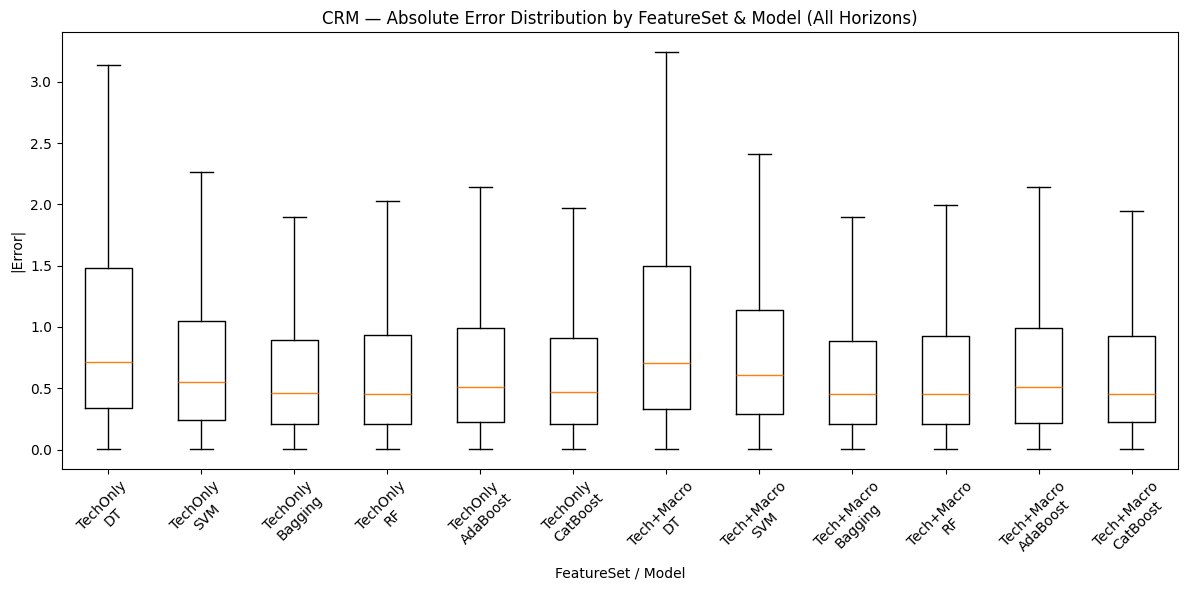

In [ ]:
res_CRM = run_for_stock("CRM")



==================== MSFT ====================

Feature set: TechOnly  (#features = 38)
  H=5, Model=DT, FS=TechOnly done.
  H=5, Model=SVM, FS=TechOnly done.
  H=5, Model=Bagging, FS=TechOnly done.
  H=5, Model=RF, FS=TechOnly done.
  H=5, Model=AdaBoost, FS=TechOnly done.
  H=5, Model=CatBoost, FS=TechOnly done.
  H=10, Model=DT, FS=TechOnly done.
  H=10, Model=SVM, FS=TechOnly done.
  H=10, Model=Bagging, FS=TechOnly done.
  H=10, Model=RF, FS=TechOnly done.
  H=10, Model=AdaBoost, FS=TechOnly done.
  H=10, Model=CatBoost, FS=TechOnly done.
  H=20, Model=DT, FS=TechOnly done.
  H=20, Model=SVM, FS=TechOnly done.
  H=20, Model=Bagging, FS=TechOnly done.
  H=20, Model=RF, FS=TechOnly done.
  H=20, Model=AdaBoost, FS=TechOnly done.
  H=20, Model=CatBoost, FS=TechOnly done.

Feature set: Tech+Macro  (#features = 43)
  H=5, Model=DT, FS=Tech+Macro done.
  H=5, Model=SVM, FS=Tech+Macro done.
  H=5, Model=Bagging, FS=Tech+Macro done.
  H=5, Model=RF, FS=Tech+Macro done.
  H=5, Model=AdaBo

Ticker  FeatureSet  Horizon     Model       MAE      RMSE  Accuracy  \
0    MSFT  Tech+Macro        5  AdaBoost  1.286699  1.788895  0.799296   
1    MSFT  Tech+Macro        5   Bagging  1.343100  1.833636  0.799296   
2    MSFT  Tech+Macro        5  CatBoost  1.478663  1.946742  0.742958   
3    MSFT  Tech+Macro        5        DT  1.888114  2.411434  0.753521   
4    MSFT  Tech+Macro        5        RF  1.307204  1.811909  0.799296   
5    MSFT  Tech+Macro        5       SVM  1.503080  2.046087  0.778169   
6    MSFT  Tech+Macro       10  AdaBoost  0.745225  1.092844  0.866197   
7    MSFT  Tech+Macro       10   Bagging  0.756199  1.078955  0.880282   
8    MSFT  Tech+Macro       10  CatBoost  0.763537  1.076409  0.883803   
9    MSFT  Tech+Macro       10        DT  0.975508  1.301629  0.757042   
10   MSFT  Tech+Macro       10        RF  0.727535  1.074765  0.883803   
11   MSFT  Tech+Macro       10       SVM  1.017714  1.390907  0.813380   
12   MSFT  Tech+Macro       20  AdaBoost  0.405712  0.634240  0.911972   
13   MSFT  Tech+Macro       20   Bagging  0.384921  0.580694  0.911972   
14   MSFT  Tech+Macro       20  CatBoost  0.406163  0.611395  0.904930   
15   MSFT  Tech+Macro       20        DT  0.533397  0.699391  0.845070   
16   MSFT  Tech+Macro       20        RF  0.382269  0.585385  0.915493   
17   MSFT  Tech+Macro       20       SVM  0.577061  0.860986  0.866197   
18   MSFT    TechOnly        5  AdaBoost  1.287514  1.789768  0.795775   
19   MSFT    TechOnly        5   Bagging  1.333956  1.836534  0.802817   
20   MSFT    TechOnly        5  CatBoost  1.469367  1.941745  0.725352   
21   MSFT    TechOnly        5        DT  1.913121  2.454138  0.739437   
22   MSFT    TechOnly        5        RF  1.307047  1.812022  0.799296   
23   MSFT    TechOnly        5       SVM  1.544088  2.096358  0.785211   
24   MSFT    TechOnly       10  AdaBoost  0.753242  1.102565  0.862676   
25   MSFT    TechOnly       10   Bagging  0.743899  1.072114  0.873239   
26   MSFT    TechOnly       10  CatBoost  0.763886  1.090422  0.894366   
27   MSFT    TechOnly       10        DT  0.976669  1.308119  0.742958   
28   MSFT    TechOnly       10        RF  0.727851  1.074662  0.883803   
29   MSFT    TechOnly       10       SVM  1.040637  1.446142  0.813380   
30   MSFT    TechOnly       20  AdaBoost  0.406959  0.633693  0.911972   
31   MSFT    TechOnly       20   Bagging  0.382435  0.577566  0.919014   
32   MSFT    TechOnly       20  CatBoost  0.424873  0.632032  0.911972   
33   MSFT    TechOnly       20        DT  0.543597  0.699759  0.855634   
34   MSFT    TechOnly       20        RF  0.382192  0.585364  0.922535   
35   MSFT    TechOnly       20       SVM  0.590454  0.907016  0.866197   

    Precision    Recall        F1  TotalReturn_%      ROI_%  \
0    0.838509  0.813253  0.825688      12.160455  12.160455   
1    0.847134  0.801205  0.823529      10.704545  10.704545   
2    0.866142  0.662651  0.750853      -0.043076  -0.043076   
3    0.815789  0.746988  0.779874      -1.918154  -1.918154   
4    0.838509  0.813253  0.825688      12.160455  12.160455   
5    0.865248  0.734940  0.794788      16.547386  16.547386   
6    0.857143  0.911392  0.883436      16.332930  16.332930   
7    0.892405  0.892405  0.892405      11.944069  11.944069   
8    0.888199  0.905063  0.896552      17.138260  17.138260   
9    0.794702  0.759494  0.776699       6.076811   6.076811   
10   0.898089  0.892405  0.895238      14.688126  14.688126   
11   0.830189  0.835443  0.832808      12.254998  12.254998   
12   0.936170  0.891892  0.913495       1.156341   1.156341   
13   0.901961  0.932432  0.916944       4.914457   4.914457   
14   0.941606  0.871622  0.905263       1.063120   1.063120   
15   0.856164  0.844595  0.850340      10.001575  10.001575   
16   0.913333  0.925676  0.919463       2.825103   2.825103   
17   0.923077  0.810811  0.863309      -5.383661  -5.383661   
18   0.833333  0.813253  0.823171      12.495144  12.495144   
19  


Average performance by FeatureSet & Horizon:


MAE    RMSE  Accuracy      F1    ROI_%  \
FeatureSet Horizon                                              
Tech+Macro 5        1.4678  1.9731    0.7788  0.8001   8.2686   
           10       0.8310  1.1693    0.8474  0.8629  13.0725   
           20       0.4483  0.6620    0.8926  0.8948   2.4295   
TechOnly   5        1.4758  1.9884    0.7746  0.7962   7.0113   
           10       0.8344  1.1823    0.8451  0.8585  14.1198   
           20       0.4551  0.6726    0.8979  0.9001   4.2468   

                    AnnualizedReturn_%  MaxDrawdown_%  
FeatureSet Horizon                                     
Tech+Macro 5                    7.2515       -17.9646  
           10                  11.4634       -19.8699  
           20                   2.1334       -24.0968  
TechOnly   5                    6.1260       -18.7975  
           10                  12.3649       -20.0575  
           20                   3.7255       -22.8502


Average performance by FeatureSet (all horizons & models):


MAE    RMSE  Accuracy      F1   ROI_%  AnnualizedReturn_%  \
FeatureSet                                                                 
Tech+Macro  0.9157  1.2681    0.8396  0.8526  7.9235              6.9494   
TechOnly    0.9218  1.2811    0.8392  0.8516  8.4593              7.4055   

            MaxDrawdown_%  
FeatureSet                 
Tech+Macro       -20.6438  
TechOnly         -20.5684

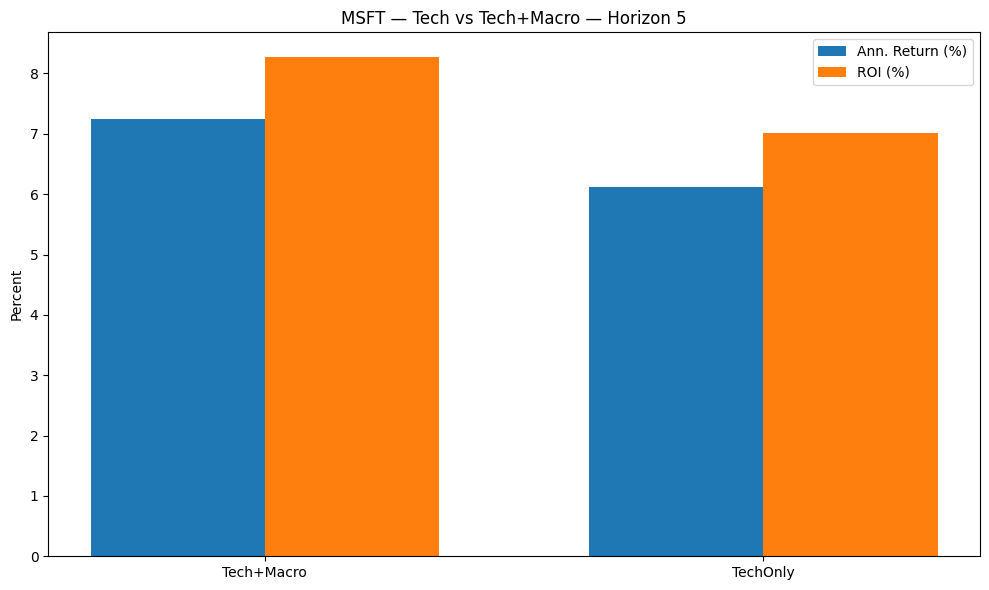

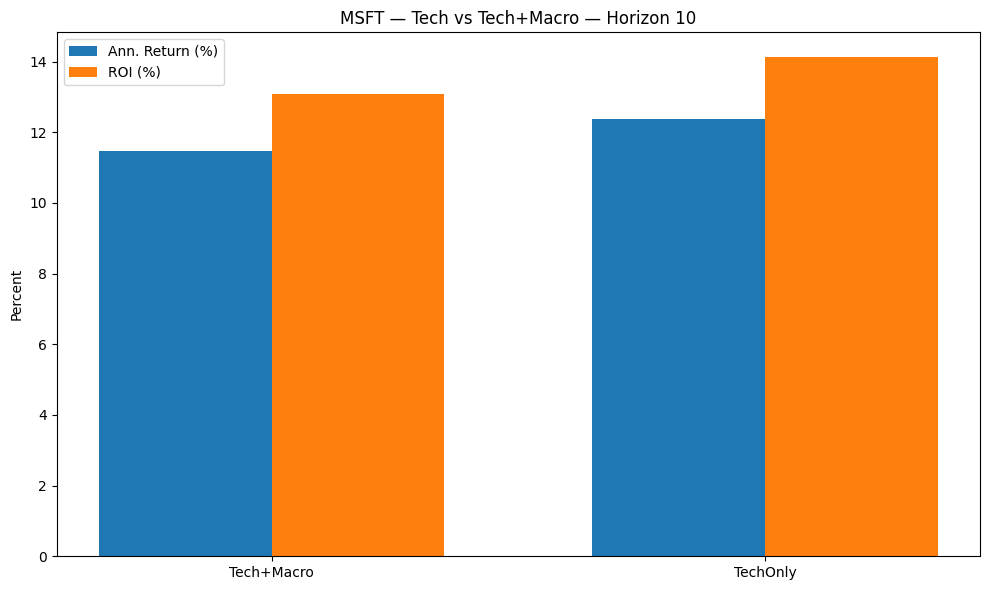

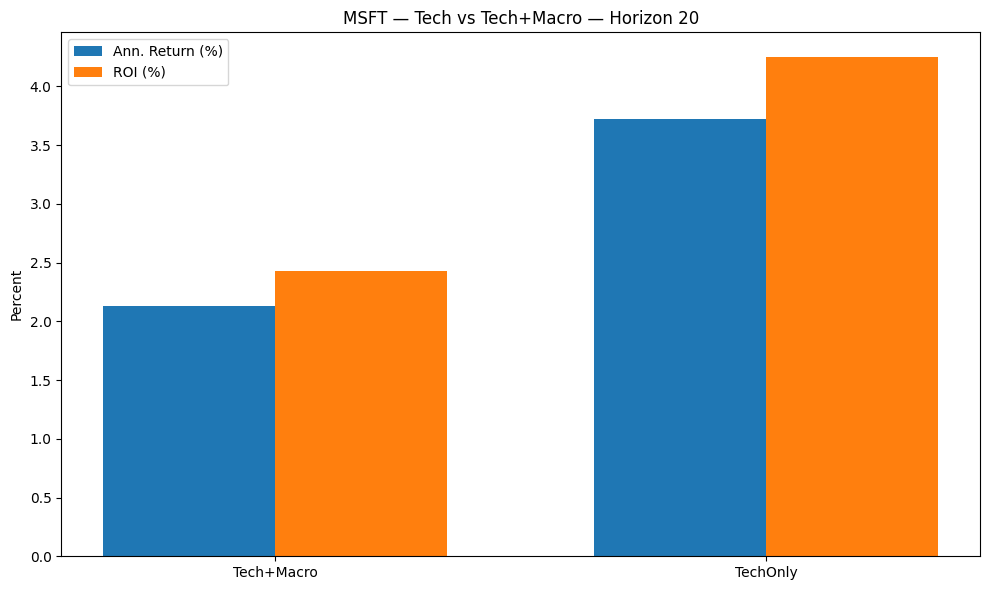

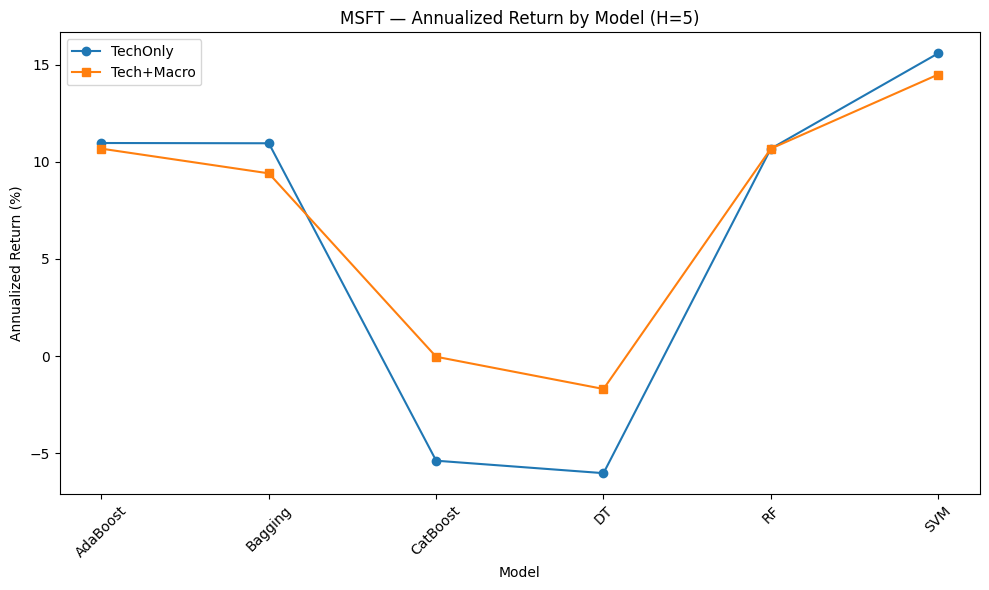

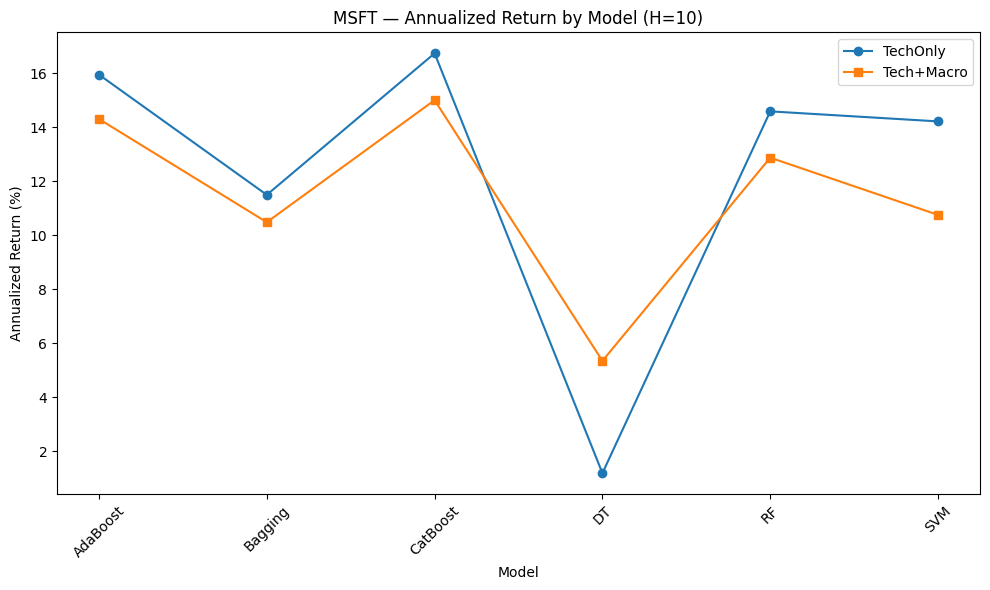

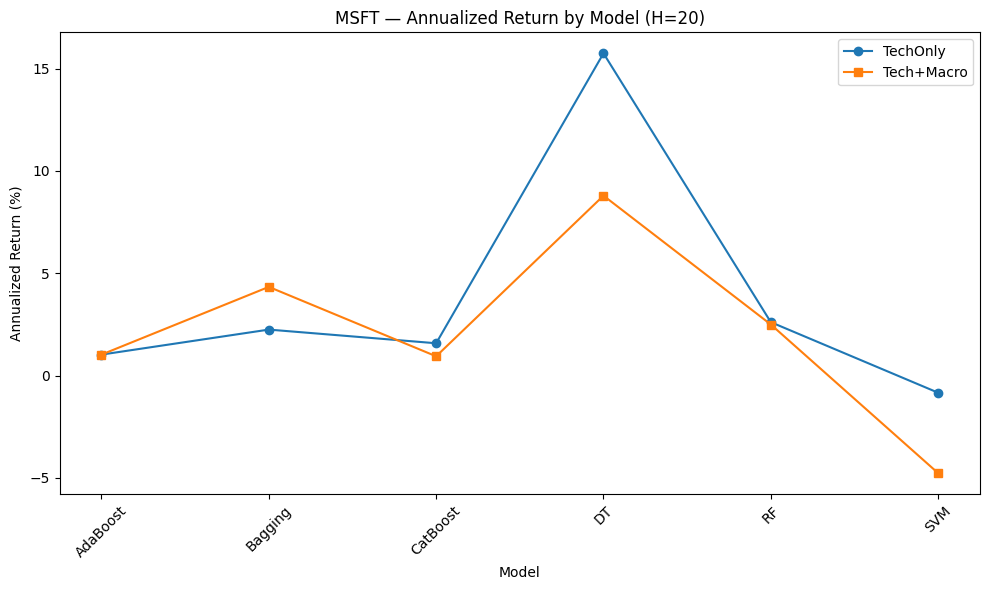


Best Tech+Macro for MSFT, H=5: SVM, Ann.Return=14.49%, ROI=16.55%


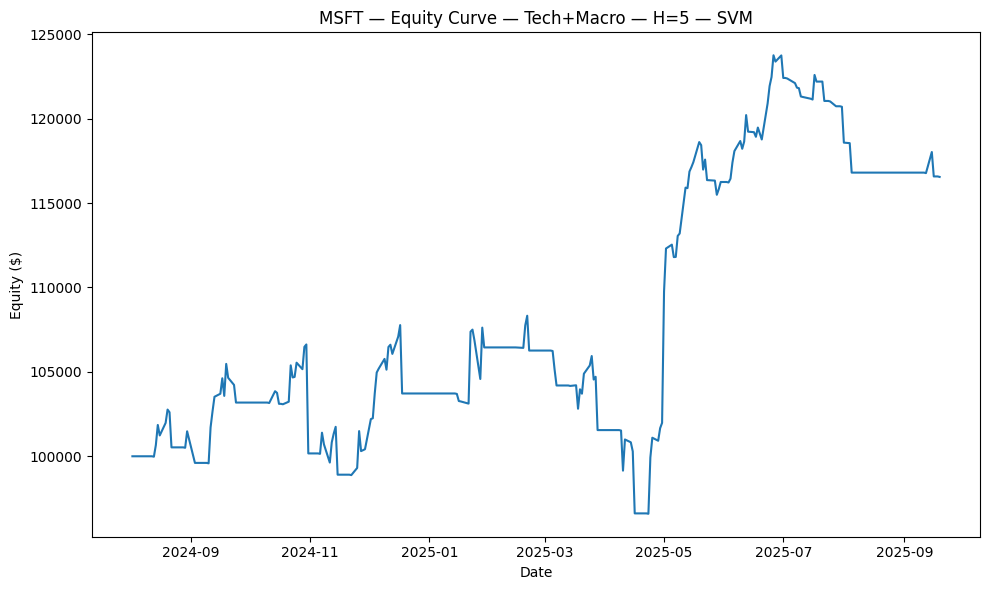

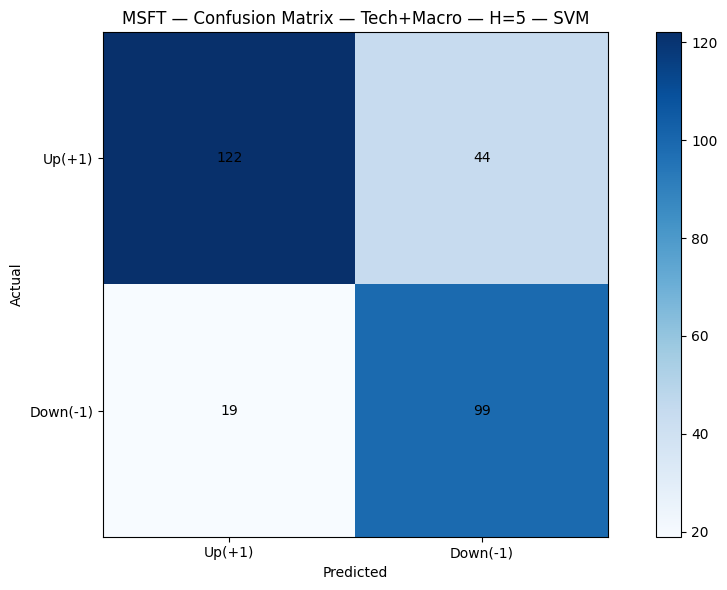

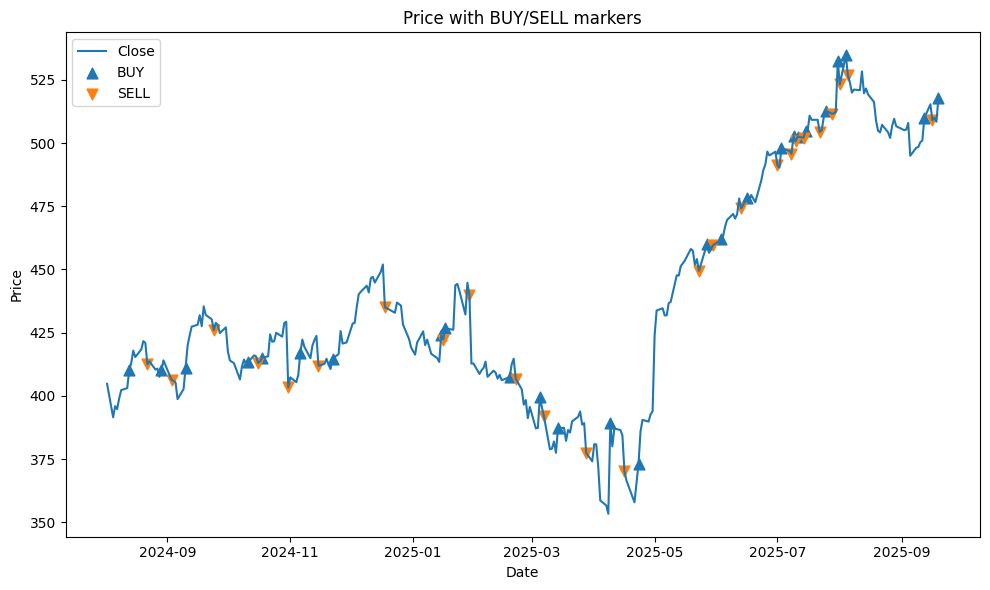

MSFT — Trade log (first 25 rows) — Tech+Macro — H=5 — SVM


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  404.71664         -1         0   CASH  100000.000000   
1  2024-08-05  391.49985         -1         0   CASH  100000.000000   
2  2024-08-06  395.91867         -1         0   CASH  100000.000000   
3  2024-08-07  394.74954         -1         0   CASH  100000.000000   
4  2024-08-08  398.97020         -1         0   CASH  100000.000000   
5  2024-08-09  402.26944         -1         0   CASH  100000.000000   
6  2024-08-12  403.05215         -1         0   CASH  100000.000000   
7  2024-08-13  410.18564          1         1    BUY     -25.000000   
8  2024-08-14  413.00930          1         1   HOLD     -25.000000   
9  2024-08-15  417.89264          1         1   HOLD     -25.000000   
10 2024-08-16  415.35170          1         1   HOLD     -25.000000   
11 2024-08-19  418.38892          1         1   HOLD     -25.000000   
12 2024-08-20  421.63458          1         1   HOLD     -25.000000   
13 2024-08-21  420.97952          1         1   HOLD     -25.000000   
14 2024-08-22  412.45346         -1         0   SELL  100527.738278   
15 2024-08-23  413.68423         -1         0   CASH  100527.738278   
16 2024-08-26  410.40884         -1         0   CASH  100527.738278   
17 2024-08-27  410.75623         -1         0   CASH  100527.738278   
18 2024-08-28  407.54037         -1         0   CASH  100527.738278   
19 2024-08-29  410.04160          1         1    BUY     -25.131935   
20 2024-08-30  414.03168          1         1   HOLD     -25.131935   
21 2024-09-03  406.38904         -1         0   SELL   99607.351326   
22 2024-09-04  405.85306         -1         0   CASH   99607.351326   
23 2024-09-05  405.34686         -1         0   CASH   99607.351326   
24 2024-09-06  398.70670         -1         0   CASH   99607.351326   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4     0.000000  100000.000000  
5     0.000000  100000.000000  
6     0.000000  100000.000000  
7   243.792055   99975.000000  
8   243.792055  100663.385873  
9   243.792055  101853.905366  
10  243.792055  101234.444382  
11  243.792055  101974.894487  
12  243.792055  102766.160607  
13  243.792055  102606.462184  
14    0.000000  100527.738278  
15    0.000000  100527.738278  
16    0.000000  100527.738278  
17    0.000000  100527.738278  
18    0.000000  100527.738278  
19  245.164730  100502.606344  
20  245.164730  101480.833231  
21    0.000000   99607.351326  
22    0.000000   99607.351326  
23    0.000000   99607.351326  
24    0.000000   99607.351326


Best Tech+Macro for MSFT, H=10: CatBoost, Ann.Return=15.00%, ROI=17.14%


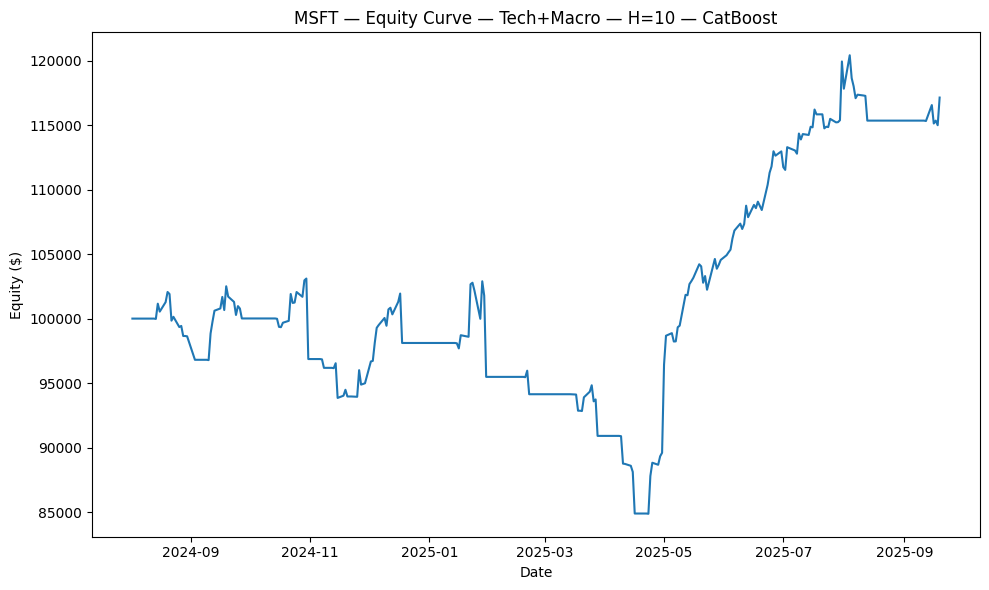

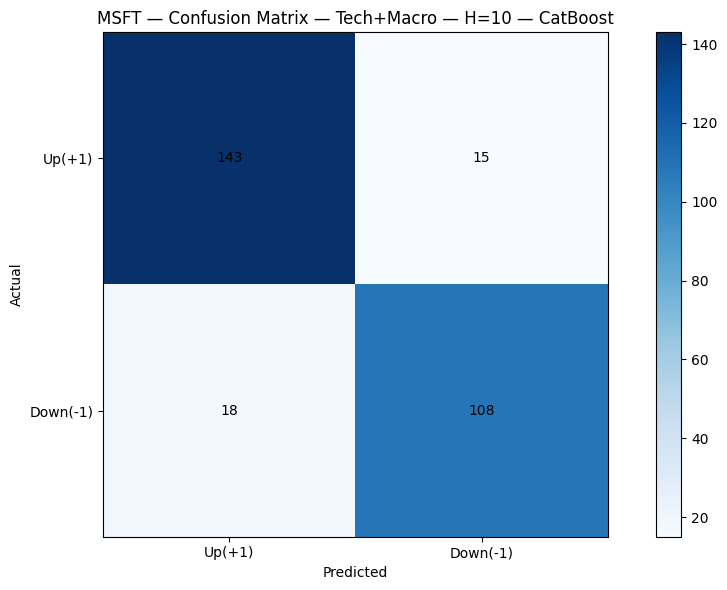

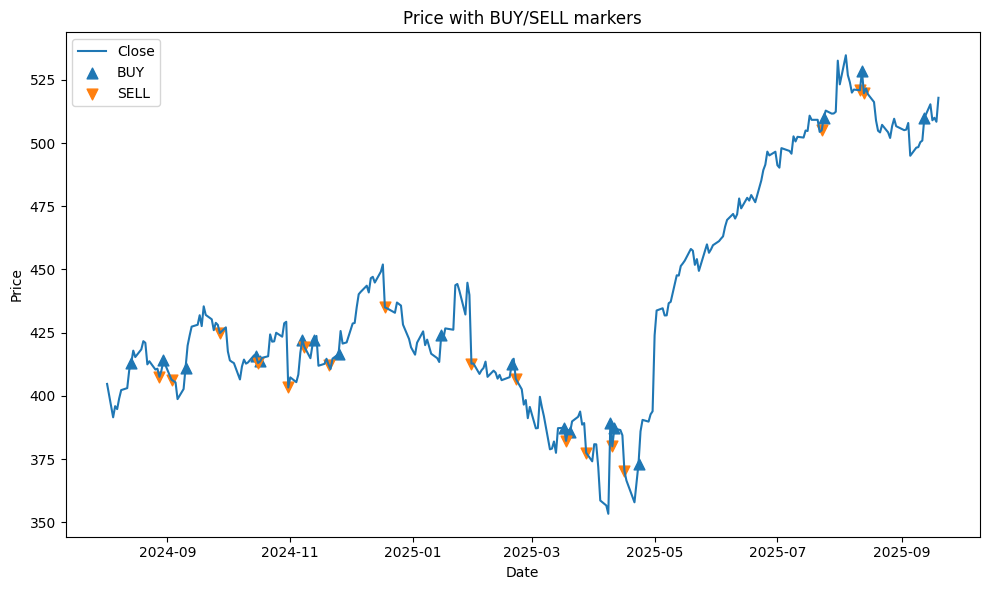

MSFT — Trade log (first 25 rows) — Tech+Macro — H=10 — CatBoost


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  404.71664         -1         0   CASH  100000.000000   
1  2024-08-05  391.49985         -1         0   CASH  100000.000000   
2  2024-08-06  395.91867         -1         0   CASH  100000.000000   
3  2024-08-07  394.74954         -1         0   CASH  100000.000000   
4  2024-08-08  398.97020         -1         0   CASH  100000.000000   
5  2024-08-09  402.26944         -1         0   CASH  100000.000000   
6  2024-08-12  403.05215         -1         0   CASH  100000.000000   
7  2024-08-13  410.18564         -1         0   CASH  100000.000000   
8  2024-08-14  413.00930          1         1    BUY     -25.000000   
9  2024-08-15  417.89264          1         1   HOLD     -25.000000   
10 2024-08-16  415.35170          1         1   HOLD     -25.000000   
11 2024-08-19  418.38892          1         1   HOLD     -25.000000   
12 2024-08-20  421.63458          1         1   HOLD     -25.000000   
13 2024-08-21  420.97952          1         1   HOLD     -25.000000   
14 2024-08-22  412.45346          1         1   HOLD     -25.000000   
15 2024-08-23  413.68423          1         1   HOLD     -25.000000   
16 2024-08-26  410.40884          1         1   HOLD     -25.000000   
17 2024-08-27  410.75623          1         1   HOLD     -25.000000   
18 2024-08-28  407.54037         -1         0   SELL   98651.164733   
19 2024-08-29  410.04160         -1         0   CASH   98651.164733   
20 2024-08-30  414.03168          1         1    BUY     -24.662791   
21 2024-09-03  406.38904         -1         0   SELL   96805.948383   
22 2024-09-04  405.85306         -1         0   CASH   96805.948383   
23 2024-09-05  405.34686         -1         0   CASH   96805.948383   
24 2024-09-06  398.70670         -1         0   CASH   96805.948383   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4     0.000000  100000.000000  
5     0.000000  100000.000000  
6     0.000000  100000.000000  
7     0.000000  100000.000000  
8   242.125298   99975.000000  
9   242.125298  101157.380155  
10  242.125298  100542.154299  
11  242.125298  101277.542098  
12  242.125298  102063.398494  
13  242.125298  101904.791896  
14  242.125298   99840.417074  
15  242.125298  100138.417628  
16  242.125298   99345.362847  
17  242.125298   99429.474754  
18    0.000000   98651.164733  
19    0.000000   98651.164733  
20  238.269605   98626.501942  
21    0.000000   96805.948383  
22    0.000000   96805.948383  
23    0.000000   96805.948383  
24    0.000000   96805.948383


Best Tech+Macro for MSFT, H=20: DT, Ann.Return=8.79%, ROI=10.00%


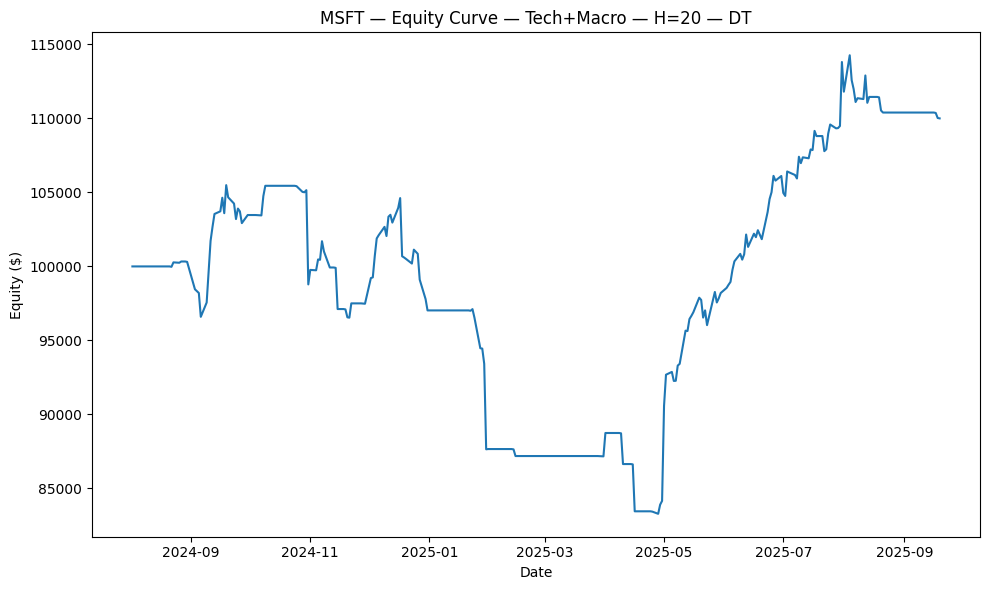

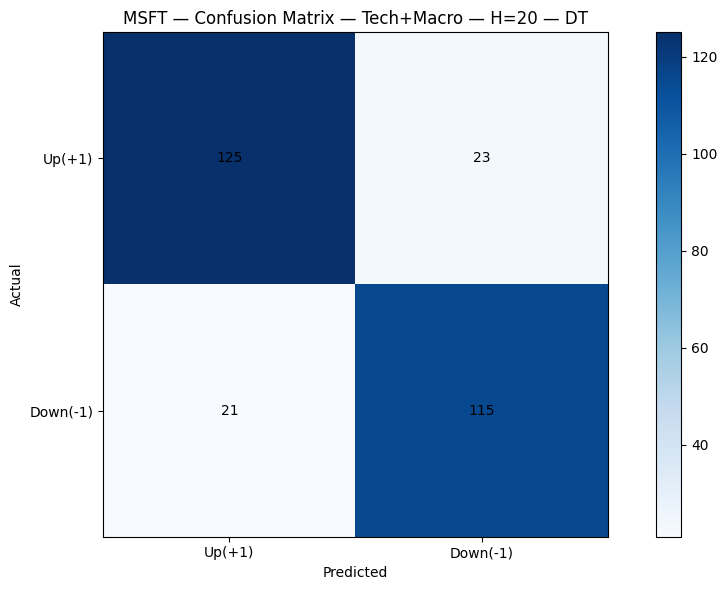

MSFT — Trade log (first 25 rows) — Tech+Macro — H=20 — DT


Date      Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  404.71664         -1         0   CASH  100000.000000   
1  2024-08-05  391.49985         -1         0   CASH  100000.000000   
2  2024-08-06  395.91867         -1         0   CASH  100000.000000   
3  2024-08-07  394.74954         -1         0   CASH  100000.000000   
4  2024-08-08  398.97020         -1         0   CASH  100000.000000   
5  2024-08-09  402.26944         -1         0   CASH  100000.000000   
6  2024-08-12  403.05215         -1         0   CASH  100000.000000   
7  2024-08-13  410.18564         -1         0   CASH  100000.000000   
8  2024-08-14  413.00930         -1         0   CASH  100000.000000   
9  2024-08-15  417.89264         -1         0   CASH  100000.000000   
10 2024-08-16  415.35170         -1         0   CASH  100000.000000   
11 2024-08-19  418.38892         -1         0   CASH  100000.000000   
12 2024-08-20  421.63458         -1         0   CASH  100000.000000   
13 2024-08-21  420.97952         -1         0   CASH  100000.000000   
14 2024-08-22  412.45346          1         1    BUY     -25.000000   
15 2024-08-23  413.68423         -1         0   SELL  100273.327551   
16 2024-08-26  410.40884          1         1    BUY     -25.068332   
17 2024-08-27  410.75623         -1         0   SELL  100333.114221   
18 2024-08-28  407.54037         -1         0   CASH  100333.114221   
19 2024-08-29  410.04160         -1         0   CASH  100333.114221   
20 2024-08-30  414.03168          1         1    BUY     -25.083279   
21 2024-09-03  406.38904          1         1   HOLD     -25.083279   
22 2024-09-04  405.85306          1         1   HOLD     -25.083279   
23 2024-09-05  405.34686          1         1   HOLD     -25.083279   
24 2024-09-06  398.70670          1         1   HOLD     -25.083279   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4     0.000000  100000.000000  
5     0.000000  100000.000000  
6     0.000000  100000.000000  
7     0.000000  100000.000000  
8     0.000000  100000.000000  
9     0.000000  100000.000000  
10    0.000000  100000.000000  
11    0.000000  100000.000000  
12    0.000000  100000.000000  
13    0.000000  100000.000000  
14  242.451597   99975.000000  
15    0.000000  100273.327551  
16  244.325457  100248.259219  
17    0.000000  100333.114221  
18    0.000000  100333.114221  
19    0.000000  100333.114221  
20  242.331974  100308.030942  
21  242.331974   98455.974906  
22  242.331974   98326.089815  
23  242.331974   98203.421370  
24  242.331974   96594.298291

/tmp/ipython-input-1667154152.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


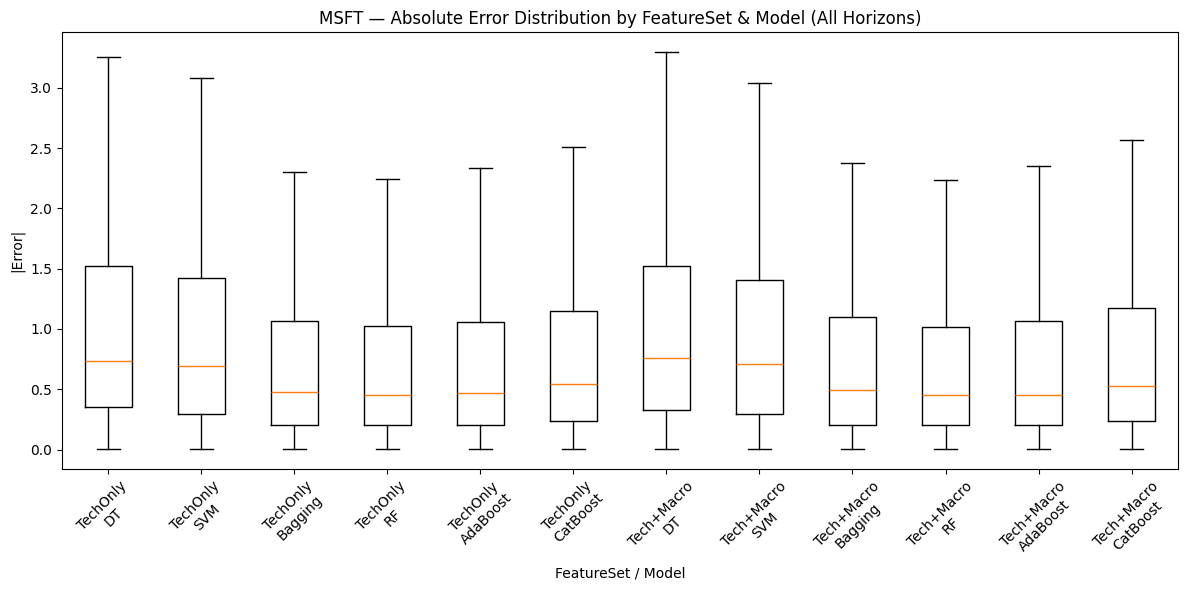

In [ ]:
res_MSFT = run_for_stock("MSFT")



==================== NOW ====================

Feature set: TechOnly  (#features = 38)
  H=5, Model=DT, FS=TechOnly done.
  H=5, Model=SVM, FS=TechOnly done.
  H=5, Model=Bagging, FS=TechOnly done.
  H=5, Model=RF, FS=TechOnly done.
  H=5, Model=AdaBoost, FS=TechOnly done.
  H=5, Model=CatBoost, FS=TechOnly done.
  H=10, Model=DT, FS=TechOnly done.
  H=10, Model=SVM, FS=TechOnly done.
  H=10, Model=Bagging, FS=TechOnly done.
  H=10, Model=RF, FS=TechOnly done.
  H=10, Model=AdaBoost, FS=TechOnly done.
  H=10, Model=CatBoost, FS=TechOnly done.
  H=20, Model=DT, FS=TechOnly done.
  H=20, Model=SVM, FS=TechOnly done.
  H=20, Model=Bagging, FS=TechOnly done.
  H=20, Model=RF, FS=TechOnly done.
  H=20, Model=AdaBoost, FS=TechOnly done.
  H=20, Model=CatBoost, FS=TechOnly done.

Feature set: Tech+Macro  (#features = 43)
  H=5, Model=DT, FS=Tech+Macro done.
  H=5, Model=SVM, FS=Tech+Macro done.
  H=5, Model=Bagging, FS=Tech+Macro done.
  H=5, Model=RF, FS=Tech+Macro done.
  H=5, Model=AdaBoo

Ticker  FeatureSet  Horizon     Model       MAE      RMSE  Accuracy  \
0     NOW  Tech+Macro        5  AdaBoost  4.736728  6.717303  0.809859   
1     NOW  Tech+Macro        5   Bagging  4.654459  6.333315  0.799296   
2     NOW  Tech+Macro        5  CatBoost  5.267334  7.145828  0.767606   
3     NOW  Tech+Macro        5        DT  5.910351  7.717797  0.721831   
4     NOW  Tech+Macro        5        RF  4.550994  6.318821  0.813380   
5     NOW  Tech+Macro        5       SVM  7.342410  9.725135  0.524648   
6     NOW  Tech+Macro       10  AdaBoost  2.643076  3.625807  0.890845   
7     NOW  Tech+Macro       10   Bagging  2.672308  3.602377  0.859155   
8     NOW  Tech+Macro       10  CatBoost  2.845609  3.865986  0.862676   
9     NOW  Tech+Macro       10        DT  3.998004  5.047649  0.753521   
10    NOW  Tech+Macro       10        RF  2.433881  3.448610  0.904930   
11    NOW  Tech+Macro       10       SVM  4.998397  6.297110  0.556338   
12    NOW  Tech+Macro       20  AdaBoost  1.552266  2.279037  0.904930   
13    NOW  Tech+Macro       20   Bagging  1.541222  2.179124  0.883803   
14    NOW  Tech+Macro       20  CatBoost  1.931705  2.618059  0.919014   
15    NOW  Tech+Macro       20        DT  1.885266  2.554640  0.911972   
16    NOW  Tech+Macro       20        RF  1.431827  2.103800  0.922535   
17    NOW  Tech+Macro       20       SVM  3.511338  4.466003  0.658451   
18    NOW    TechOnly        5  AdaBoost  4.717751  6.699149  0.802817   
19    NOW    TechOnly        5   Bagging  4.604161  6.290538  0.792254   
20    NOW    TechOnly        5  CatBoost  5.308064  7.190882  0.746479   
21    NOW    TechOnly        5        DT  6.133533  7.894552  0.711268   
22    NOW    TechOnly        5        RF  4.545575  6.314611  0.816901   
23    NOW    TechOnly        5       SVM  7.332899  9.742592  0.507042   
24    NOW    TechOnly       10  AdaBoost  2.633789  3.601962  0.887324   
25    NOW    TechOnly       10   Bagging  2.683936  3.638902  0.852113   
26    NOW    TechOnly       10  CatBoost  2.810264  3.822609  0.887324   
27    NOW    TechOnly       10        DT  3.997704  5.061313  0.746479   
28    NOW    TechOnly       10        RF  2.431173  3.446307  0.904930   
29    NOW    TechOnly       10       SVM  4.886163  6.250291  0.563380   
30    NOW    TechOnly       20  AdaBoost  1.549460  2.266275  0.908451   
31    NOW    TechOnly       20   Bagging  1.552618  2.183584  0.880282   
32    NOW    TechOnly       20  CatBoost  1.872452  2.564081  0.919014   
33    NOW    TechOnly       20        DT  1.934420  2.593999  0.876761   
34    NOW    TechOnly       20        RF  1.431104  2.101878  0.922535   
35    NOW    TechOnly       20       SVM  3.494354  4.475552  0.683099   

    Precision    Recall        F1  TotalReturn_%      ROI_%  \
0    0.790419  0.874172  0.830189     -11.875634 -11.875634   
1    0.767045  0.894040  0.825688      -4.341480  -4.341480   
2    0.869565  0.662252  0.751880     -15.072849 -15.072849   
3    0.716867  0.788079  0.750789     -13.889365 -13.889365   
4    0.795181  0.874172  0.832808      -2.672368  -2.672368   
5    0.833333  0.132450  0.228571     -10.925663 -10.925663   
6    0.905063  0.899371  0.902208      30.958715  30.958715   
7    0.825137  0.949686  0.883041      20.729997  20.729997   
8    0.910959  0.836478  0.872131       9.238230   9.238230   
9    0.766467  0.805031  0.785276      10.148723  10.148723   
10   0.897590  0.937107  0.916923      29.851030  29.851030   
11   0.902439  0.232704  0.370000      26.980940  26.980940   
12   0.876471  0.961290  0.916923      28.456649  28.456649   
13   0.846591  0.961290  0.900302      22.398623  22.398623   
14   0.958333  0.890323  0.923077      26.893070  26.893070   
15   0.933333  0.903226  0.918033      21.301240  21.301240   
16   0.934641  0.922581  0.928571      29.837630  29.837630   
17   0.967742  0.387097  0.552995       8.216044   8.216044   
18   0.784431  0.867550  0.823899     -11.146955 -11.146955   
19  


Average performance by FeatureSet & Horizon:


MAE    RMSE  Accuracy      F1    ROI_%  \
FeatureSet Horizon                                              
Tech+Macro 5        5.4104  7.3264    0.7394  0.7033  -9.7962   
           10       3.2652  4.3146    0.8046  0.7883  21.3179   
           20       1.9756  2.7001    0.8668  0.8567  22.8505   
TechOnly   5        5.4403  7.3554    0.7295  0.6963 -12.8667   
           10       3.2405  4.3036    0.8069  0.7941  19.7857   
           20       1.9724  2.6976    0.8650  0.8599  20.7331   

                    AnnualizedReturn_%  MaxDrawdown_%  
FeatureSet Horizon                                     
Tech+Macro 5                   -8.7213       -29.6399  
           10                  18.5909       -23.1951  
           20                  19.9251       -14.7932  
TechOnly   5                  -11.4990       -32.4658  
           10                  17.2754       -22.8466  
           20                  18.0751       -17.0259


Average performance by FeatureSet (all horizons & models):


MAE    RMSE  Accuracy      F1    ROI_%  AnnualizedReturn_%  \
FeatureSet                                                                  
Tech+Macro  3.5504  4.7804    0.8036  0.7827  11.4574              9.9316   
TechOnly    3.5511  4.7855    0.8005  0.7834   9.2173              7.9505   

            MaxDrawdown_%  
FeatureSet                 
Tech+Macro       -22.5427  
TechOnly         -24.1128

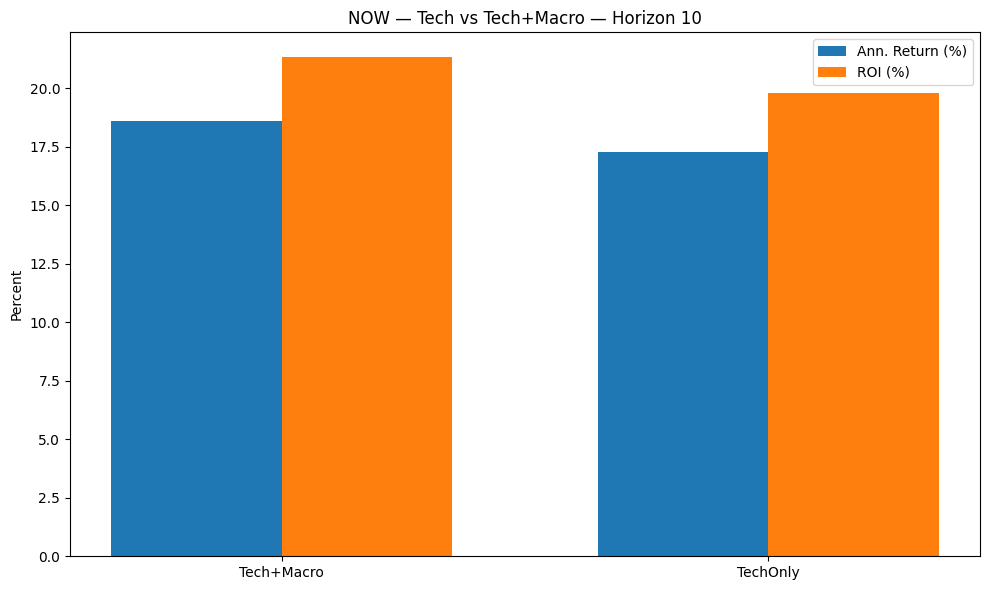

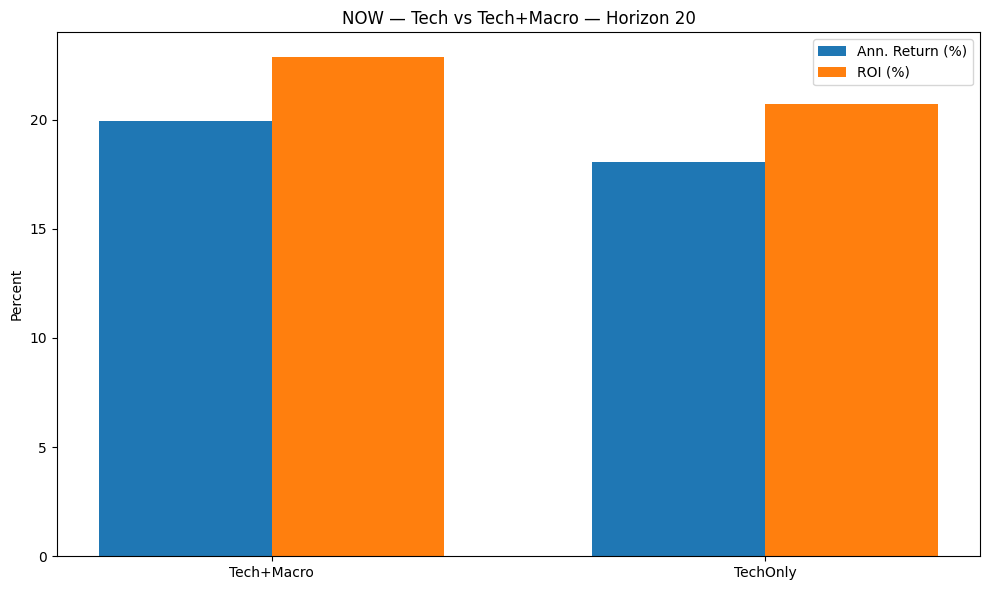

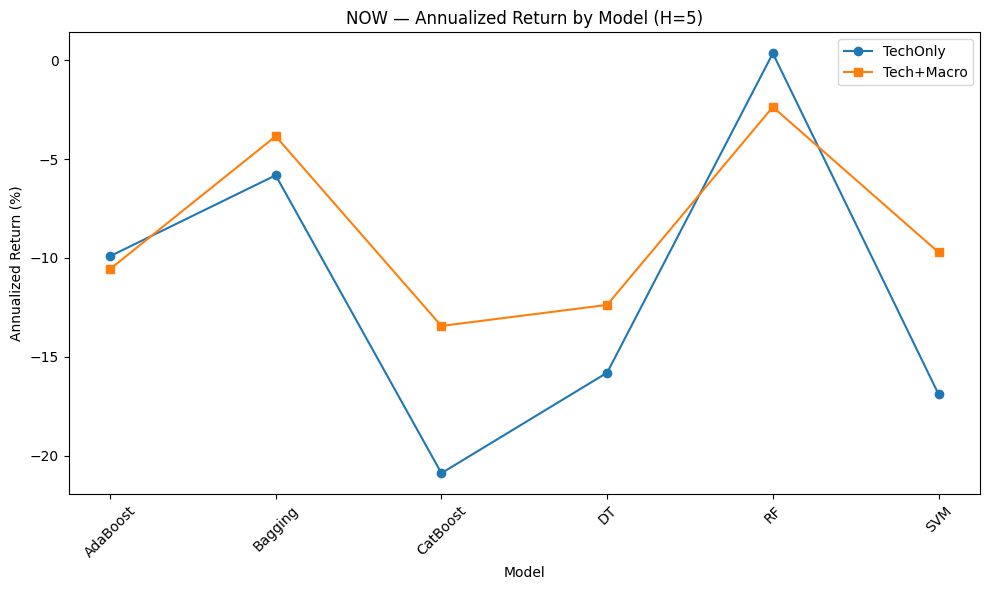

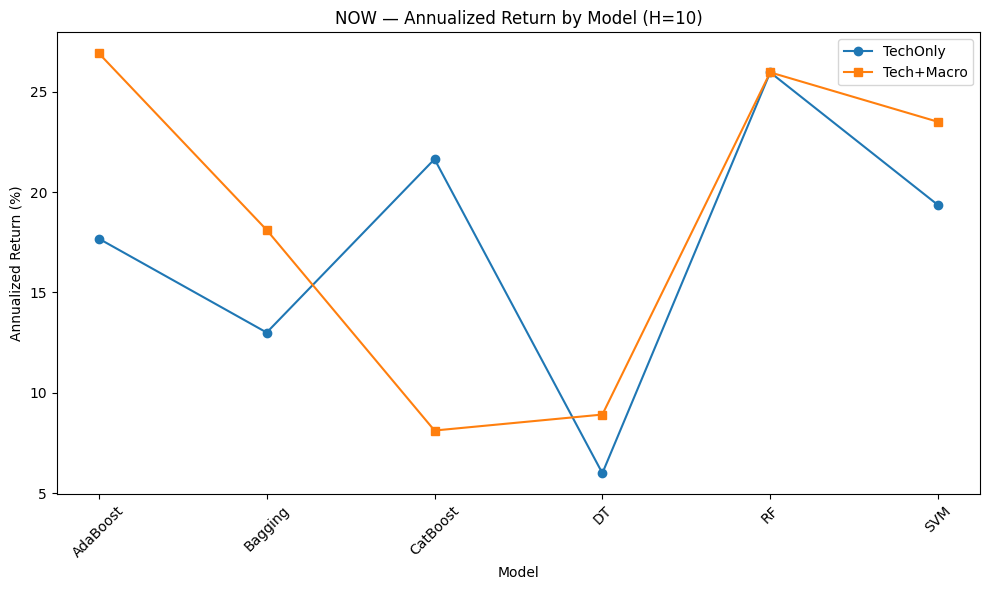

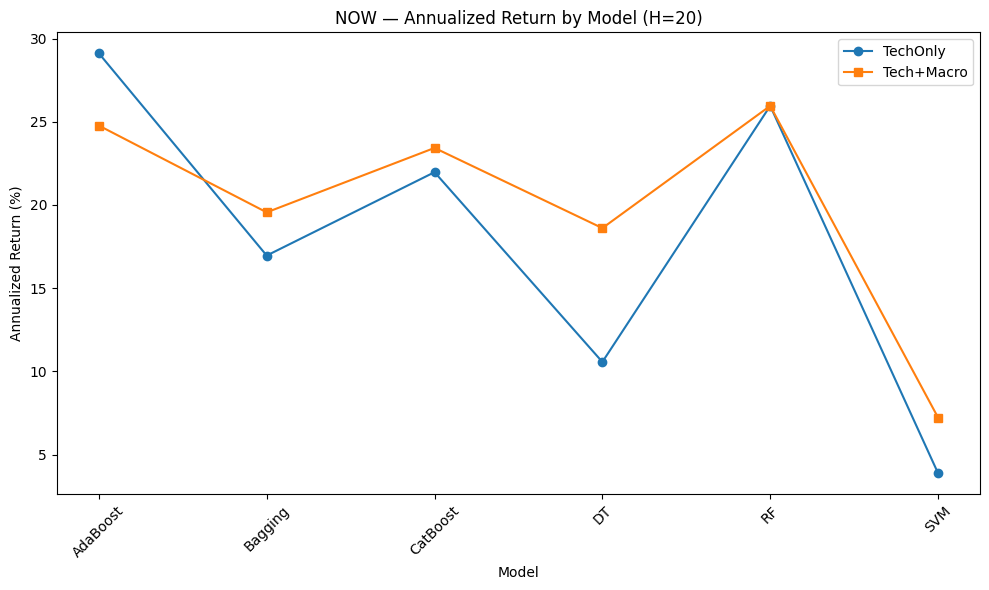


Best Tech+Macro for NOW, H=5: RF, Ann.Return=-2.37%, ROI=-2.67%


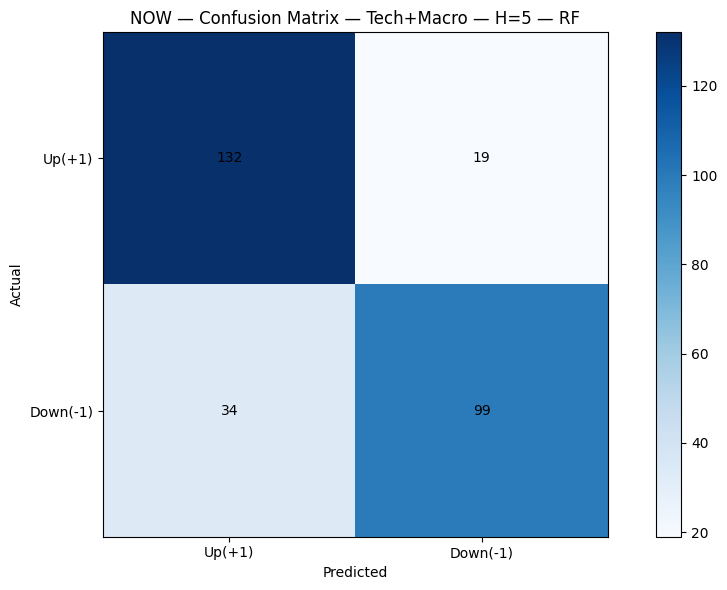

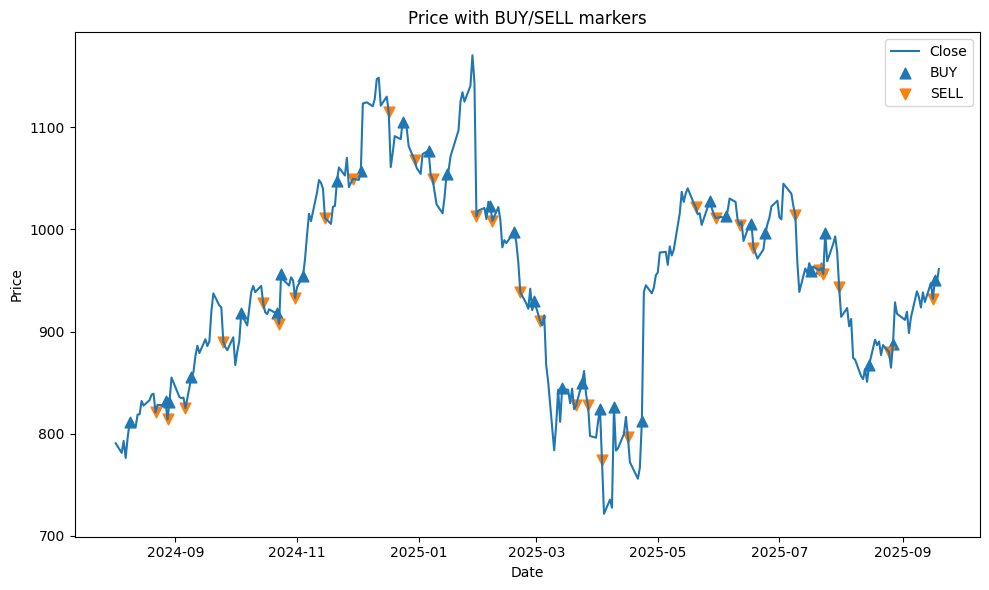

NOW — Trade log (first 25 rows) — Tech+Macro — H=5 — RF


Date   Close  Pred_Sign  Position Action           Cash      Shares  \
0  2024-08-02  790.64         -1         0   CASH  100000.000000    0.000000   
1  2024-08-05  781.27         -1         0   CASH  100000.000000    0.000000   
2  2024-08-06  792.95         -1         0   CASH  100000.000000    0.000000   
3  2024-08-07  776.28         -1         0   CASH  100000.000000    0.000000   
4  2024-08-08  796.14         -1         0   CASH  100000.000000    0.000000   
5  2024-08-09  811.08          1         1    BUY     -25.000000  123.292400   
6  2024-08-12  806.62          1         1   HOLD     -25.000000  123.292400   
7  2024-08-13  818.80          1         1   HOLD     -25.000000  123.292400   
8  2024-08-14  819.02          1         1   HOLD     -25.000000  123.292400   
9  2024-08-15  832.11          1         1   HOLD     -25.000000  123.292400   
10 2024-08-16  827.56          1         1   HOLD     -25.000000  123.292400   
11 2024-08-19  832.88          1         1   HOLD     -25.000000  123.292400   
12 2024-08-20  838.22          1         1   HOLD     -25.000000  123.292400   
13 2024-08-21  839.18          1         1   HOLD     -25.000000  123.292400   
14 2024-08-22  820.93         -1         0   SELL  101189.126535    0.000000   
15 2024-08-23  828.27         -1         0   CASH  101189.126535    0.000000   
16 2024-08-26  827.86         -1         0   CASH  101189.126535    0.000000   
17 2024-08-27  831.74          1         1    BUY     -25.297282  121.659565   
18 2024-08-28  814.11         -1         0   SELL   99019.507338    0.000000   
19 2024-08-29  831.27          1         1    BUY     -24.754877  119.118346   
20 2024-08-30  855.00          1         1   HOLD     -24.754877  119.118346   
21 2024-09-03  835.86          1         1   HOLD     -24.754877  119.118346   
22 2024-09-04  834.83          1         1   HOLD     -24.754877  119.118346   
23 2024-09-05  835.40          1         1   HOLD     -24.754877  119.118346   
24 2024-09-06  825.04         -1         0   SELL   98252.830694    0.000000   

           Equity  
0   100000.000000  
1   100000.000000  
2   100000.000000  
3   100000.000000  
4   100000.000000  
5    99975.000000  
6    99425.115895  
7   100926.817330  
8   100953.941658  
9   102567.839177  
10  102006.858756  
11  102662.774326  
12  103321.155743  
13  103439.516447  
14  101189.126535  
15  101189.126535  
16  101189.126535  
17  101163.829253  
18   99019.507338  
19   98994.752461  
20  101821.430808  
21   99541.505669  
22   99418.813772  
23   99486.711230  
24   98252.830694


Best Tech+Macro for NOW, H=10: AdaBoost, Ann.Return=26.92%, ROI=30.96%


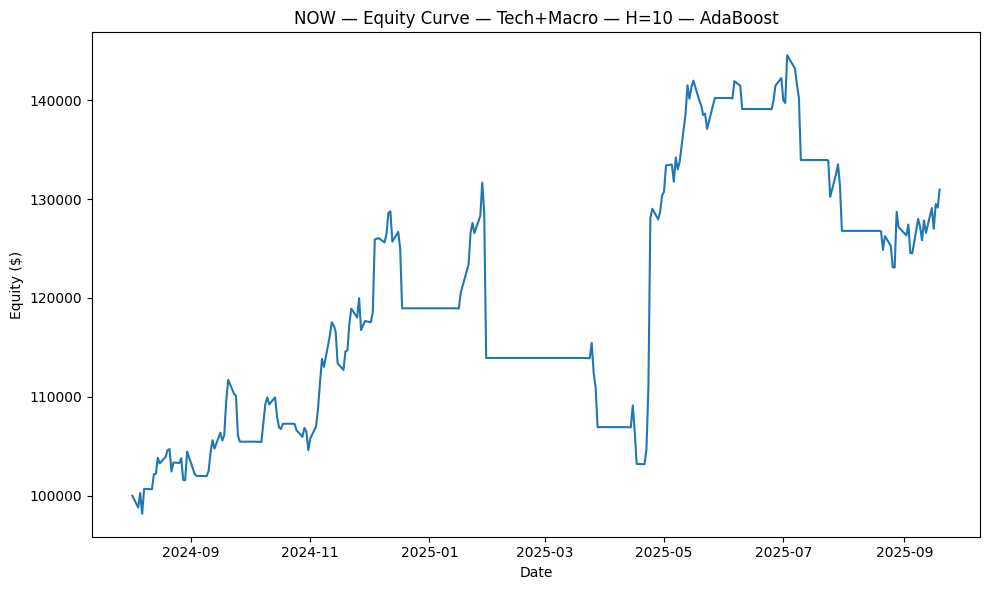

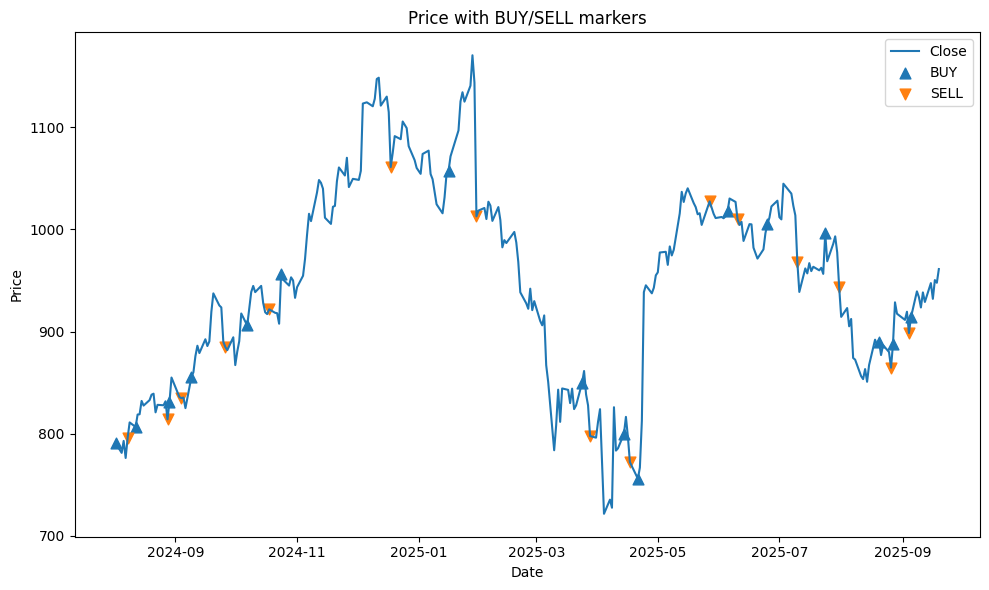

NOW — Trade log (first 25 rows) — Tech+Macro — H=10 — AdaBoost


Date   Close  Pred_Sign  Position Action           Cash      Shares  \
0  2024-08-02  790.64          1         1    BUY     -25.000000  126.479814   
1  2024-08-05  781.27          1         1   HOLD     -25.000000  126.479814   
2  2024-08-06  792.95          1         1   HOLD     -25.000000  126.479814   
3  2024-08-07  776.28          1         1   HOLD     -25.000000  126.479814   
4  2024-08-08  796.14         -1         0   SELL  100670.465066    0.000000   
5  2024-08-09  811.08         -1         0   CASH  100670.465066    0.000000   
6  2024-08-12  806.62          1         1    BUY     -25.167616  124.805317   
7  2024-08-13  818.80          1         1   HOLD     -25.167616  124.805317   
8  2024-08-14  819.02          1         1   HOLD     -25.167616  124.805317   
9  2024-08-15  832.11          1         1   HOLD     -25.167616  124.805317   
10 2024-08-16  827.56          1         1   HOLD     -25.167616  124.805317   
11 2024-08-19  832.88          1         1   HOLD     -25.167616  124.805317   
12 2024-08-20  838.22          1         1   HOLD     -25.167616  124.805317   
13 2024-08-21  839.18          1         1   HOLD     -25.167616  124.805317   
14 2024-08-22  820.93          1         1   HOLD     -25.167616  124.805317   
15 2024-08-23  828.27          1         1   HOLD     -25.167616  124.805317   
16 2024-08-26  827.86          1         1   HOLD     -25.167616  124.805317   
17 2024-08-27  831.74          1         1   HOLD     -25.167616  124.805317   
18 2024-08-28  814.11         -1         0   SELL  101579.855579    0.000000   
19 2024-08-29  831.27          1         1    BUY     -25.394964  122.198390   
20 2024-08-30  855.00          1         1   HOLD     -25.394964  122.198390   
21 2024-09-03  835.86          1         1   HOLD     -25.394964  122.198390   
22 2024-09-04  834.83         -1         0   SELL  101989.378126    0.000000   
23 2024-09-05  835.40         -1         0   CASH  101989.378126    0.000000   
24 2024-09-06  825.04         -1         0   CASH  101989.378126    0.000000   

           Equity  
0    99975.000000  
1    98789.884144  
2   100267.168370  
3    98158.749874  
4   100670.465066  
5   100670.465066  
6   100645.297450  
7   102165.426215  
8   102192.883385  
9   103826.584989  
10  103258.720795  
11  103922.685083  
12  104589.145478  
13  104708.958582  
14  102431.261541  
15  103347.332570  
16  103296.162390  
17  103780.407021  
18  101579.855579  
19  101554.460615  
20  104454.228407  
21  102115.351225  
22  101989.378126  
23  101989.378126  
24  101989.378126


Best Tech+Macro for NOW, H=20: RF, Ann.Return=25.96%, ROI=29.84%


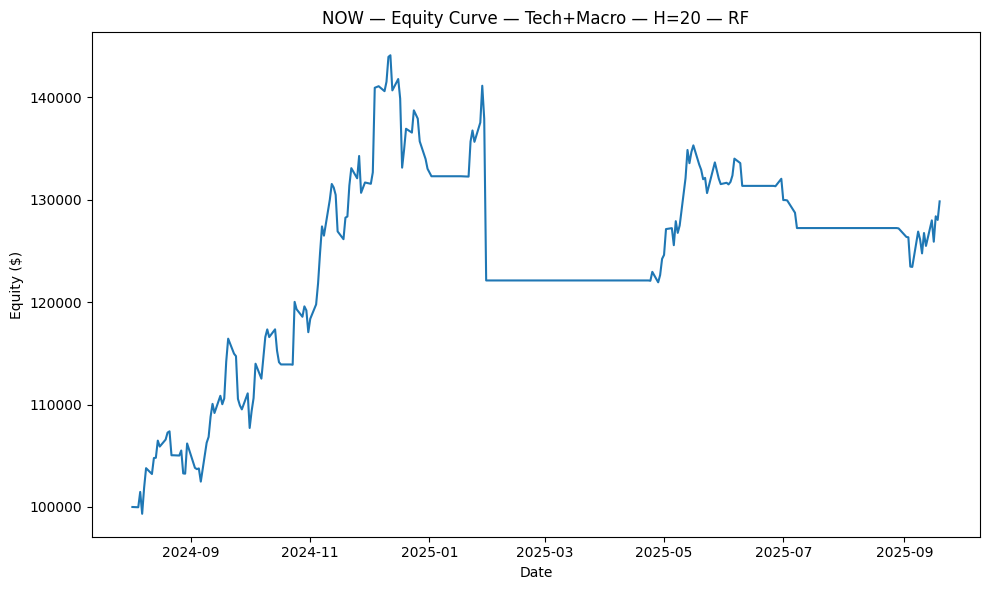

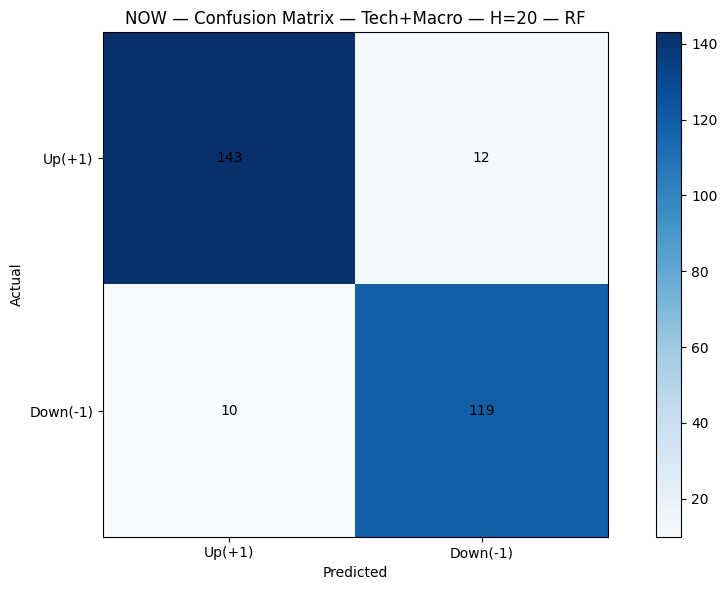

NOW — Trade log (first 25 rows) — Tech+Macro — H=20 — RF


Date   Close  Pred_Sign  Position Action           Cash      Shares  \
0  2024-08-02  790.64         -1         0   CASH  100000.000000    0.000000   
1  2024-08-05  781.27          1         1    BUY     -25.000000  127.996723   
2  2024-08-06  792.95          1         1   HOLD     -25.000000  127.996723   
3  2024-08-07  776.28          1         1   HOLD     -25.000000  127.996723   
4  2024-08-08  796.14          1         1   HOLD     -25.000000  127.996723   
5  2024-08-09  811.08          1         1   HOLD     -25.000000  127.996723   
6  2024-08-12  806.62          1         1   HOLD     -25.000000  127.996723   
7  2024-08-13  818.80          1         1   HOLD     -25.000000  127.996723   
8  2024-08-14  819.02          1         1   HOLD     -25.000000  127.996723   
9  2024-08-15  832.11          1         1   HOLD     -25.000000  127.996723   
10 2024-08-16  827.56          1         1   HOLD     -25.000000  127.996723   
11 2024-08-19  832.88          1         1   HOLD     -25.000000  127.996723   
12 2024-08-20  838.22          1         1   HOLD     -25.000000  127.996723   
13 2024-08-21  839.18          1         1   HOLD     -25.000000  127.996723   
14 2024-08-22  820.93         -1         0   SELL  105050.080958    0.000000   
15 2024-08-23  828.27         -1         0   CASH  105050.080958    0.000000   
16 2024-08-26  827.86          1         1    BUY     -26.262520  126.893534   
17 2024-08-27  831.74          1         1   HOLD     -26.262520  126.893534   
18 2024-08-28  814.11         -1         0   SELL  103279.468543    0.000000   
19 2024-08-29  831.27          1         1    BUY     -25.819867  124.242988   
20 2024-08-30  855.00          1         1   HOLD     -25.819867  124.242988   
21 2024-09-03  835.86          1         1   HOLD     -25.819867  124.242988   
22 2024-09-04  834.83          1         1   HOLD     -25.819867  124.242988   
23 2024-09-05  835.40          1         1   HOLD     -25.819867  124.242988   
24 2024-09-06  825.04          1         1   HOLD     -25.819867  124.242988   

           Equity  
0   100000.000000  
1    99975.000000  
2   101470.001728  
3    99336.296351  
4   101878.311275  
5   103790.582321  
6   103219.716935  
7   104778.717025  
8   104806.876304  
9   106482.353412  
10  105899.968321  
11  106580.910889  
12  107264.413391  
13  107387.290245  
14  105050.080958  
15  105050.080958  
16  105023.818438  
17  105516.165349  
18  103279.468543  
19  103253.648676  
20  106201.934779  
21  103823.923991  
22  103695.953713  
23  103766.772216  
24  102479.614862

/tmp/ipython-input-1667154152.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


In [ ]:
res_NOW = run_for_stock("NOW")



==================== NVDA ====================

Feature set: TechOnly  (#features = 38)
  H=5, Model=DT, FS=TechOnly done.
  H=5, Model=SVM, FS=TechOnly done.
  H=5, Model=Bagging, FS=TechOnly done.
  H=5, Model=RF, FS=TechOnly done.
  H=5, Model=AdaBoost, FS=TechOnly done.
  H=5, Model=CatBoost, FS=TechOnly done.
  H=10, Model=DT, FS=TechOnly done.
  H=10, Model=SVM, FS=TechOnly done.
  H=10, Model=Bagging, FS=TechOnly done.
  H=10, Model=RF, FS=TechOnly done.
  H=10, Model=AdaBoost, FS=TechOnly done.
  H=10, Model=CatBoost, FS=TechOnly done.
  H=20, Model=DT, FS=TechOnly done.
  H=20, Model=SVM, FS=TechOnly done.
  H=20, Model=Bagging, FS=TechOnly done.
  H=20, Model=RF, FS=TechOnly done.
  H=20, Model=AdaBoost, FS=TechOnly done.
  H=20, Model=CatBoost, FS=TechOnly done.

Feature set: Tech+Macro  (#features = 43)
  H=5, Model=DT, FS=Tech+Macro done.
  H=5, Model=SVM, FS=Tech+Macro done.
  H=5, Model=Bagging, FS=Tech+Macro done.
  H=5, Model=RF, FS=Tech+Macro done.
  H=5, Model=AdaBo

Ticker  FeatureSet  Horizon     Model       MAE      RMSE  Accuracy  \
0    NVDA  Tech+Macro        5  AdaBoost  1.040829  1.293645  0.834507   
1    NVDA  Tech+Macro        5   Bagging  1.080025  1.329567  0.841549   
2    NVDA  Tech+Macro        5  CatBoost  1.071623  1.306824  0.753521   
3    NVDA  Tech+Macro        5        DT  1.383318  1.718366  0.637324   
4    NVDA  Tech+Macro        5        RF  1.026184  1.268704  0.841549   
5    NVDA  Tech+Macro        5       SVM  1.167599  1.466740  0.760563   
6    NVDA  Tech+Macro       10  AdaBoost  0.481523  0.634627  0.869718   
7    NVDA  Tech+Macro       10   Bagging  0.467438  0.607887  0.883803   
8    NVDA  Tech+Macro       10  CatBoost  0.529294  0.662717  0.859155   
9    NVDA  Tech+Macro       10        DT  0.644541  0.815954  0.809859   
10   NVDA  Tech+Macro       10        RF  0.467323  0.604576  0.876761   
11   NVDA  Tech+Macro       10       SVM  0.605677  0.766909  0.792254   
12   NVDA  Tech+Macro       20  AdaBoost  0.246468  0.330421  0.852113   
13   NVDA  Tech+Macro       20   Bagging  0.236158  0.309096  0.880282   
14   NVDA  Tech+Macro       20  CatBoost  0.265456  0.336332  0.859155   
15   NVDA  Tech+Macro       20        DT  0.303631  0.381167  0.873239   
16   NVDA  Tech+Macro       20        RF  0.233397  0.310518  0.890845   
17   NVDA  Tech+Macro       20       SVM  0.357316  0.448010  0.809859   
18   NVDA    TechOnly        5  AdaBoost  1.042135  1.296566  0.834507   
19   NVDA    TechOnly        5   Bagging  1.062295  1.310132  0.848592   
20   NVDA    TechOnly        5  CatBoost  1.119200  1.350678  0.728873   
21   NVDA    TechOnly        5        DT  1.509290  1.818548  0.609155   
22   NVDA    TechOnly        5        RF  1.025217  1.268702  0.841549   
23   NVDA    TechOnly        5       SVM  1.183721  1.479839  0.771127   
24   NVDA    TechOnly       10  AdaBoost  0.483266  0.637455  0.869718   
25   NVDA    TechOnly       10   Bagging  0.462069  0.603183  0.887324   
26   NVDA    TechOnly       10  CatBoost  0.530304  0.663401  0.852113   
27   NVDA    TechOnly       10        DT  0.599630  0.766051  0.816901   
28   NVDA    TechOnly       10        RF  0.465519  0.603636  0.880282   
29   NVDA    TechOnly       10       SVM  0.621257  0.784080  0.792254   
30   NVDA    TechOnly       20  AdaBoost  0.239264  0.322545  0.855634   
31   NVDA    TechOnly       20   Bagging  0.235487  0.307212  0.880282   
32   NVDA    TechOnly       20  CatBoost  0.277191  0.352565  0.862676   
33   NVDA    TechOnly       20        DT  0.319311  0.398264  0.862676   
34   NVDA    TechOnly       20        RF  0.233411  0.310920  0.890845   
35   NVDA    TechOnly       20       SVM  0.367430  0.463299  0.809859   

    Precision    Recall        F1  TotalReturn_%      ROI_%  \
0    0.810256  0.940476  0.870523      28.374959  28.374959   
1    0.868263  0.863095  0.865672      39.239490  39.239490   
2    0.908333  0.648810  0.756944      21.502778  21.502778   
3    0.707006  0.660714  0.683077      95.842648  95.842648   
4    0.843575  0.898810  0.870317      24.430254  24.430254   
5    0.797619  0.797619  0.797619      32.727884  32.727884   
6    0.879781  0.914773  0.896936      17.633244  17.633244   
7    0.918129  0.892045  0.904899      25.188301  25.188301   
8    0.930380  0.835227  0.880240      12.205436  12.205436   
9    0.871951  0.812500  0.841176      27.184579  27.184579   
10   0.893855  0.909091  0.901408      12.449999  12.449999   
11   0.823204  0.846591  0.834734      29.479998  29.479998   
12   0.963504  0.781065  0.862745       7.480078   7.480078   
13   0.935484  0.857988  0.895062      60.734913  60.734913   
14   0.970803  0.786982  0.869281      19.584271  19.584271   
15   0.940397  0.840237  0.887500      48.980760  48.980760   
16   0.910714  0.905325  0.908012       1.761310   1.761310   
17   0.848485  0.828402  0.838323      40.429221  40.429221   
18   0.810256  0.940476  0.870523      28.374959  28.374959   
19  


Average performance by FeatureSet & Horizon:


MAE    RMSE  Accuracy      F1    ROI_%  \
FeatureSet Horizon                                              
Tech+Macro 5        1.1283  1.3973    0.7782  0.8074  40.3530   
           10       0.5326  0.6821    0.8486  0.8766  20.6903   
           20       0.2737  0.3526    0.8609  0.8768  29.8284   
TechOnly   5        1.1570  1.4207    0.7723  0.8014  37.2070   
           10       0.5270  0.6763    0.8498  0.8771  22.7936   
           20       0.2787  0.3591    0.8603  0.8775  28.3079   

                    AnnualizedReturn_%  MaxDrawdown_%  
FeatureSet Horizon                                     
Tech+Macro 5                   34.7227       -27.3657  
           10                  18.0609       -39.2522  
           20                  25.7671       -28.4807  
TechOnly   5                   32.1066       -27.6251  
           10                  19.8709       -39.1891  
           20                  24.4466       -29.4455


Average performance by FeatureSet (all horizons & models):


MAE    RMSE  Accuracy      F1    ROI_%  AnnualizedReturn_%  \
FeatureSet                                                                  
Tech+Macro  0.6449  0.8107    0.8292  0.8536  30.2906             26.1835   
TechOnly    0.6542  0.8187    0.8275  0.8520  29.4362             25.4747   

            MaxDrawdown_%  
FeatureSet                 
Tech+Macro       -31.6995  
TechOnly         -32.0866

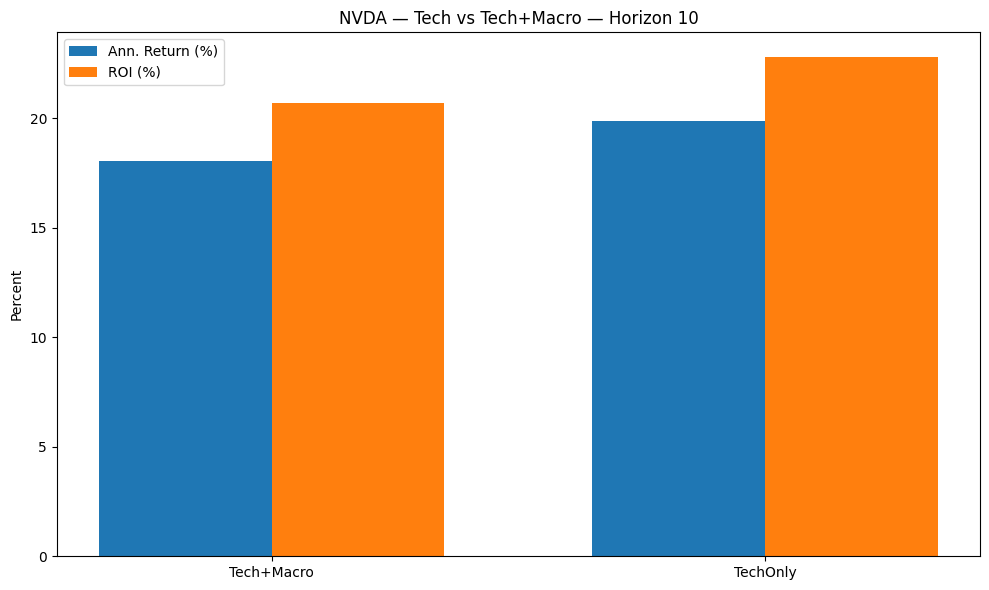

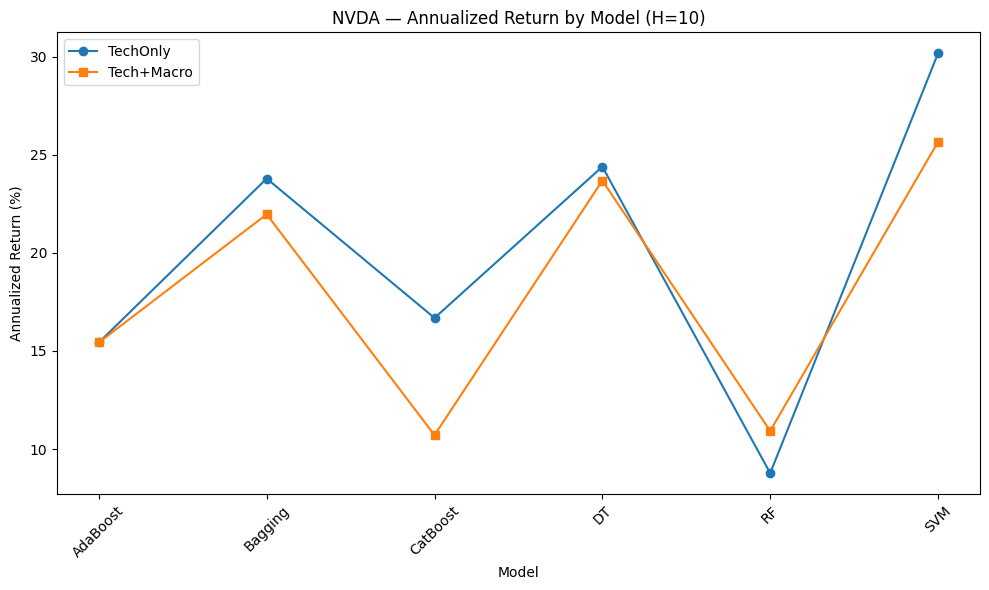


Best Tech+Macro for NVDA, H=5: DT, Ann.Return=81.13%, ROI=95.84%


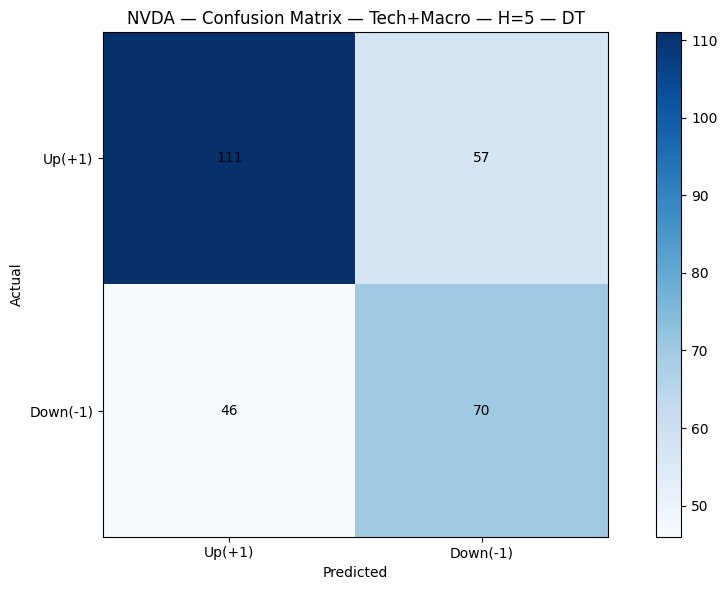

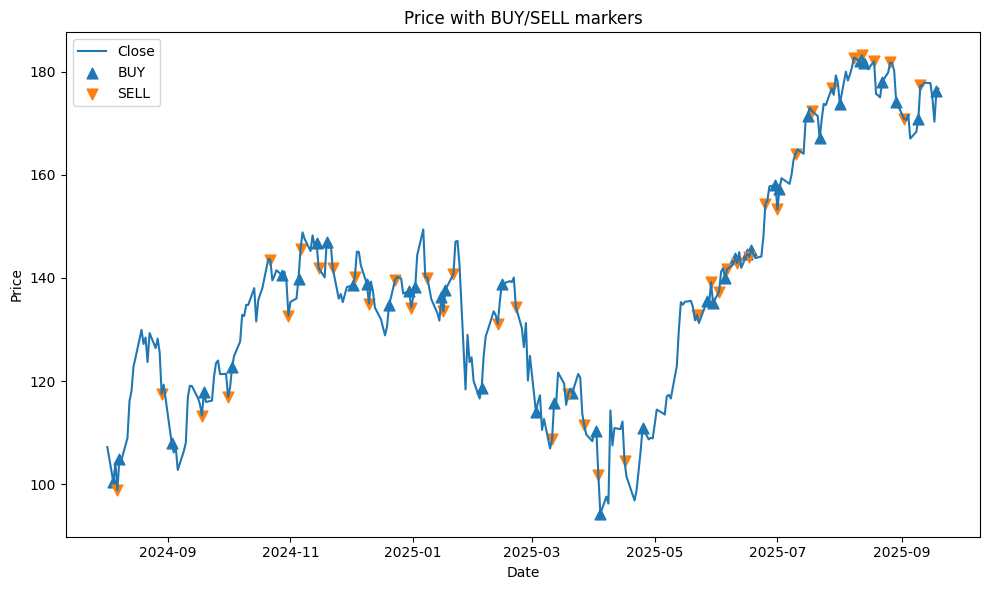

NVDA — Trade log (first 25 rows) — Tech+Macro — H=5 — DT


Date       Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  107.230070         -1         0   CASH  100000.000000   
1  2024-08-05  100.412610          1         1    BUY     -25.000000   
2  2024-08-06  104.211200          1         1   HOLD     -25.000000   
3  2024-08-07   98.873190         -1         0   SELL   98442.288974   
4  2024-08-08  104.930930          1         1    BUY     -24.610572   
5  2024-08-09  104.711010          1         1   HOLD     -24.610572   
6  2024-08-12  108.979416          1         1   HOLD     -24.610572   
7  2024-08-13  116.096770          1         1   HOLD     -24.610572   
8  2024-08-14  118.036064          1         1   HOLD     -24.610572   
9  2024-08-15  122.814270          1         1   HOLD     -24.610572   
10 2024-08-16  124.533630          1         1   HOLD     -24.610572   
11 2024-08-19  129.951610          1         1   HOLD     -24.610572   
12 2024-08-20  127.202644          1         1   HOLD     -24.610572   
13 2024-08-21  128.452180          1         1   HOLD     -24.610572   
14 2024-08-22  123.693940          1         1   HOLD     -24.610572   
15 2024-08-23  129.321840          1         1   HOLD     -24.610572   
16 2024-08-26  126.412940          1         1   HOLD     -24.610572   
17 2024-08-27  128.252260          1         1   HOLD     -24.610572   
18 2024-08-28  125.563255          1         1   HOLD     -24.610572   
19 2024-08-29  117.546234         -1         0   SELL  110249.927787   
20 2024-08-30  119.325580         -1         0   CASH  110249.927787   
21 2024-09-03  107.959800          1         1    BUY     -27.562482   
22 2024-09-04  106.170480          1         1   HOLD     -27.562482   
23 2024-09-05  107.170105          1         1   HOLD     -27.562482   
24 2024-09-06  102.791725          1         1   HOLD     -27.562482   

         Shares         Equity  
0      0.000000  100000.000000  
1    995.890855   99975.000000  
2    995.890855  103757.981042  
3      0.000000   98442.288974  
4    938.162742   98417.678402  
5    938.162742   98211.357652  
6    938.162742  102215.817127  
7    938.162742  108893.053469  
8    938.162742  110712.426845  
9    938.162742  115195.161686  
10   938.162742  116808.201178  
11   938.162742  121891.148149  
12   938.162742  119312.170669  
13   938.162742  120484.438789  
14   938.162742  116020.435305  
15   938.162742  121300.321399  
16   938.162742  118571.299800  
17   938.162742  120296.881294  
18   938.162742  117774.156991  
19     0.000000  110249.927787  
20     0.000000  110249.927787  
21  1021.212783  110222.365305  
22  1021.212783  108395.088849  
23  1021.212783  109415.918677  
24  1021.212783  104944.661053


Best Tech+Macro for NVDA, H=10: SVM, Ann.Return=25.65%, ROI=29.48%


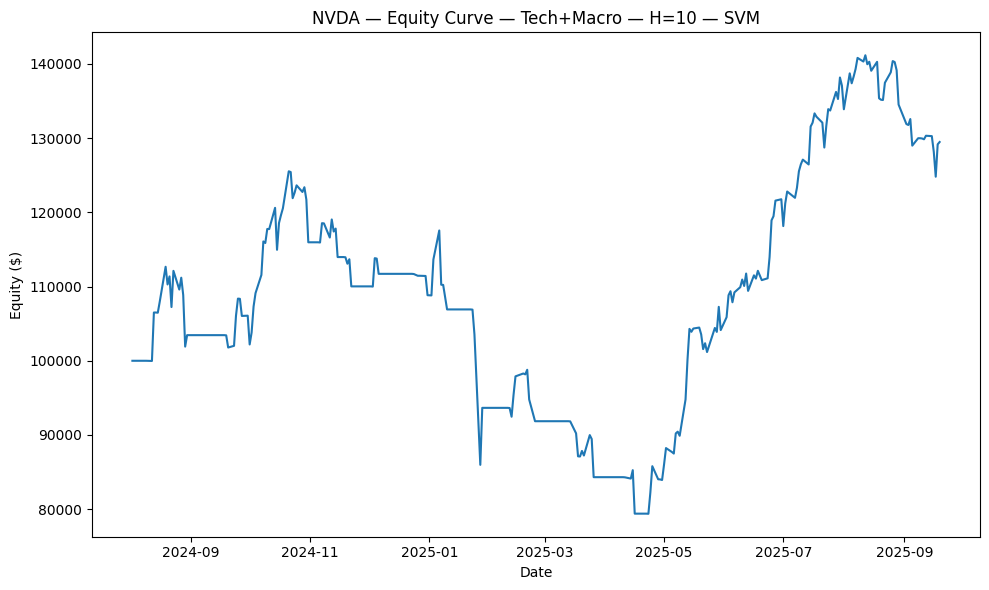

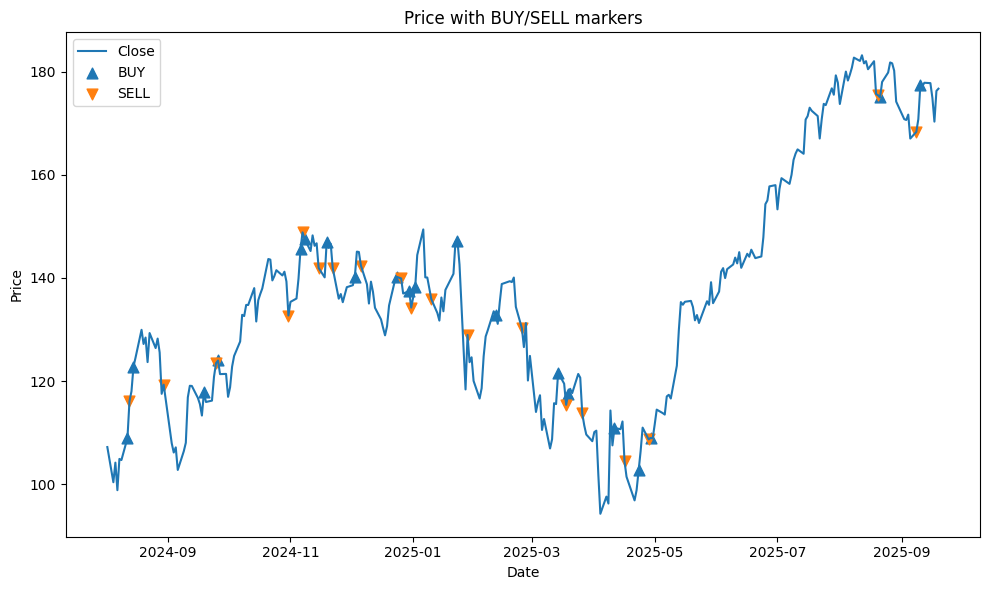

NVDA — Trade log (first 25 rows) — Tech+Macro — H=10 — SVM


Date       Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  107.230070         -1         0   CASH  100000.000000   
1  2024-08-05  100.412610         -1         0   CASH  100000.000000   
2  2024-08-06  104.211200         -1         0   CASH  100000.000000   
3  2024-08-07   98.873190         -1         0   CASH  100000.000000   
4  2024-08-08  104.930930         -1         0   CASH  100000.000000   
5  2024-08-09  104.711010         -1         0   CASH  100000.000000   
6  2024-08-12  108.979416          1         1    BUY     -25.000000   
7  2024-08-13  116.096770         -1         0   SELL  106504.283164   
8  2024-08-14  118.036064         -1         0   CASH  106504.283164   
9  2024-08-15  122.814270          1         1    BUY     -26.626071   
10 2024-08-16  124.533630          1         1   HOLD     -26.626071   
11 2024-08-19  129.951610          1         1   HOLD     -26.626071   
12 2024-08-20  127.202644          1         1   HOLD     -26.626071   
13 2024-08-21  128.452180          1         1   HOLD     -26.626071   
14 2024-08-22  123.693940          1         1   HOLD     -26.626071   
15 2024-08-23  129.321840          1         1   HOLD     -26.626071   
16 2024-08-26  126.412940          1         1   HOLD     -26.626071   
17 2024-08-27  128.252260          1         1   HOLD     -26.626071   
18 2024-08-28  125.563255          1         1   HOLD     -26.626071   
19 2024-08-29  117.546234          1         1   HOLD     -26.626071   
20 2024-08-30  119.325580         -1         0   SELL  103453.028624   
21 2024-09-03  107.959800         -1         0   CASH  103453.028624   
22 2024-09-04  106.170480         -1         0   CASH  103453.028624   
23 2024-09-05  107.170105         -1         0   CASH  103453.028624   
24 2024-09-06  102.791725         -1         0   CASH  103453.028624   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4     0.000000  100000.000000  
5     0.000000  100000.000000  
6   917.604477   99975.000000  
7     0.000000  106504.283164  
8     0.000000  106504.283164  
9   867.197950  106477.657094  
10  867.197950  107968.682561  
11  867.197950  112667.143709  
12  867.197950  110283.246030  
13  867.197950  111366.841087  
14  867.197950  107240.505114  
15  867.197950  112121.008456  
16  867.197950  109598.416340  
17  867.197950  111193.470873  
18  867.197950  108861.571250  
19  867.197950  101909.227074  
20    0.000000  103453.028624  
21    0.000000  103453.028624  
22    0.000000  103453.028624  
23    0.000000  103453.028624  
24    0.000000  103453.028624


Best Tech+Macro for NVDA, H=20: Bagging, Ann.Return=52.11%, ROI=60.73%


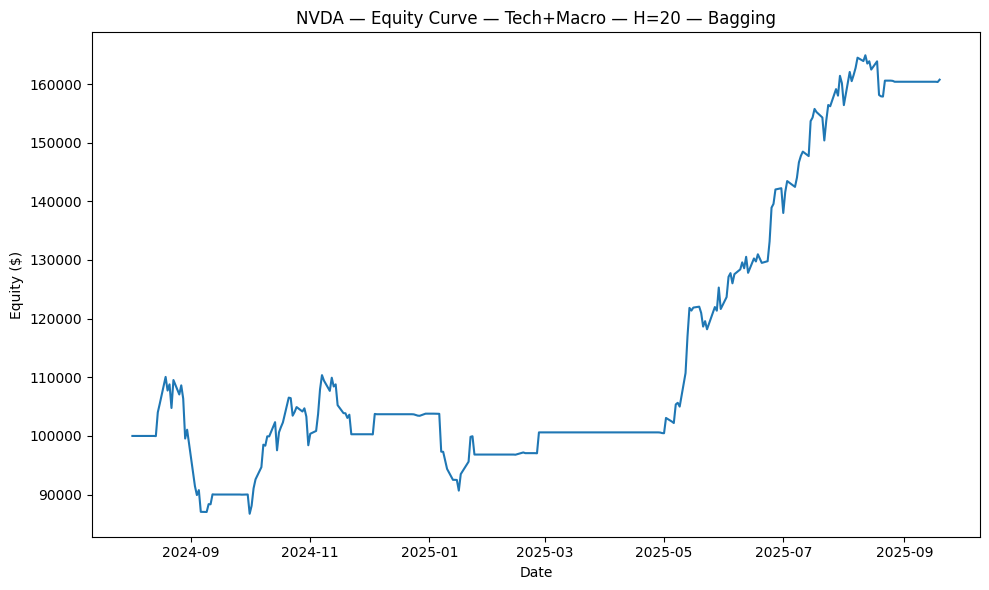

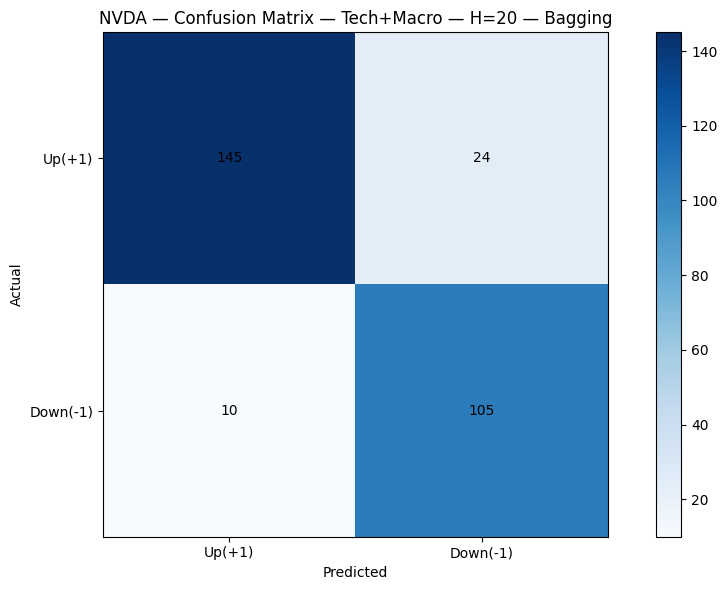

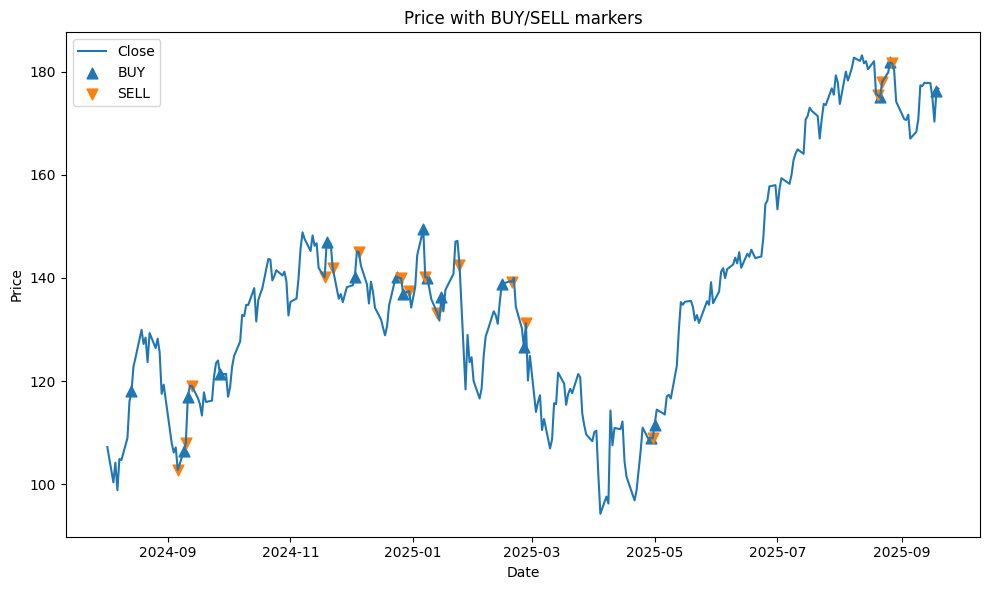

NVDA — Trade log (first 25 rows) — Tech+Macro — H=20 — Bagging


Date       Close  Pred_Sign  Position Action          Cash    Shares  \
0  2024-08-02  107.230070         -1         0   CASH  100000.00000    0.0000   
1  2024-08-05  100.412610         -1         0   CASH  100000.00000    0.0000   
2  2024-08-06  104.211200         -1         0   CASH  100000.00000    0.0000   
3  2024-08-07   98.873190         -1         0   CASH  100000.00000    0.0000   
4  2024-08-08  104.930930         -1         0   CASH  100000.00000    0.0000   
5  2024-08-09  104.711010         -1         0   CASH  100000.00000    0.0000   
6  2024-08-12  108.979416         -1         0   CASH  100000.00000    0.0000   
7  2024-08-13  116.096770         -1         0   CASH  100000.00000    0.0000   
8  2024-08-14  118.036064          1         1    BUY     -25.00000  847.1987   
9  2024-08-15  122.814270          1         1   HOLD     -25.00000  847.1987   
10 2024-08-16  124.533630          1         1   HOLD     -25.00000  847.1987   
11 2024-08-19  129.951610          1         1   HOLD     -25.00000  847.1987   
12 2024-08-20  127.202644          1         1   HOLD     -25.00000  847.1987   
13 2024-08-21  128.452180          1         1   HOLD     -25.00000  847.1987   
14 2024-08-22  123.693940          1         1   HOLD     -25.00000  847.1987   
15 2024-08-23  129.321840          1         1   HOLD     -25.00000  847.1987   
16 2024-08-26  126.412940          1         1   HOLD     -25.00000  847.1987   
17 2024-08-27  128.252260          1         1   HOLD     -25.00000  847.1987   
18 2024-08-28  125.563255          1         1   HOLD     -25.00000  847.1987   
19 2024-08-29  117.546234          1         1   HOLD     -25.00000  847.1987   
20 2024-08-30  119.325580          1         1   HOLD     -25.00000  847.1987   
21 2024-09-03  107.959800          1         1   HOLD     -25.00000  847.1987   
22 2024-09-04  106.170480          1         1   HOLD     -25.00000  847.1987   
23 2024-09-05  107.170105          1         1   HOLD     -25.00000  847.1987   
24 2024-09-06  102.791725         -1         0   SELL   87063.24456    0.0000   

           Equity  
0   100000.000000  
1   100000.000000  
2   100000.000000  
3   100000.000000  
4   100000.000000  
5   100000.000000  
6   100000.000000  
7   100000.000000  
8    99975.000000  
9   104023.089913  
10  105479.729470  
11  110069.835084  
12  107740.914661  
13  108799.519937  
14  104768.345193  
15  109536.294758  
16  107071.878459  
17  108630.147972  
18  106352.026432  
19   99560.016661  
20  101067.476279  
21   91438.402236  
22   89922.492658  
23   90769.373659  
24   87063.244560

/tmp/ipython-input-1667154152.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


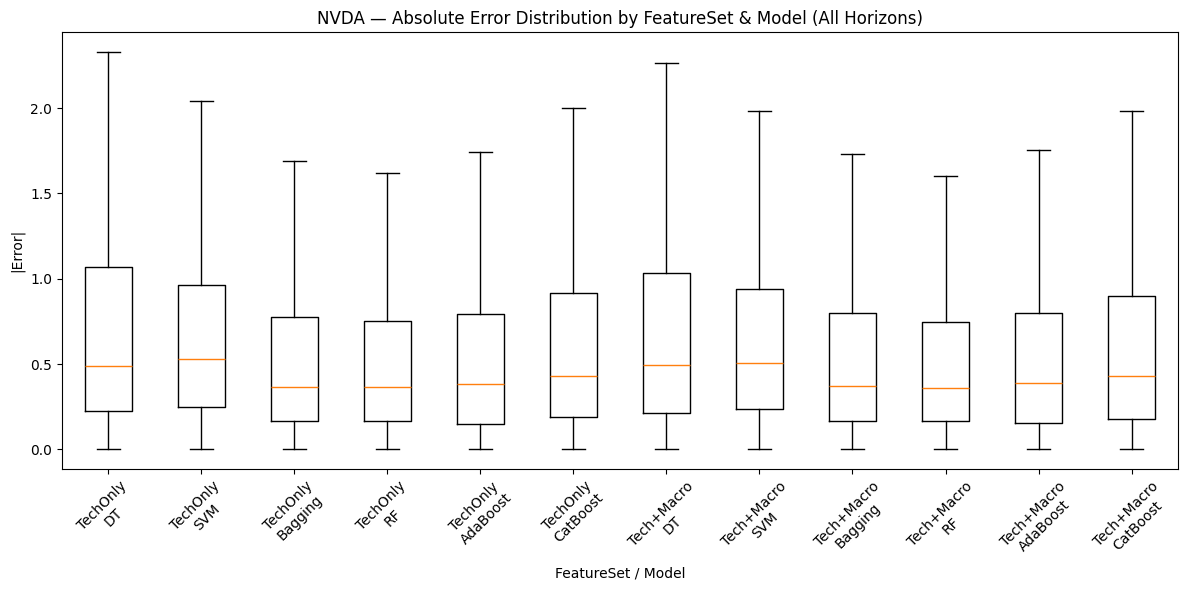

In [ ]:
res_NVDA = run_for_stock("NVDA")



==================== ORCL ====================

Feature set: TechOnly  (#features = 38)
  H=5, Model=DT, FS=TechOnly done.
  H=5, Model=SVM, FS=TechOnly done.
  H=5, Model=Bagging, FS=TechOnly done.
  H=5, Model=RF, FS=TechOnly done.
  H=5, Model=AdaBoost, FS=TechOnly done.
  H=5, Model=CatBoost, FS=TechOnly done.
  H=10, Model=DT, FS=TechOnly done.
  H=10, Model=SVM, FS=TechOnly done.
  H=10, Model=Bagging, FS=TechOnly done.
  H=10, Model=RF, FS=TechOnly done.
  H=10, Model=AdaBoost, FS=TechOnly done.
  H=10, Model=CatBoost, FS=TechOnly done.
  H=20, Model=DT, FS=TechOnly done.
  H=20, Model=SVM, FS=TechOnly done.
  H=20, Model=Bagging, FS=TechOnly done.
  H=20, Model=RF, FS=TechOnly done.
  H=20, Model=AdaBoost, FS=TechOnly done.
  H=20, Model=CatBoost, FS=TechOnly done.

Feature set: Tech+Macro  (#features = 43)
  H=5, Model=DT, FS=Tech+Macro done.
  H=5, Model=SVM, FS=Tech+Macro done.
  H=5, Model=Bagging, FS=Tech+Macro done.
  H=5, Model=RF, FS=Tech+Macro done.
  H=5, Model=AdaBo

Ticker  FeatureSet  Horizon     Model       MAE      RMSE  Accuracy  \
0    ORCL  Tech+Macro        5  AdaBoost  1.321140  2.306157  0.799296   
1    ORCL  Tech+Macro        5   Bagging  1.264114  2.298025  0.823944   
2    ORCL  Tech+Macro        5  CatBoost  1.302704  2.396781  0.816901   
3    ORCL  Tech+Macro        5        DT  1.877092  2.933539  0.542254   
4    ORCL  Tech+Macro        5        RF  1.241019  2.278198  0.834507   
5    ORCL  Tech+Macro        5       SVM  1.715869  2.859219  0.573944   
6    ORCL  Tech+Macro       10  AdaBoost  0.778336  1.366967  0.883803   
7    ORCL  Tech+Macro       10   Bagging  0.728938  1.316768  0.908451   
8    ORCL  Tech+Macro       10  CatBoost  0.735695  1.335433  0.897887   
9    ORCL  Tech+Macro       10        DT  0.930049  1.421015  0.690141   
10   ORCL  Tech+Macro       10        RF  0.711242  1.303741  0.908451   
11   ORCL  Tech+Macro       10       SVM  1.224018  1.904702  0.633803   
12   ORCL  Tech+Macro       20  AdaBoost  0.505728  0.773102  0.943662   
13   ORCL  Tech+Macro       20   Bagging  0.497965  0.789989  0.936620   
14   ORCL  Tech+Macro       20  CatBoost  0.511955  0.772540  0.915493   
15   ORCL  Tech+Macro       20        DT  0.504735  0.771162  0.873239   
16   ORCL  Tech+Macro       20        RF  0.458925  0.740643  0.933099   
17   ORCL  Tech+Macro       20       SVM  0.903263  1.187066  0.679577   
18   ORCL    TechOnly        5  AdaBoost  1.314638  2.302741  0.809859   
19   ORCL    TechOnly        5   Bagging  1.261217  2.304498  0.830986   
20   ORCL    TechOnly        5  CatBoost  1.284176  2.343826  0.816901   
21   ORCL    TechOnly        5        DT  1.658061  2.805101  0.654930   
22   ORCL    TechOnly        5        RF  1.238685  2.275798  0.834507   
23   ORCL    TechOnly        5       SVM  1.723534  2.859543  0.626761   
24   ORCL    TechOnly       10  AdaBoost  0.774900  1.362669  0.887324   
25   ORCL    TechOnly       10   Bagging  0.722706  1.310996  0.908451   
26   ORCL    TechOnly       10  CatBoost  0.726902  1.330735  0.904930   
27   ORCL    TechOnly       10        DT  0.975525  1.491858  0.679577   
28   ORCL    TechOnly       10        RF  0.709545  1.302077  0.908451   
29   ORCL    TechOnly       10       SVM  1.220284  1.896287  0.633803   
30   ORCL    TechOnly       20  AdaBoost  0.500438  0.771423  0.936620   
31   ORCL    TechOnly       20   Bagging  0.492226  0.784879  0.936620   
32   ORCL    TechOnly       20  CatBoost  0.497929  0.761744  0.933099   
33   ORCL    TechOnly       20        DT  0.669411  1.030348  0.873239   
34   ORCL    TechOnly       20        RF  0.458942  0.740961  0.933099   
35   ORCL    TechOnly       20       SVM  0.910466  1.194321  0.690141   

    Precision    Recall        F1  TotalReturn_%       ROI_%  \
0    0.851351  0.782609  0.815534      56.838873   56.838873   
1    0.882759  0.795031  0.836601      85.324839   85.324839   
2    0.892086  0.770186  0.826667      94.004990   94.004990   
3    0.600000  0.577640  0.588608     140.733651  140.733651   
4    0.875000  0.826087  0.849840     103.845759  103.845759   
5    0.621951  0.633540  0.627692      71.871575   71.871575   
6    0.894737  0.910714  0.902655     145.369380  145.369380   
7    0.912791  0.934524  0.923529     159.729272  159.729272   
8    0.926380  0.898810  0.912387     142.244284  142.244284   
9    0.746914  0.720238  0.733333      21.664038   21.664038   
10   0.917647  0.928571  0.923077     154.203379  154.203379   
11   0.617647  1.000000  0.763636     139.374306  139.374306   
12   0.965714  0.944134  0.954802      78.391157   78.391157   
13   0.954802  0.944134  0.949438      77.201551   77.201551   
14   0.964072  0.899441  0.930636      54.486122   54.486122   
15   0.949686  0.843575  0.893491      86.843186   86.843186   
16   0.944444  0.949721  0.947075      66.917546   66.917546   
17   0.677419  0.938547  0.786885     133.578443  133.578443   
18   0.854305  0.801242  0.826923      62.023629


Average performance by FeatureSet & Horizon:


MAE    RMSE  Accuracy      F1     ROI_%  \
FeatureSet Horizon                                               
Tech+Macro 5        1.4537  2.5120    0.7318  0.7575   92.1033   
           10       0.8514  1.4414    0.8204  0.8598  127.0974   
           20       0.5638  0.8391    0.8803  0.9104   82.9030   
TechOnly   5        1.4134  2.4819    0.7623  0.7896   99.5663   
           10       0.8550  1.4491    0.8204  0.8605  126.0181   
           20       0.5882  0.8806    0.8838  0.9132   79.5637   

                    AnnualizedReturn_%  MaxDrawdown_%  
FeatureSet Horizon                                     
Tech+Macro 5                   77.8962       -23.0557  
           10                 105.8963       -25.1015  
           20                  70.3541       -20.8196  
TechOnly   5                   83.8702       -22.8320  
           10                 105.1035       -25.4784  
           20                  67.5986       -21.5679


Average performance by FeatureSet (all horizons & models):


MAE    RMSE  Accuracy      F1     ROI_%  AnnualizedReturn_%  \
FeatureSet                                                                   
Tech+Macro  0.9563  1.5975    0.8108  0.8425  100.7012             84.7155   
TechOnly    0.9522  1.6039    0.8222  0.8544  101.7160             85.5241   

            MaxDrawdown_%  
FeatureSet                 
Tech+Macro       -22.9923  
TechOnly         -23.2928

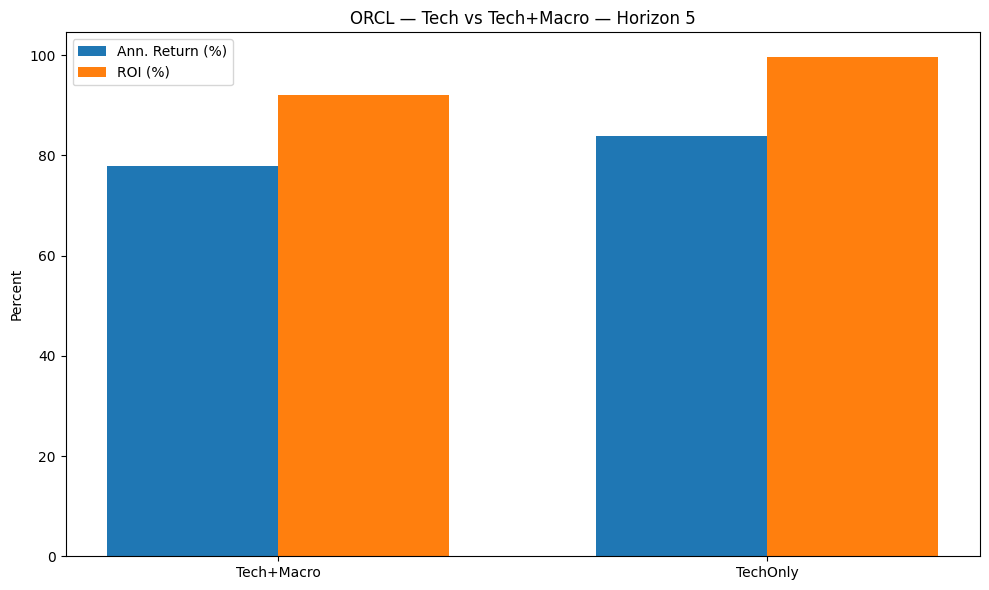

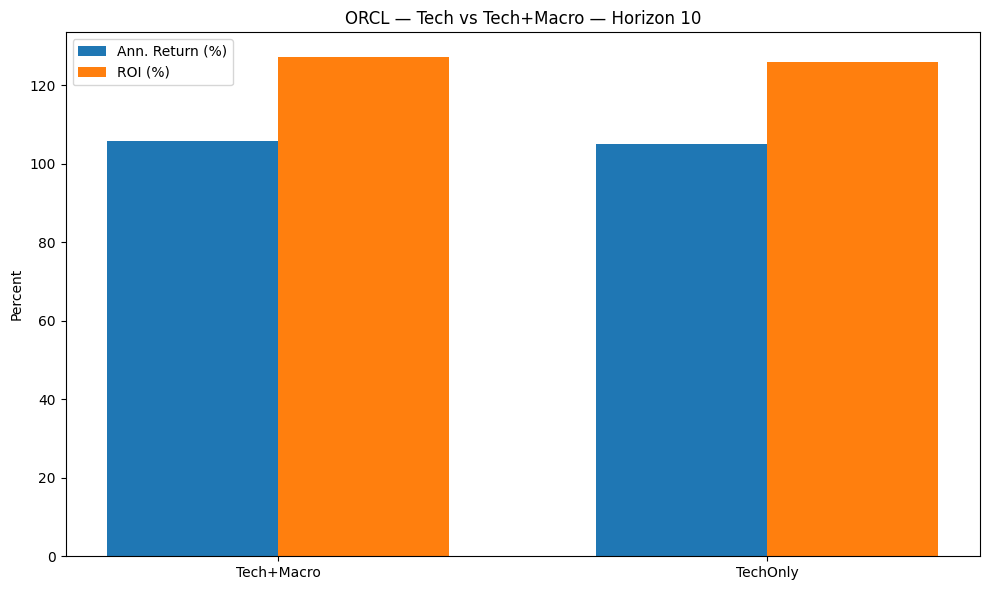

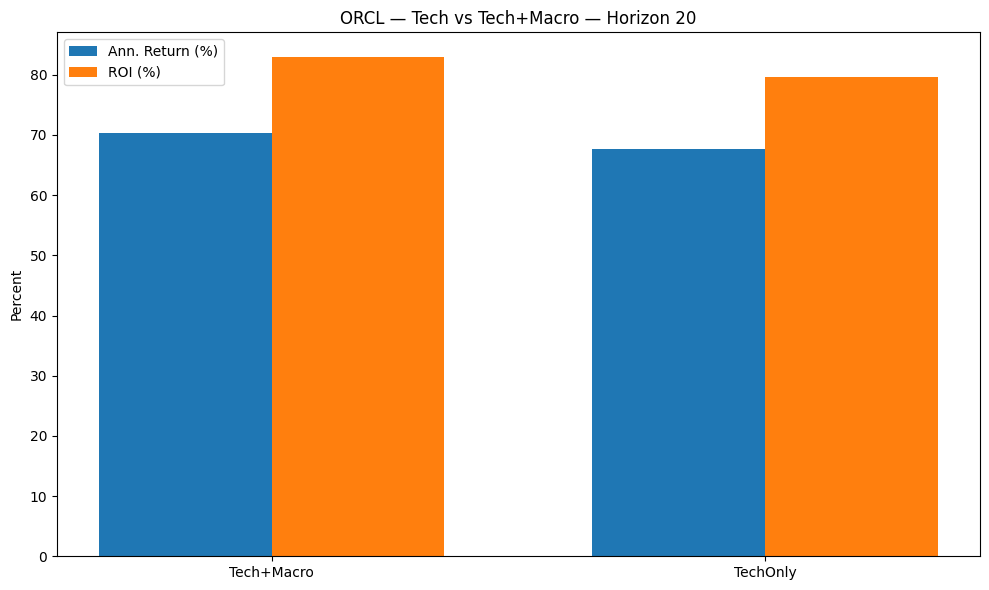

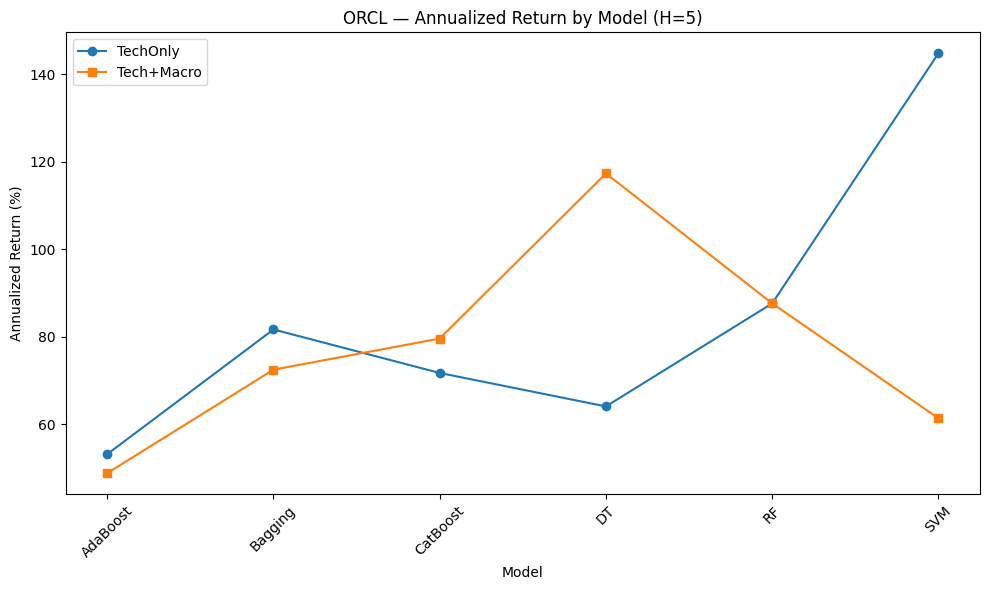

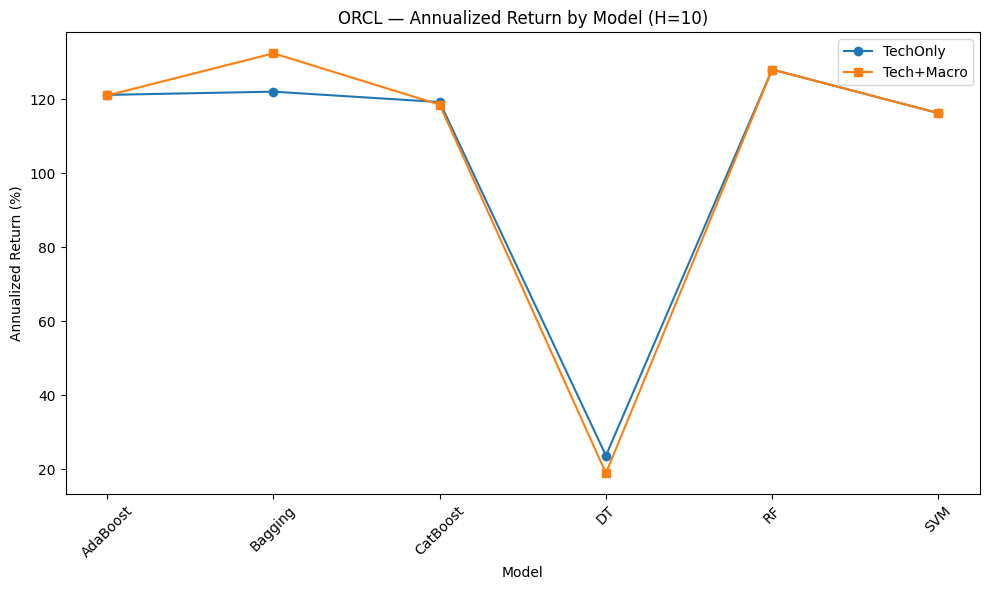

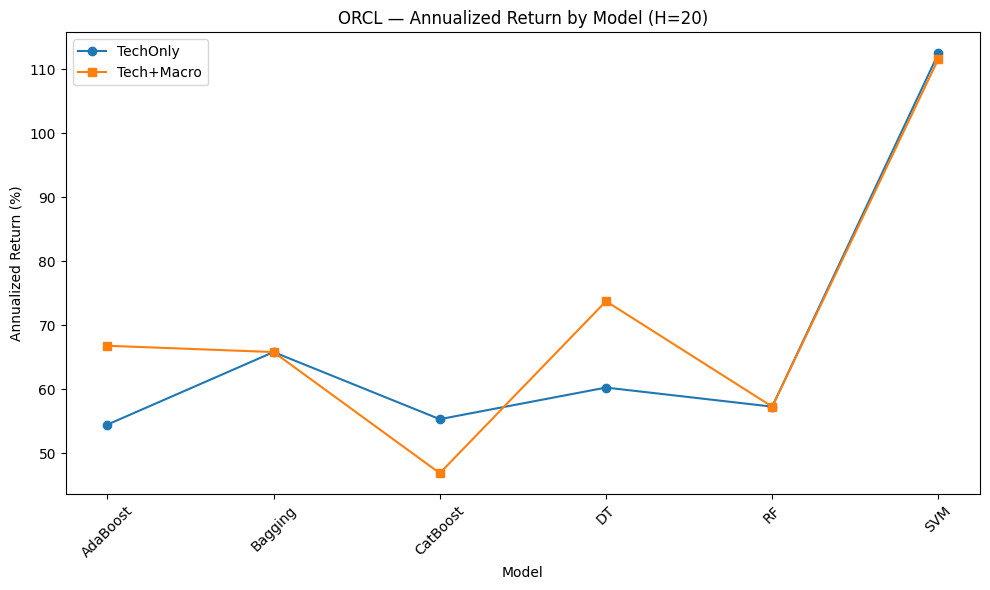


Best Tech+Macro for ORCL, H=5: DT, Ann.Return=117.37%, ROI=140.73%


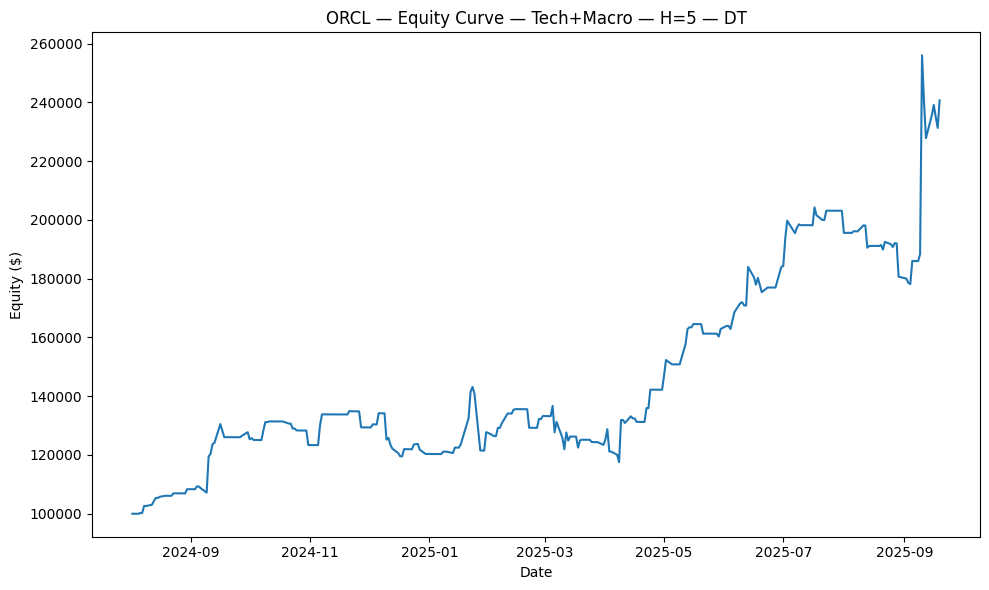

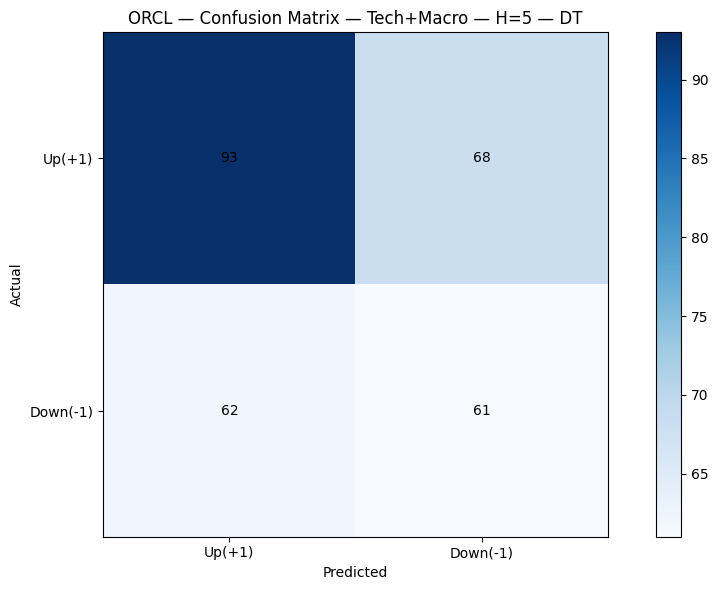

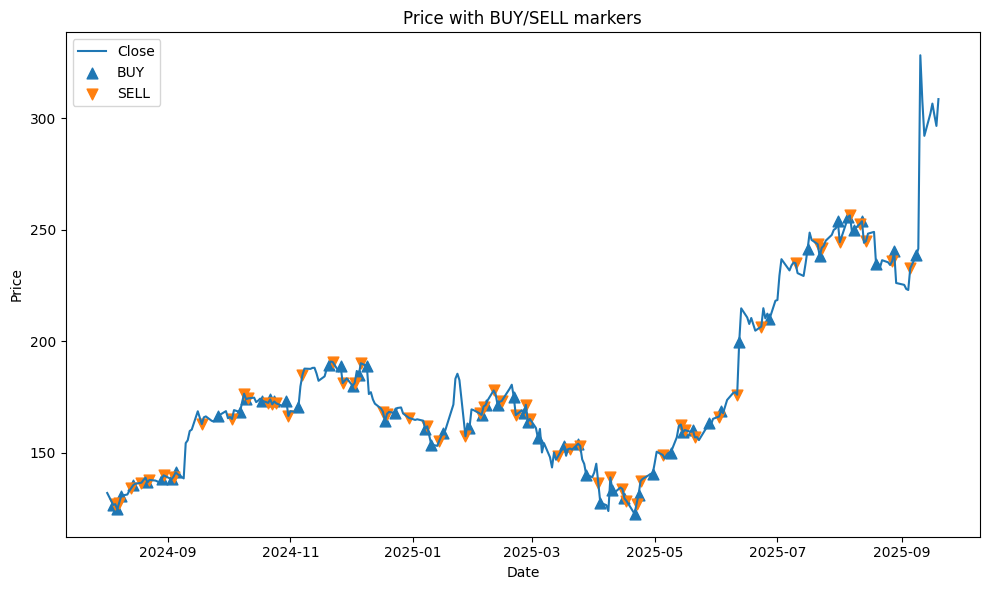

ORCL — Trade log (first 25 rows) — Tech+Macro — H=5 — DT


Date       Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  131.899840         -1         0   CASH  100000.000000   
1  2024-08-05  126.535965          1         1    BUY     -25.000000   
2  2024-08-06  126.882350         -1         0   SELL  100248.675871   
3  2024-08-07  124.596250          1         1    BUY     -25.062169   
4  2024-08-08  127.624580         -1         0   SELL  102659.563227   
5  2024-08-09  130.692470          1         1    BUY     -25.664891   
6  2024-08-12  131.207090          1         1   HOLD     -25.664891   
7  2024-08-13  132.869670          1         1   HOLD     -25.664891   
8  2024-08-14  134.195820         -1         0   SELL  105385.108622   
9  2024-08-15  135.512020          1         1    BUY     -26.346277   
10 2024-08-16  136.046450          1         1   HOLD     -26.346277   
11 2024-08-19  136.491790         -1         0   SELL  106120.520266   
12 2024-08-20  137.728840         -1         0   CASH  106120.520266   
13 2024-08-21  138.748170         -1         0   CASH  106120.520266   
14 2024-08-22  136.650130          1         1    BUY     -26.530130   
15 2024-08-23  137.748640         -1         0   SELL  106946.863888   
16 2024-08-26  137.461640         -1         0   CASH  106946.863888   
17 2024-08-27  137.045970         -1         0   CASH  106946.863888   
18 2024-08-28  136.452200         -1         0   CASH  106946.863888   
19 2024-08-29  137.976240          1         1    BUY     -26.736716   
20 2024-08-30  139.826870         -1         0   SELL  108354.211728   
21 2024-09-03  138.055440          1         1    BUY     -27.088553   
22 2024-09-04  139.292480         -1         0   SELL  109297.783835   
23 2024-09-05  141.133210          1         1    BUY     -27.324446   
24 2024-09-06  140.341500          1         1   HOLD     -27.324446   

        Shares         Equity  
0     0.000000  100000.000000  
1   790.289148   99975.000000  
2     0.000000  100248.675871  
3   804.588227  100223.613702  
4     0.000000  102659.563227  
5   785.504805  102633.898336  
6   785.504805  103038.134819  
7   785.504805  104344.099399  
8     0.000000  105385.108622  
9   777.680892  105358.762345  
10  777.680892  105774.378344  
11    0.000000  106120.520266  
12    0.000000  106120.520266  
13    0.000000  106120.520266  
14  776.585579  106093.990136  
15    0.000000  106946.863888  
16    0.000000  106946.863888  
17    0.000000  106946.863888  
18    0.000000  106946.863888  
19  775.110728  106920.127172  
20    0.000000  108354.211728  
21  784.860138  108327.123175  
22    0.000000  109297.783835  
23  774.429943  109270.459389  
24  774.429943  108657.335458


Best Tech+Macro for ORCL, H=10: Bagging, Ann.Return=132.46%, ROI=159.73%


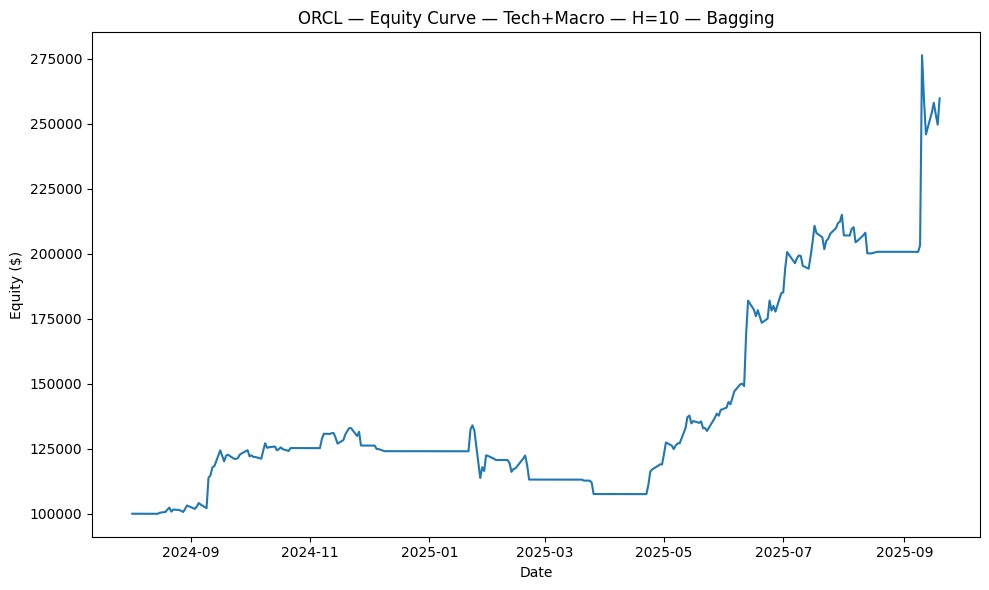

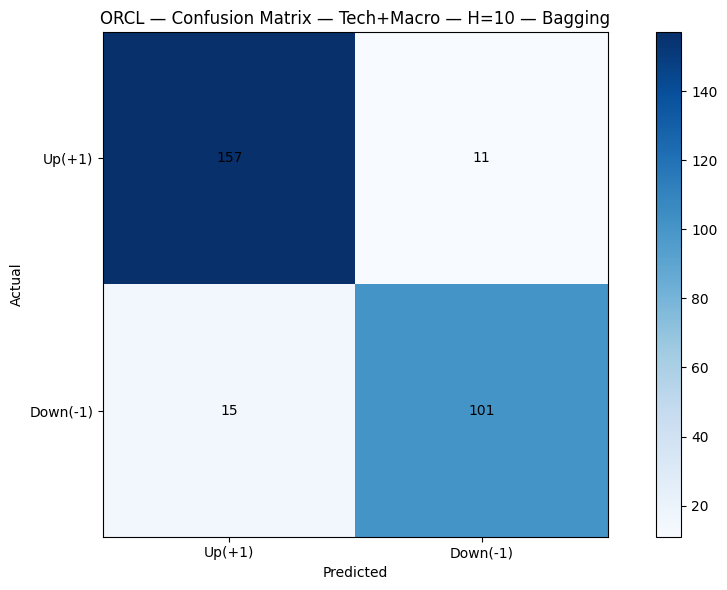

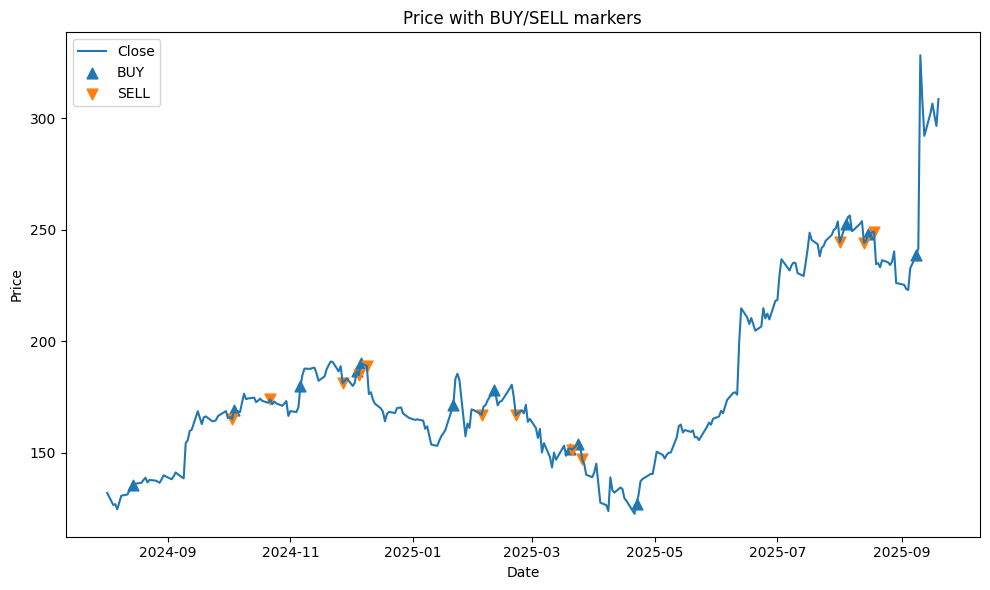

ORCL — Trade log (first 25 rows) — Tech+Macro — H=10 — Bagging


Date       Close  Pred_Sign  Position Action      Cash      Shares  \
0  2024-08-02  131.899840         -1         0   CASH  100000.0    0.000000   
1  2024-08-05  126.535965         -1         0   CASH  100000.0    0.000000   
2  2024-08-06  126.882350         -1         0   CASH  100000.0    0.000000   
3  2024-08-07  124.596250         -1         0   CASH  100000.0    0.000000   
4  2024-08-08  127.624580         -1         0   CASH  100000.0    0.000000   
5  2024-08-09  130.692470         -1         0   CASH  100000.0    0.000000   
6  2024-08-12  131.207090         -1         0   CASH  100000.0    0.000000   
7  2024-08-13  132.869670         -1         0   CASH  100000.0    0.000000   
8  2024-08-14  134.195820         -1         0   CASH  100000.0    0.000000   
9  2024-08-15  135.512020          1         1    BUY     -25.0  737.941918   
10 2024-08-16  136.046450          1         1   HOLD     -25.0  737.941918   
11 2024-08-19  136.491790          1         1   HOLD     -25.0  737.941918   
12 2024-08-20  137.728840          1         1   HOLD     -25.0  737.941918   
13 2024-08-21  138.748170          1         1   HOLD     -25.0  737.941918   
14 2024-08-22  136.650130          1         1   HOLD     -25.0  737.941918   
15 2024-08-23  137.748640          1         1   HOLD     -25.0  737.941918   
16 2024-08-26  137.461640          1         1   HOLD     -25.0  737.941918   
17 2024-08-27  137.045970          1         1   HOLD     -25.0  737.941918   
18 2024-08-28  136.452200          1         1   HOLD     -25.0  737.941918   
19 2024-08-29  137.976240          1         1   HOLD     -25.0  737.941918   
20 2024-08-30  139.826870          1         1   HOLD     -25.0  737.941918   
21 2024-09-03  138.055440          1         1   HOLD     -25.0  737.941918   
22 2024-09-04  139.292480          1         1   HOLD     -25.0  737.941918   
23 2024-09-05  141.133210          1         1   HOLD     -25.0  737.941918   
24 2024-09-06  140.341500          1         1   HOLD     -25.0  737.941918   

           Equity  
0   100000.000000  
1   100000.000000  
2   100000.000000  
3   100000.000000  
4   100000.000000  
5   100000.000000  
6   100000.000000  
7   100000.000000  
8   100000.000000  
9    99975.000000  
10  100369.378299  
11  100698.013353  
12  101610.884403  
13  102363.090739  
14  100814.859077  
15  101625.495653  
16  101413.706323  
17  101106.966006  
18  100668.798233  
19  101793.451234  
20  103159.108686  
21  101851.896234  
22  102764.759905  
23  104123.111732  
24  103538.875736


Best Tech+Macro for ORCL, H=20: SVM, Ann.Return=111.65%, ROI=133.58%


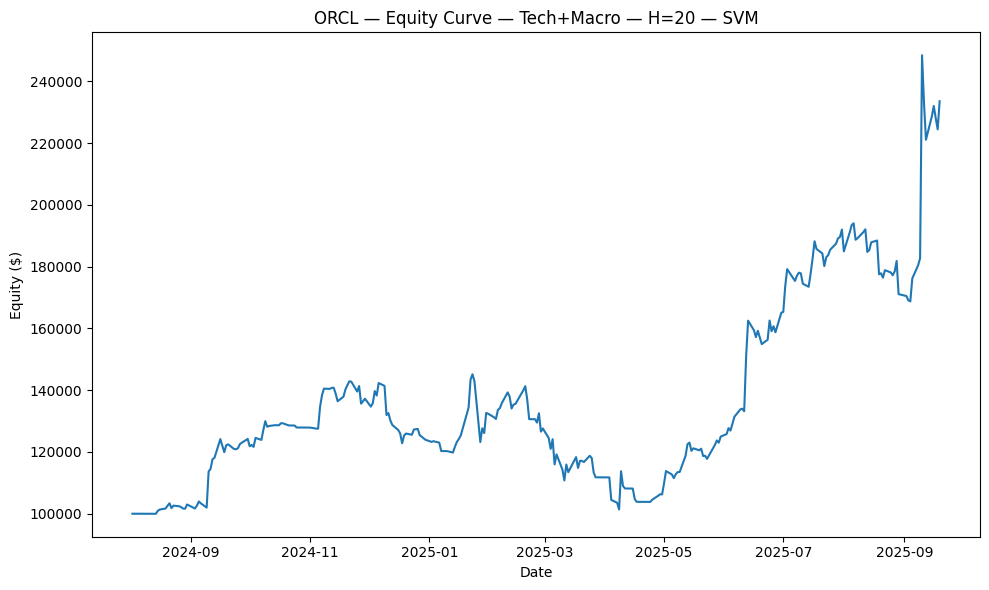

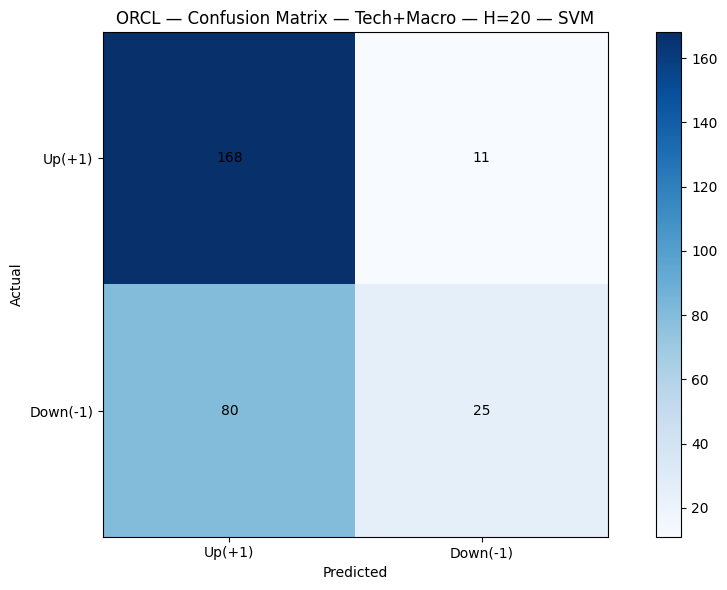

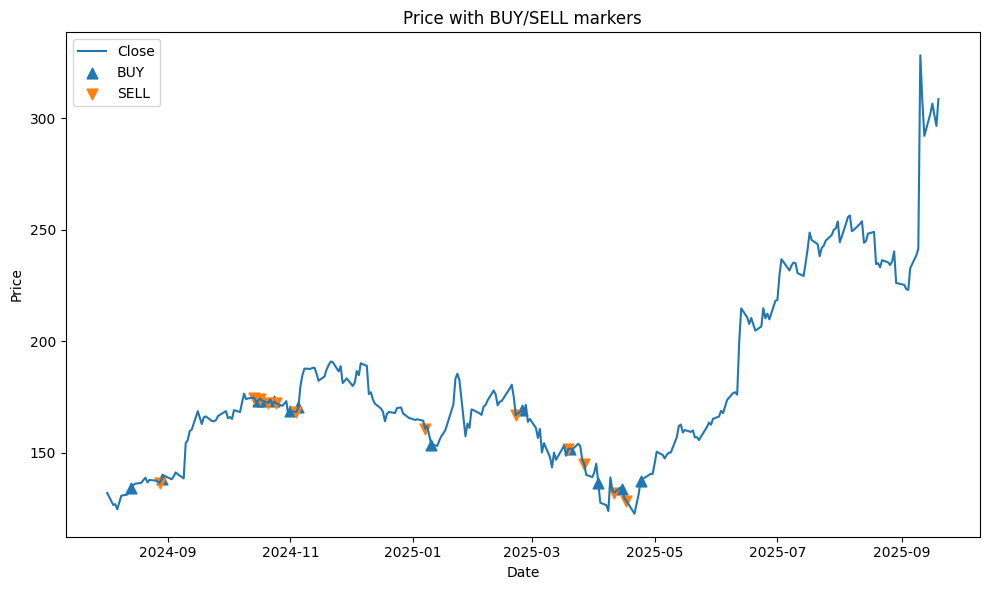

ORCL — Trade log (first 25 rows) — Tech+Macro — H=20 — SVM


Date       Close  Pred_Sign  Position Action           Cash  \
0  2024-08-02  131.899840         -1         0   CASH  100000.000000   
1  2024-08-05  126.535965         -1         0   CASH  100000.000000   
2  2024-08-06  126.882350         -1         0   CASH  100000.000000   
3  2024-08-07  124.596250         -1         0   CASH  100000.000000   
4  2024-08-08  127.624580         -1         0   CASH  100000.000000   
5  2024-08-09  130.692470         -1         0   CASH  100000.000000   
6  2024-08-12  131.207090         -1         0   CASH  100000.000000   
7  2024-08-13  132.869670         -1         0   CASH  100000.000000   
8  2024-08-14  134.195820          1         1    BUY     -25.000000   
9  2024-08-15  135.512020          1         1   HOLD     -25.000000   
10 2024-08-16  136.046450          1         1   HOLD     -25.000000   
11 2024-08-19  136.491790          1         1   HOLD     -25.000000   
12 2024-08-20  137.728840          1         1   HOLD     -25.000000   
13 2024-08-21  138.748170          1         1   HOLD     -25.000000   
14 2024-08-22  136.650130          1         1   HOLD     -25.000000   
15 2024-08-23  137.748640          1         1   HOLD     -25.000000   
16 2024-08-26  137.461640          1         1   HOLD     -25.000000   
17 2024-08-27  137.045970          1         1   HOLD     -25.000000   
18 2024-08-28  136.452200         -1         0   SELL  101655.988204   
19 2024-08-29  137.976240          1         1    BUY     -25.413997   
20 2024-08-30  139.826870          1         1   HOLD     -25.413997   
21 2024-09-03  138.055440          1         1   HOLD     -25.413997   
22 2024-09-04  139.292480          1         1   HOLD     -25.413997   
23 2024-09-05  141.133210          1         1   HOLD     -25.413997   
24 2024-09-06  140.341500          1         1   HOLD     -25.413997   

        Shares         Equity  
0     0.000000  100000.000000  
1     0.000000  100000.000000  
2     0.000000  100000.000000  
3     0.000000  100000.000000  
4     0.000000  100000.000000  
5     0.000000  100000.000000  
6     0.000000  100000.000000  
7     0.000000  100000.000000  
8   745.179693   99975.000000  
9   745.179693  100955.805512  
10  745.179693  101354.051896  
11  745.179693  101685.910221  
12  745.179693  102607.734760  
13  745.179693  103367.318777  
14  745.179693  101803.901973  
15  745.179693  102622.489318  
16  745.179693  102408.622746  
17  745.179693  102098.873903  
18    0.000000  101655.988204  
19  736.764447  101630.574207  
20  736.764447  102994.052596  
21  736.764447  101688.925952  
22  736.764447  102600.333043  
23  736.764447  103956.517465  
24  736.764447  103373.213684

/tmp/ipython-input-1667154152.py:233: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


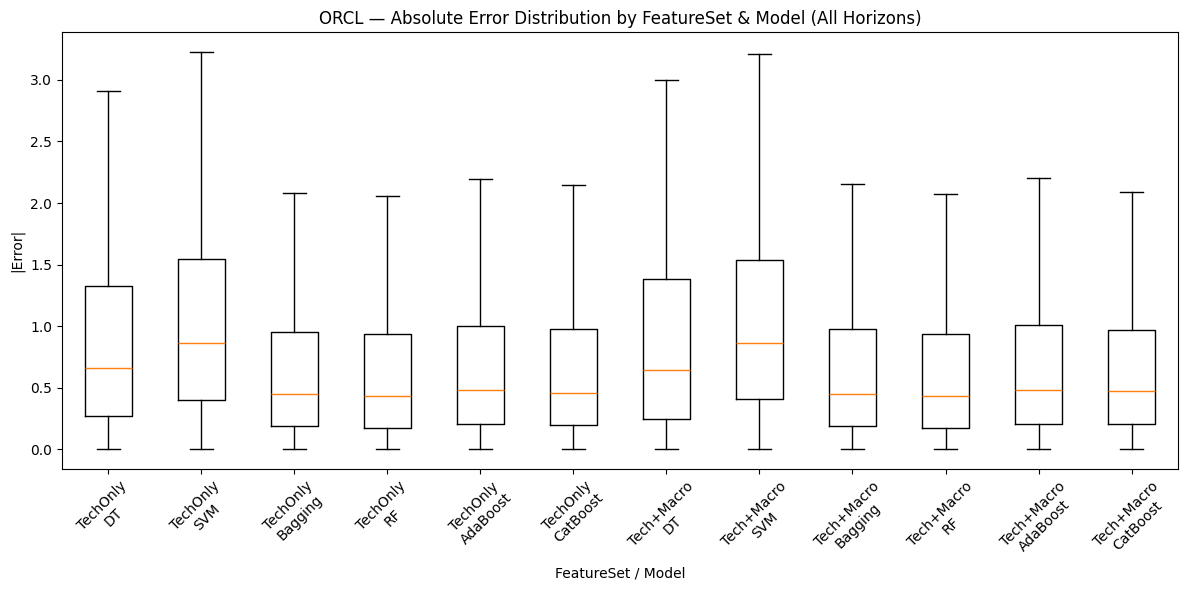

In [ ]:
res_ORCL = run_for_stock("ORCL")


In [ ]:

all_results = pd.concat(GLOBAL_RESULTS, ignore_index=True)

print("GLOBAL RESULTS (first 30 rows):")
display(all_results.head(30))

print("\nAverage performance by FeatureSet across ALL stocks, horizons, and models:")
avg_fs_global = (all_results
                 .groupby("FeatureSet")
                 [["MAE","RMSE","Accuracy","F1",
                   "ROI_%","AnnualizedReturn_%","MaxDrawdown_%"]]
                 .mean()
                 .round(4))
display(avg_fs_global)

print("\nAverage performance by FeatureSet & Horizon (ALL stocks, ALL models):")
avg_fs_h_global = (all_results
                   .groupby(["FeatureSet","Horizon"])
                   [["MAE","RMSE","Accuracy","F1",
                     "ROI_%","AnnualizedReturn_%","MaxDrawdown_%"]]
                   .mean()
                   .round(4))
display(avg_fs_h_global)


avg_fs_plot = avg_fs_global.reset_index()
plt.figure()
x = np.arange(len(avg_fs_plot))
w = 0.35
plt.bar(x - w/2, avg_fs_plot["AnnualizedReturn_%"], w, label="Ann. Return (%)")
plt.bar(x + w/2, avg_fs_plot["ROI_%"],              w, label="ROI (%)")
plt.xticks(x, avg_fs_plot["FeatureSet"])
plt.title("Global: TechOnly vs Tech+Macro (all stocks, horizons, models)")
plt.ylabel("Percent")
plt.legend()
plt.tight_layout()
plt.show()


for ticker in TICKERS:
    sub = all_results[all_results["Ticker"] == ticker]
    avg = (sub
           .groupby("FeatureSet")[["AnnualizedReturn_%","ROI_%"]]
           .mean()
           .reset_index())

    plt.figure()
    x = np.arange(len(avg))
    w = 0.35
    plt.bar(x - w/2, avg["AnnualizedReturn_%"], w, label="Ann. Return (%)")
    plt.bar(x + w/2, avg["ROI_%"],              w, label="ROI (%)")
    plt.xticks(x, avg["FeatureSet"])
    plt.title(f"{ticker}: TechOnly vs Tech+Macro (mean over horizons & models)")
    plt.ylabel("Percent")
    plt.legend()
    plt.tight_layout()
    plt.show()


best_rows = []

for ticker in TICKERS:
    for h in sorted(HORIZON_MAP.keys()):
        sub = all_results[(all_results["Ticker"] == ticker) &
                          (all_results["Horizon"] == h)]
        if sub.empty:
            continue

        sub_macro = sub[sub["FeatureSet"] == "Tech+Macro"]
        sub_tech  = sub[sub["FeatureSet"] == "TechOnly"]
        if sub_macro.empty or sub_tech.empty:
            continue

        macro_best = sub_macro.loc[sub_macro["AnnualizedReturn_%"].idxmax()]
        tech_best  = sub_tech.loc[sub_tech["AnnualizedReturn_%"].idxmax()]

        best_rows.append({
            "Ticker": ticker,
            "Horizon": h,
            "BestMacroModel": macro_best["Model"],
            "Macro_ROI_%": macro_best["ROI_%"],
            "Macro_AnnualizedReturn_%": macro_best["AnnualizedReturn_%"],
            "BestTechModel": tech_best["Model"],
            "Tech_ROI_%": tech_best["ROI_%"],
            "Tech_AnnualizedReturn_%": tech_best["AnnualizedReturn_%"],
            "MacroMinusTech_AnnRet_%": macro_best["AnnualizedReturn_%"] - tech_best["AnnualizedReturn_%"],
            "MacroMinusTech_ROI_%": macro_best["ROI_%"] - tech_best["ROI_%"]
        })

best_compare_df = pd.DataFrame(best_rows)

print("\nBest Tech+Macro model vs best Tech-only model for each stock & horizon:")
display(best_compare_df.sort_values(["Ticker","Horizon"]).reset_index(drop=True))


macro_beats = best_compare_df[best_compare_df["MacroMinusTech_AnnRet_%"] > 0].copy()
macro_beats = macro_beats.sort_values("MacroMinusTech_AnnRet_%", ascending=False)

print("\nCases where Tech+Macro OUTPERFORMED Tech-only (by Annualized Return):")
display(macro_beats.reset_index(drop=True))


tech_beats = best_compare_df[best_compare_df["MacroMinusTech_AnnRet_%"] <= 0].copy()
tech_beats = tech_beats.sort_values("MacroMinusTech_AnnRet_%", ascending=True)

print("\nCases where Tech-only outperformed or tied Tech+Macro (by Annualized Return):")
display(tech_beats.reset_index(drop=True))
